<a href="https://colab.research.google.com/github/UsfHajaj/Deep-Learning-Project/blob/main/Untitled38.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
np.random.seed(10)
random_dim = 100

In [8]:
# Load the MNIST dataset and normalize each pixel value to 0-1 range.
def load_mnist():
  (x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
  x_train, x_test = (x_train-127.5)/127.5, (x_test-127.5)/127.5
  x_train = x_train.reshape((-1,28,28,1))
  x_test = x_test.reshape((-1,28,28,1))
  return (x_train, y_train, x_test, y_test)

In [15]:
def define_generator(latent_dim):
  # takes 2 input: latent_vec and label
  # foundation of image
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(128*7*7, activation='relu', input_dim=latent_dim))
  model.add(tf.keras.layers.Reshape((7,7,128)))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.Conv2D(1,3,padding='same',activation='tanh'))

  # label encoding
  z = tf.keras.layers.Input(shape=(latent_dim,))
  label = tf.keras.layers.Input(shape=(1,),dtype='uint8')
  label_embed = tf.keras.layers.Embedding(10, latent_dim, input_length=1)(label)
  label_embed = tf.keras.layers.Flatten()(label_embed)
  combined = tf.keras.layers.multiply([z, label_embed])

  img = model(combined)

  return tf.keras.models.Model([z, label], img)

latent_dim = 100
g_model = define_generator(latent_dim)
g_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 100)               1000      ['input_8[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten_3 (Flatten)         (None, 100)                  0         ['embedding_2[0][0]']         
                                                                                            

In [16]:
def define_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32,(3,3),2,input_shape=(28,28,2),padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(64,(3,3),2,padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  img = tf.keras.layers.Input(shape=(28, 28, 1))
  label = tf.keras.layers.Input(shape=(1,))
  label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=np.prod((28,28)), input_length=1)(label)
  label_embed = tf.keras.layers.Flatten()(label_embed)
  label_embed = tf.keras.layers.Reshape((28, 28, 1))(label_embed)
  concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embed, img])
  prediction = model(concatenated)
  return tf.keras.models.Model([img, label], prediction)

d_model = define_discriminator()
d_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 784)               7840      ['input_10[0][0]']            
                                                                                                  
 flatten_5 (Flatten)         (None, 784)                  0         ['embedding_3[0][0]']         
                                                                                                  
 reshape_3 (Reshape)         (None, 28, 28, 1)            0         ['flatten_5[0][0]']           
                                                                                            

In [17]:
d_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [18]:
z = tf.keras.layers.Input(shape=(100,))
label = tf.keras.layers.Input(shape=(1,))
img = g_model([z, label])

d_model.trainable = False
prediction = d_model([img, label])
cgan = tf.keras.models.Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cgan.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 model_3 (Functional)        (None, 28, 28, 1)            857193    ['input_11[0][0]',            
                                                                     'input_12[0][0]']            
                                                                                                  
 model_4 (Functional)        (None, 1)                    1633601   ['model_3[0][0]',       

In [19]:
x_train, y_train, x_test, y_test = load_mnist()

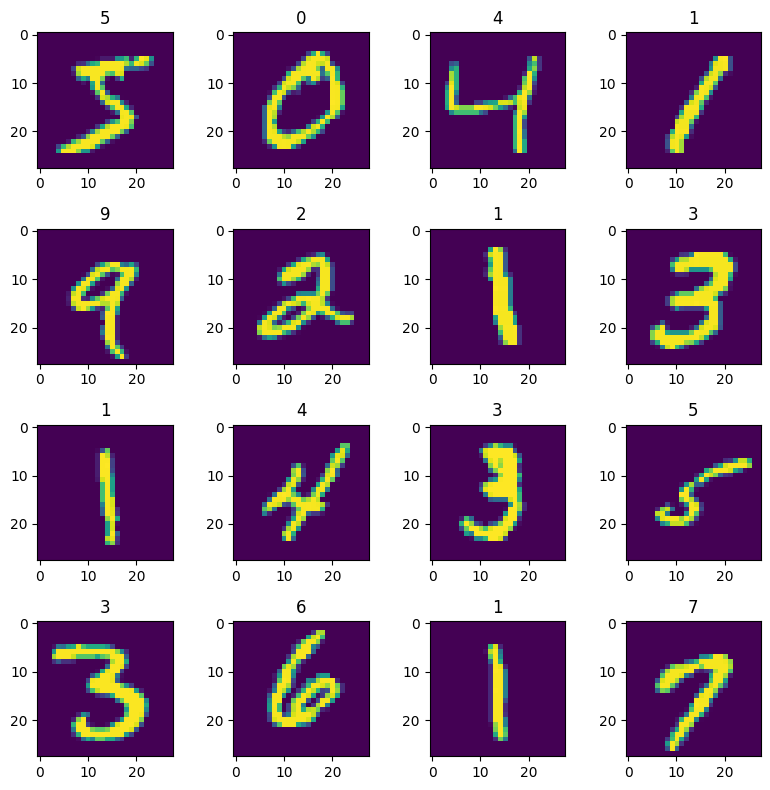

In [20]:
def plot_image(images, labels, rows, cols):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  for i in range(1, cols*rows +1):
      img = images[i-1]
      ax = fig.add_subplot(rows, cols, i)
      ax.title.set_text(labels[i-1])
      plt.imshow(img.reshape((28,28)))
  fig.tight_layout()
  plt.show()

samples = x_train[:4*4]
labels = y_train[:4*4]
plot_image(samples,labels, 4,4)

(60000, 28, 28, 1)
4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.6820730566978455 [0.1031264141201973, 1.0]
1/1 [==============================] - 0s 104ms/step


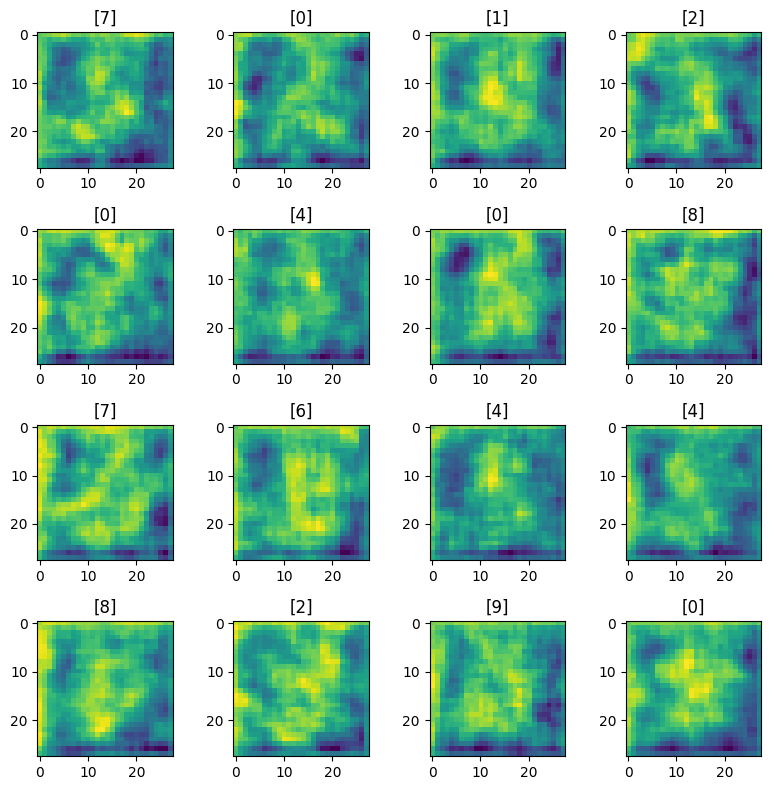

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.15571186039596796 [5.228671073913574, 0.0]
1/1 [==============================] - 0s 26ms/step


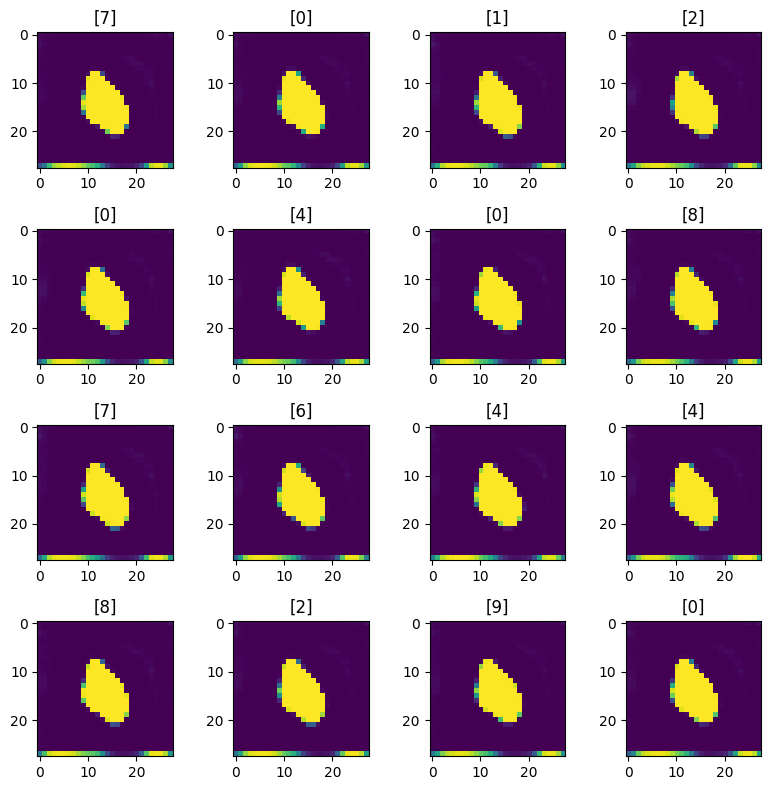

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.4999253898859024 [4.824827194213867, 0.0]
1/1 [==============================] - 0s 20ms/step


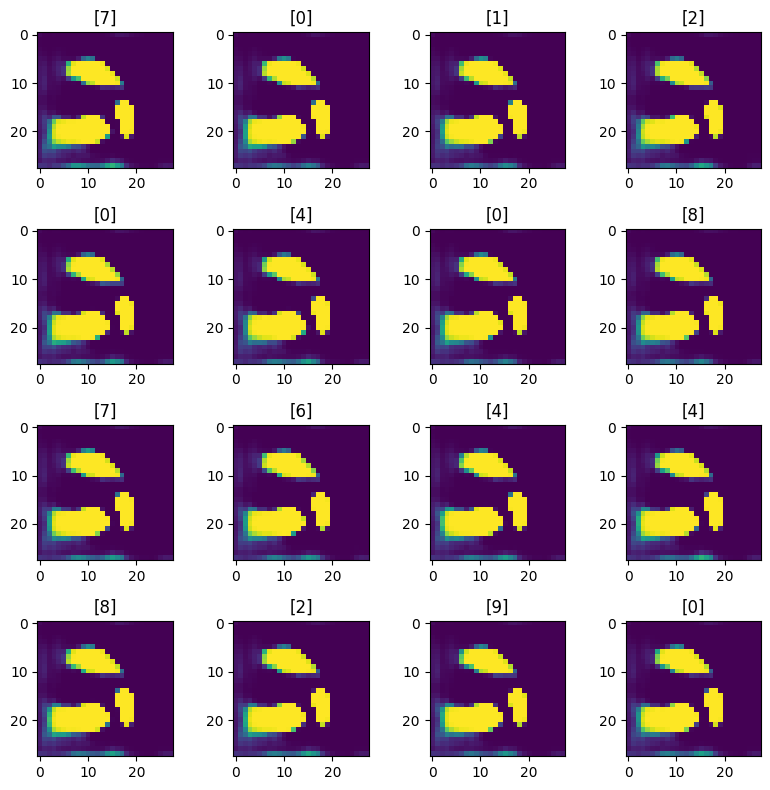

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.160304956138134 [8.176899909973145, 0.0]
1/1 [==============================] - 0s 18ms/step


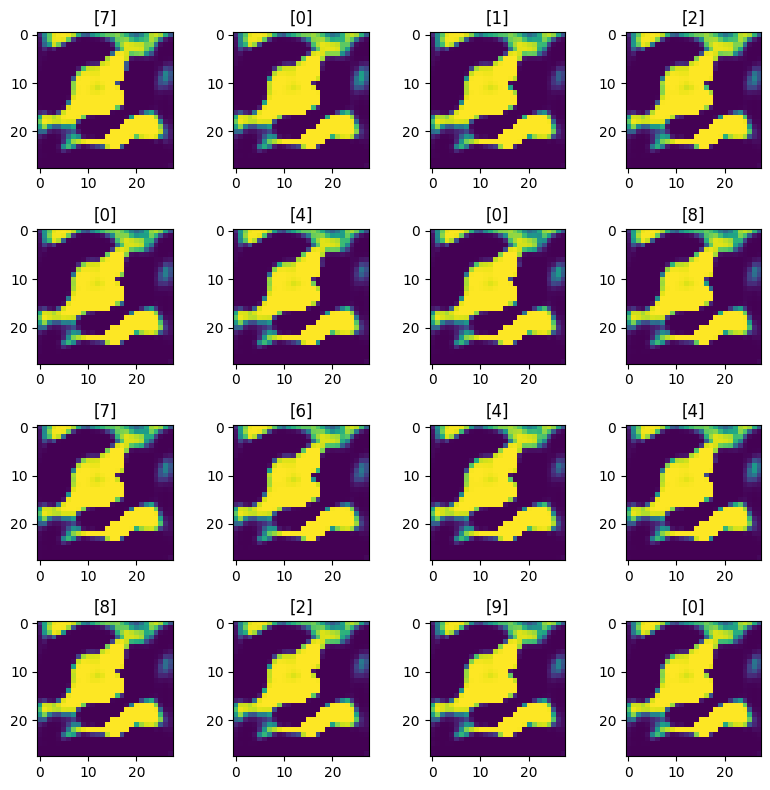

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.033670322969555855 [5.197671890258789, 0.0]
1/1 [==============================] - 0s 21ms/step


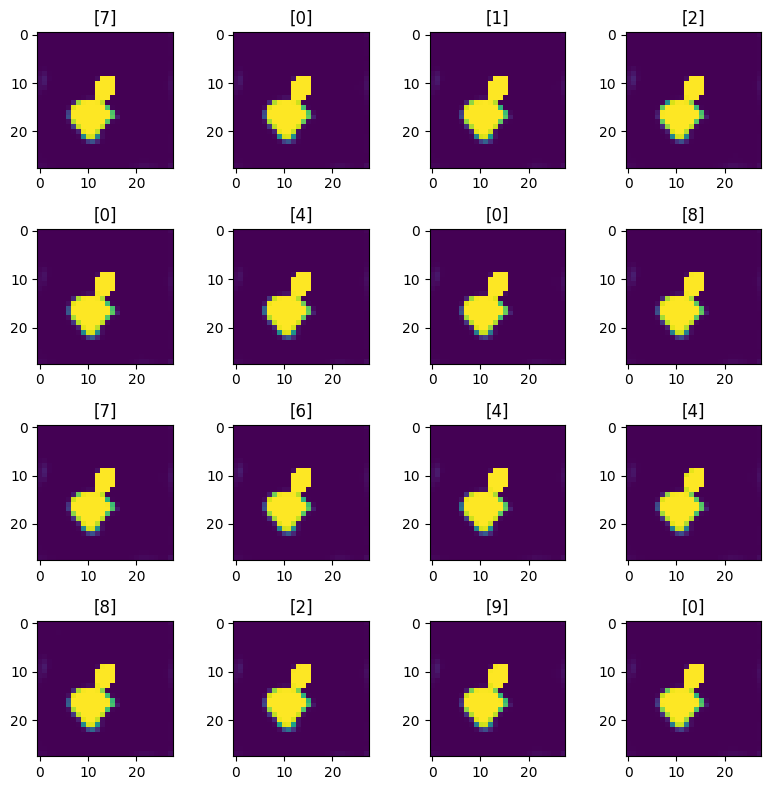

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.036630989983677864 [6.353348731994629, 0.0]
1/1 [==============================] - 0s 18ms/step


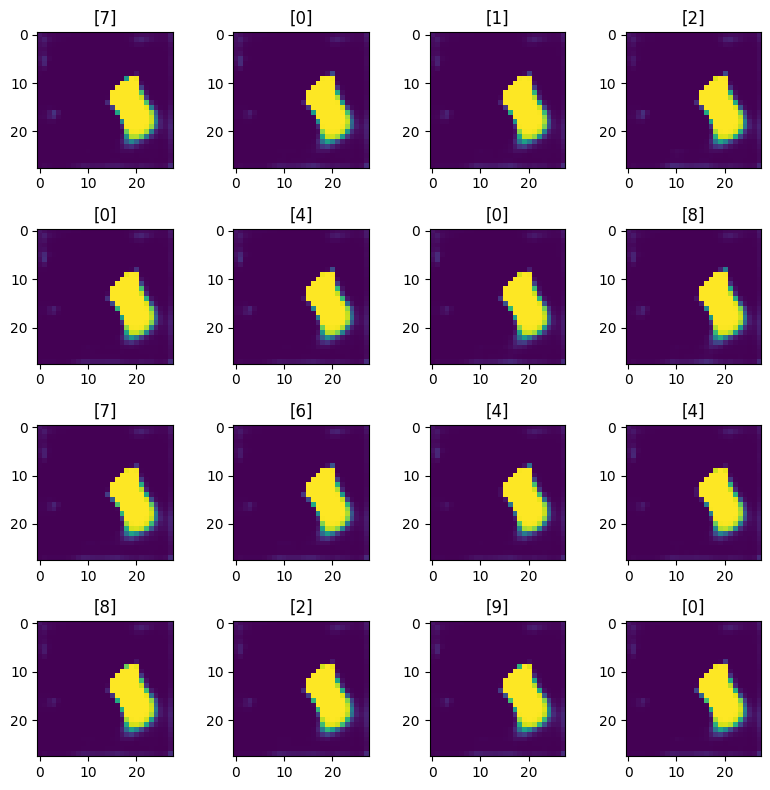

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.05737110020709224 [9.955470085144043, 0.0]
1/1 [==============================] - 0s 20ms/step


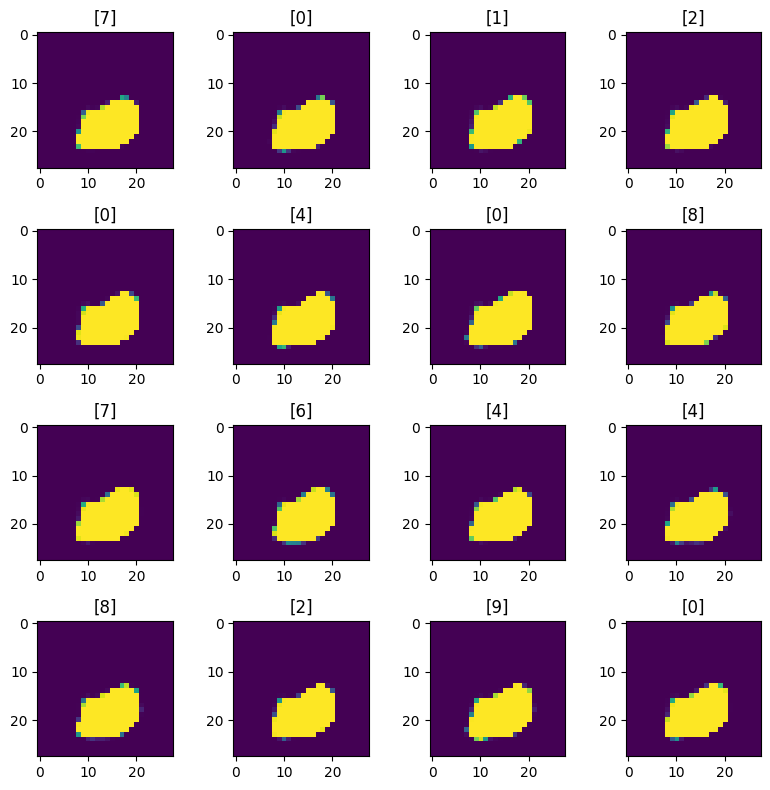

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.05445174127817154 [9.054797172546387, 0.0]
1/1 [==============================] - 0s 18ms/step


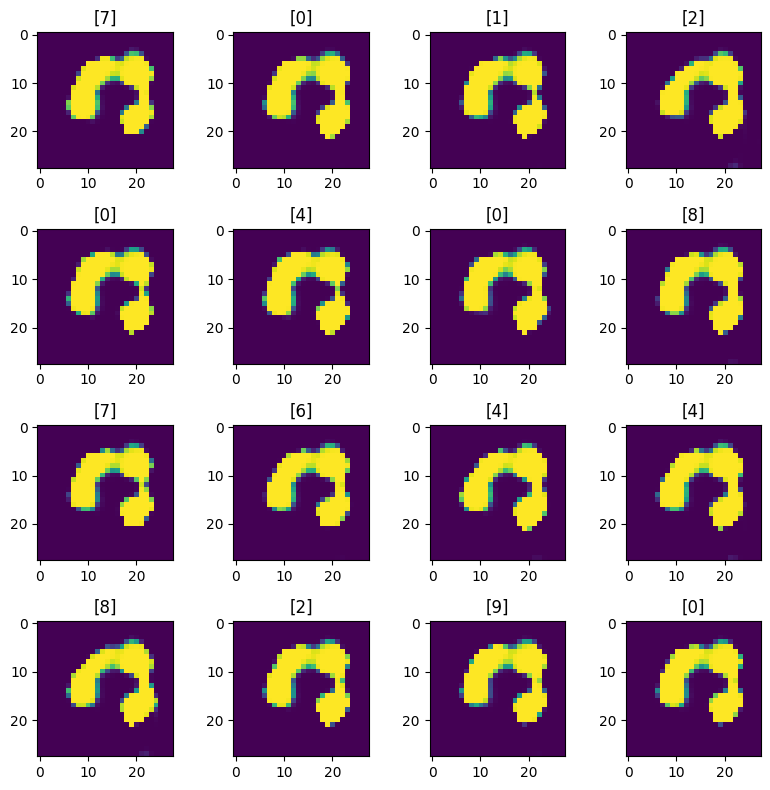

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.02123961690813303 [6.058839797973633, 0.0]
1/1 [==============================] - 0s 19ms/step


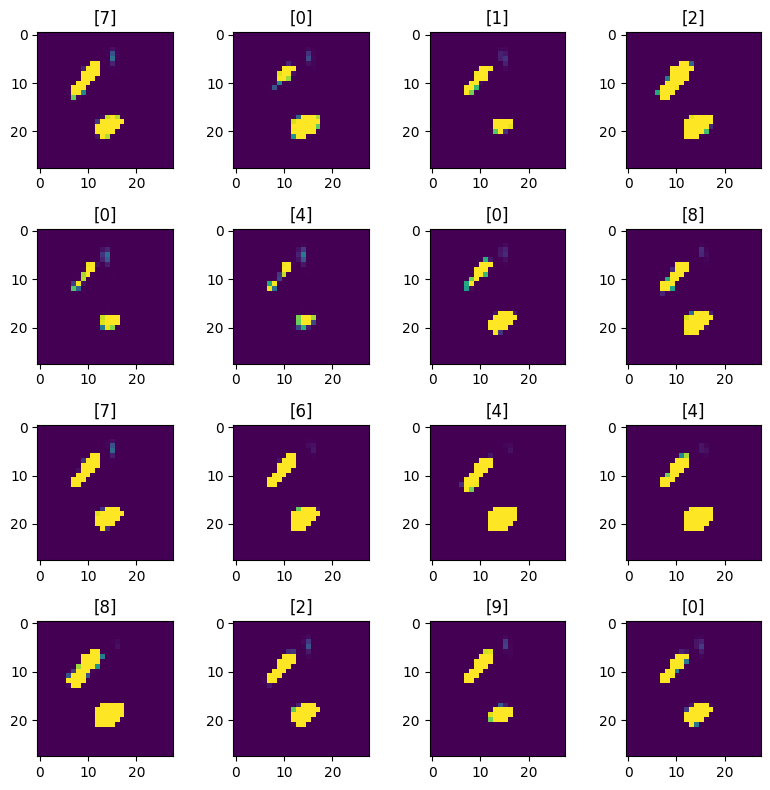

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.021819131448864937 [6.881160736083984, 0.0]
1/1 [==============================] - 0s 18ms/step


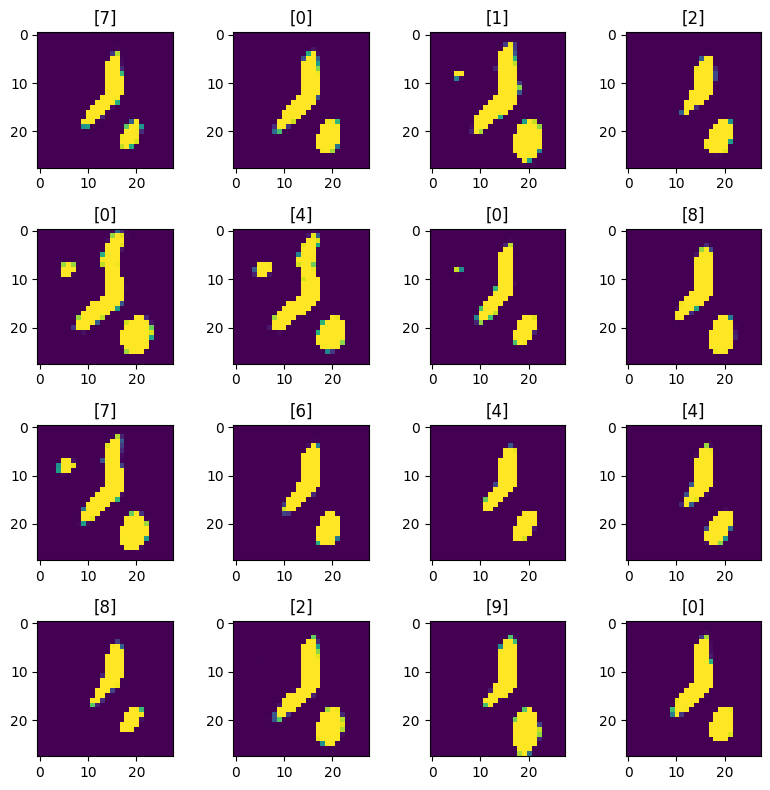

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.018781346967443824 [5.1983642578125, 0.0]
1/1 [==============================] - 0s 20ms/step


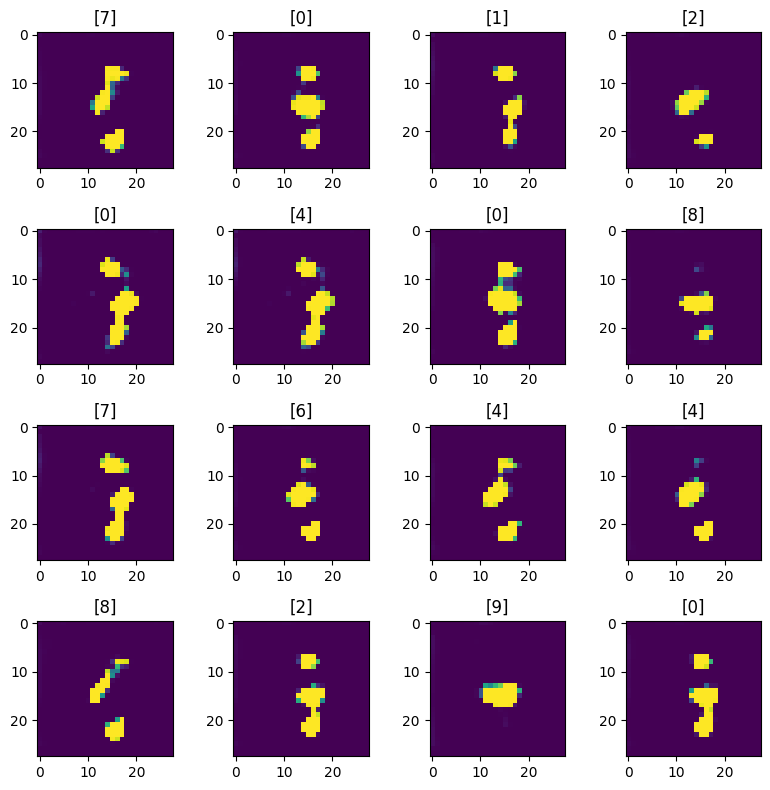

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.11889129877090454 [6.905499458312988, 0.0]
1/1 [==============================] - 0s 31ms/step


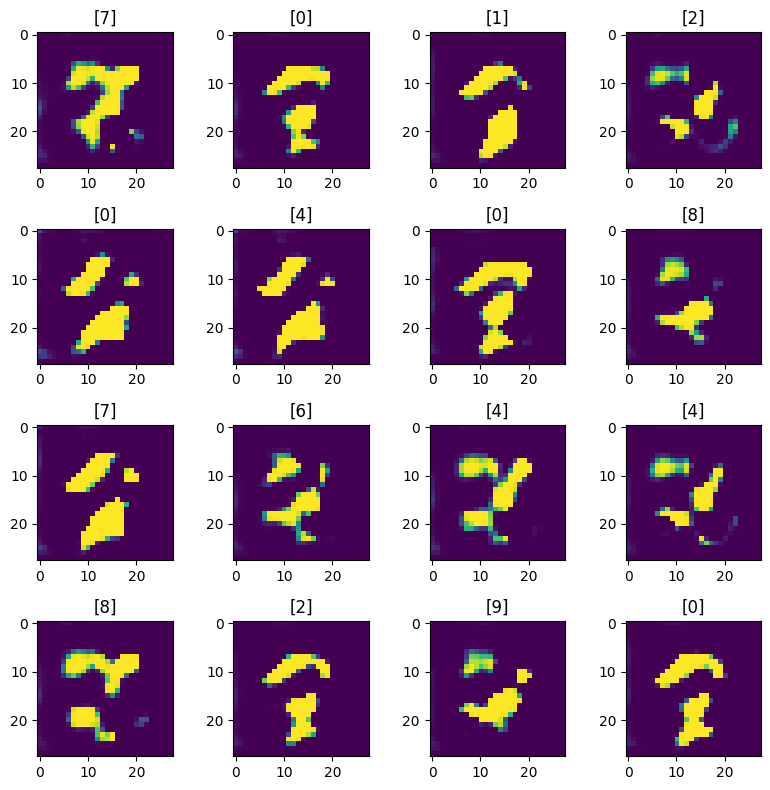

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.11802112683653831 [6.315102577209473, 0.0]
1/1 [==============================] - 0s 19ms/step


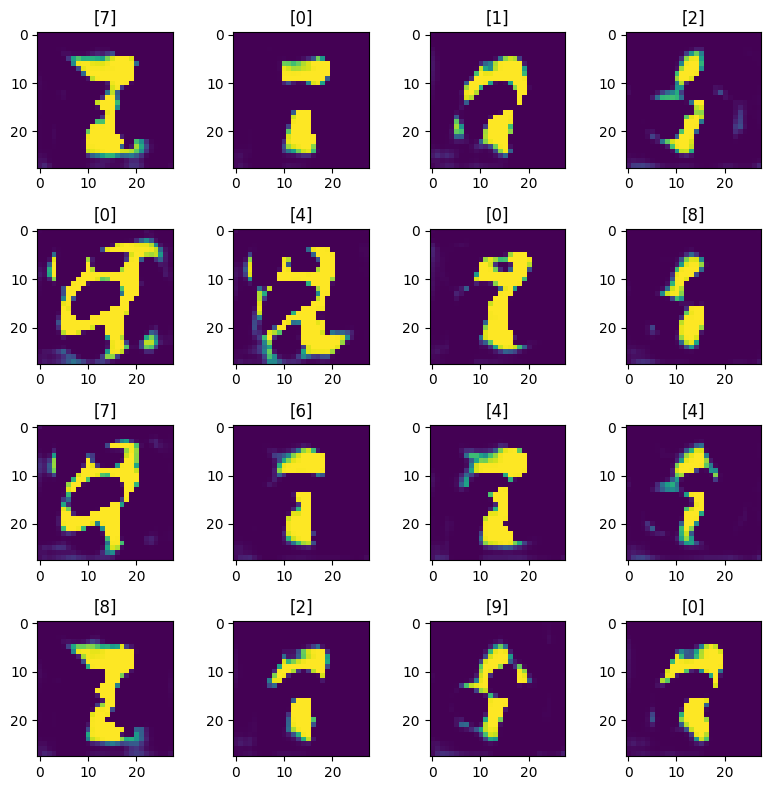

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.04225556738674641 [6.811075687408447, 0.0078125]
1/1 [==============================] - 0s 19ms/step


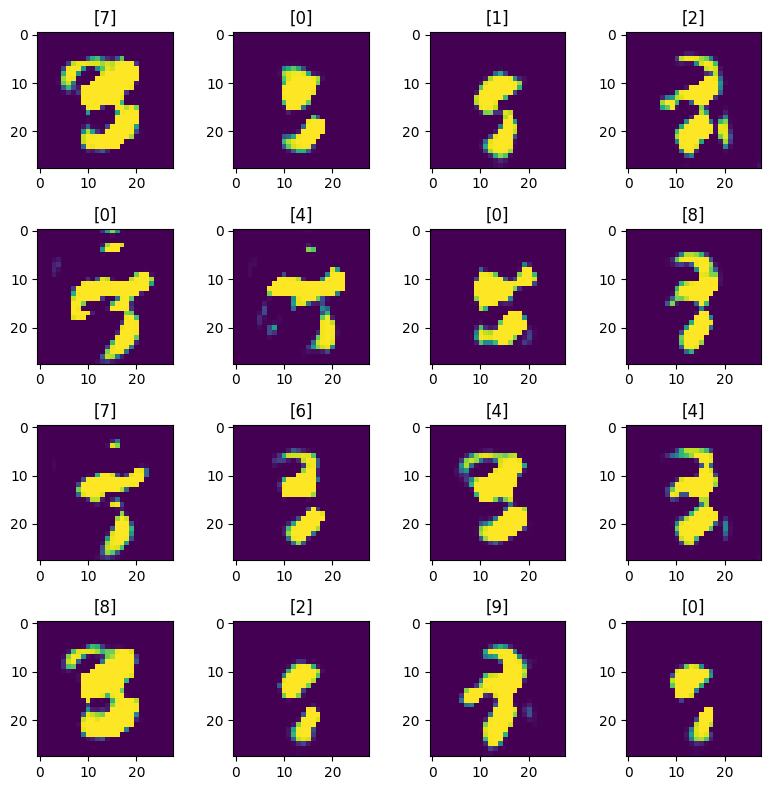

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.1183403804898262 [4.9989848136901855, 0.0078125]
1/1 [==============================] - 0s 27ms/step


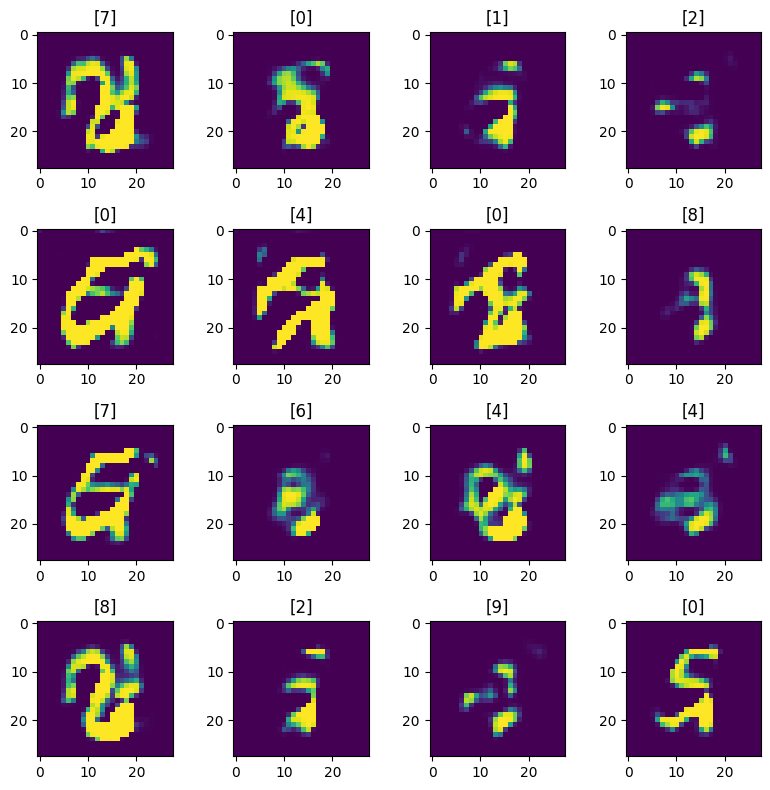

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.12204986810684204 [4.520923614501953, 0.0078125]
1/1 [==============================] - 0s 19ms/step


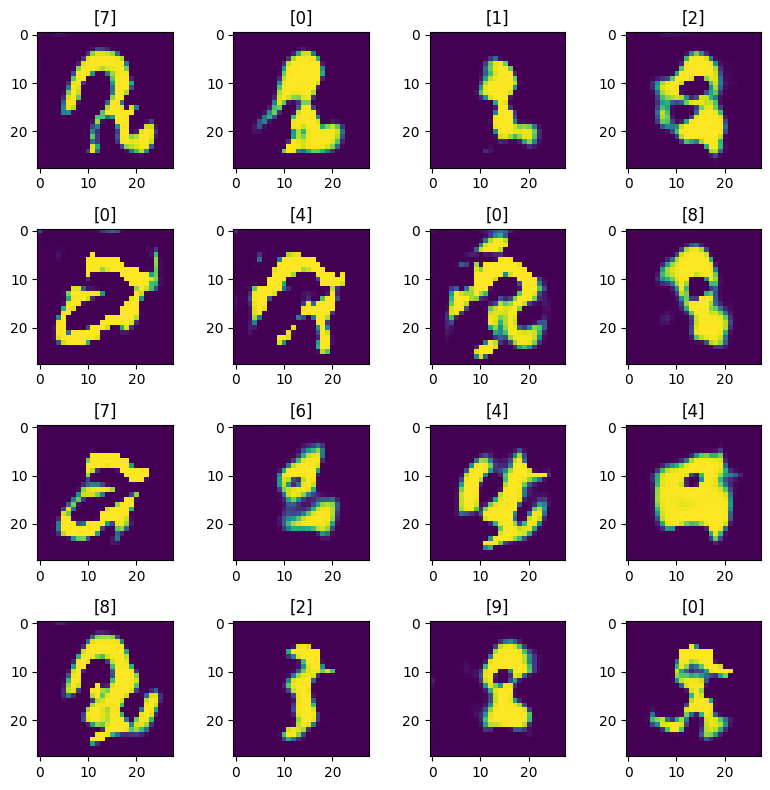

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.25892696529626846 [3.4549500942230225, 0.0546875]
1/1 [==============================] - 0s 17ms/step


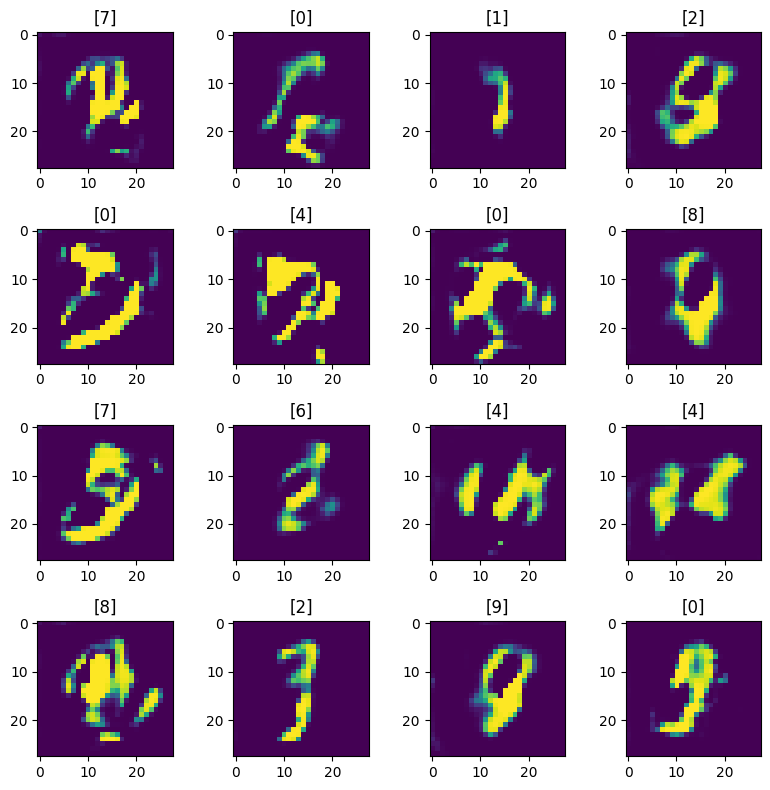

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.12913624942302704 [3.9998626708984375, 0.046875]
1/1 [==============================] - 0s 19ms/step


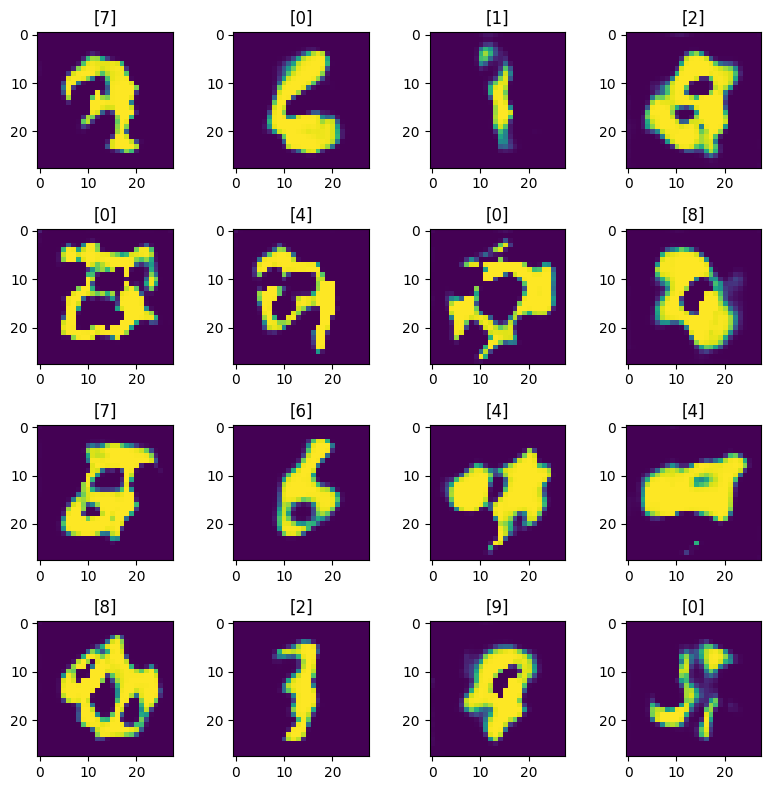

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.24961595982313156 [3.301769733428955, 0.0625]
1/1 [==============================] - 0s 38ms/step


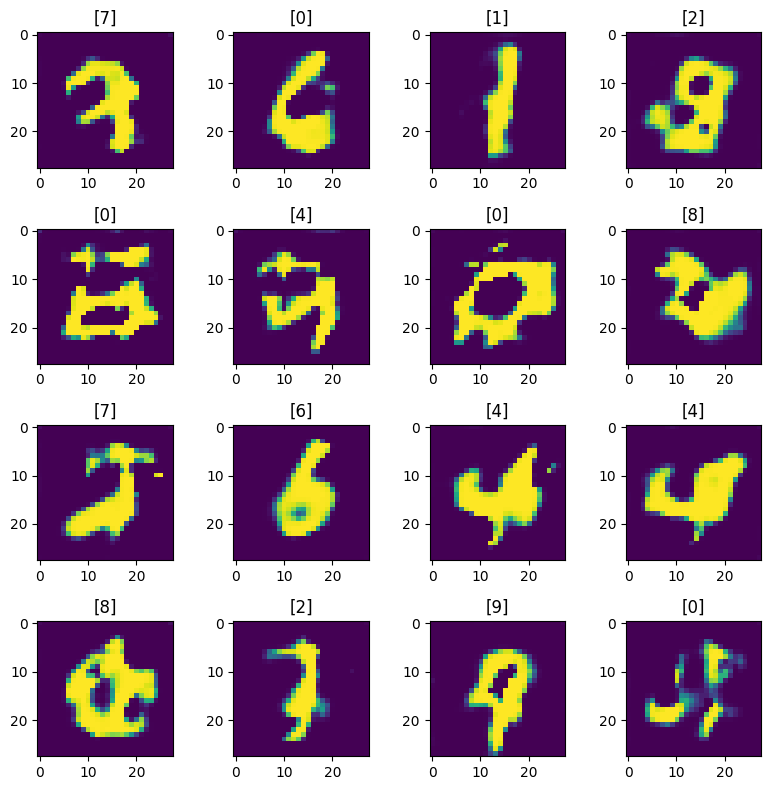

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.28521692752838135 [2.464885711669922, 0.09375]
1/1 [==============================] - 0s 21ms/step


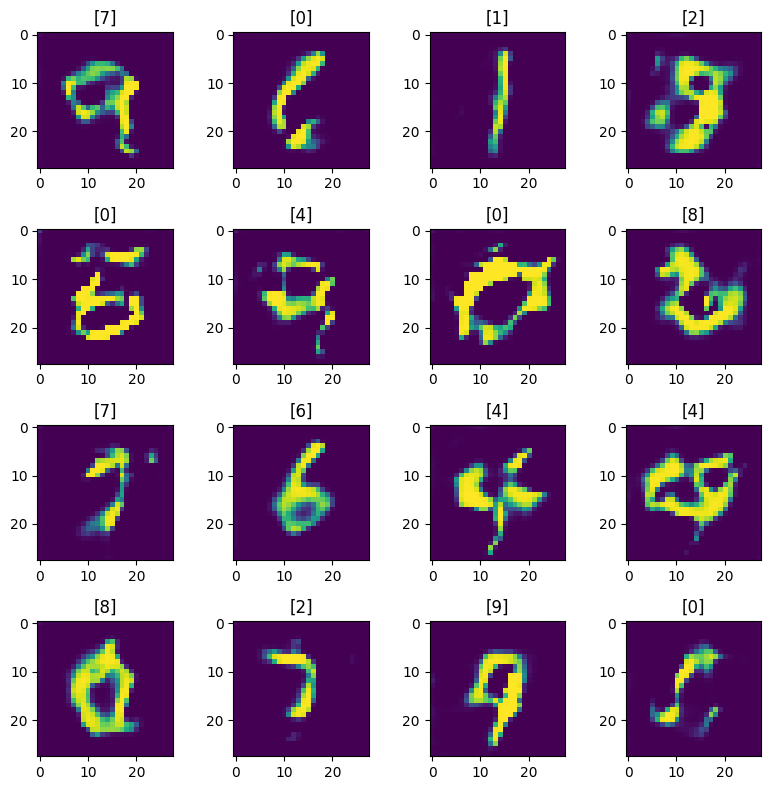

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.22486717998981476 [3.0694093704223633, 0.0625]
1/1 [==============================] - 0s 20ms/step


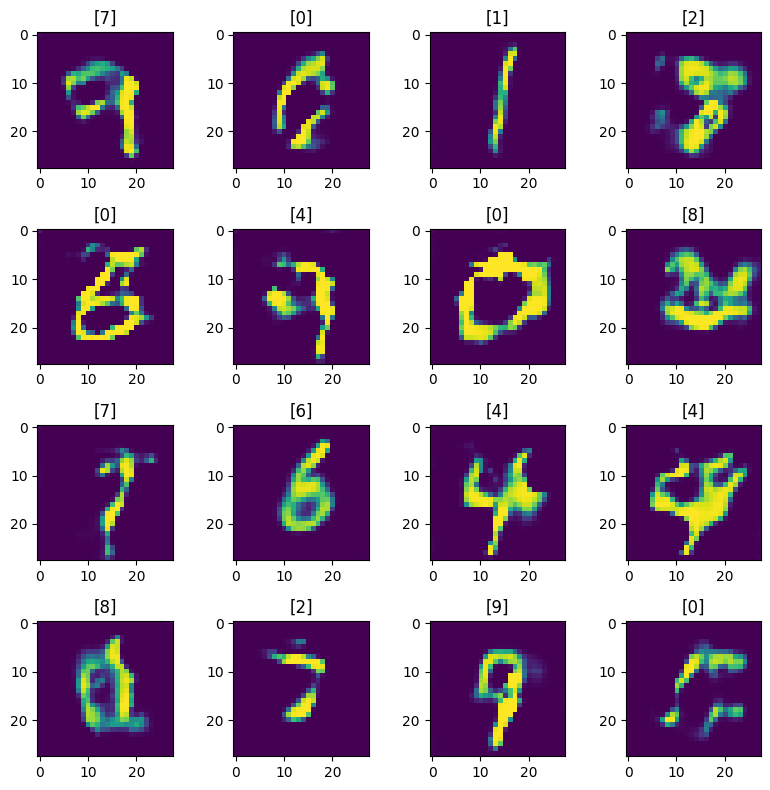

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.1679469533264637 [3.0419092178344727, 0.109375]
1/1 [==============================] - 0s 18ms/step


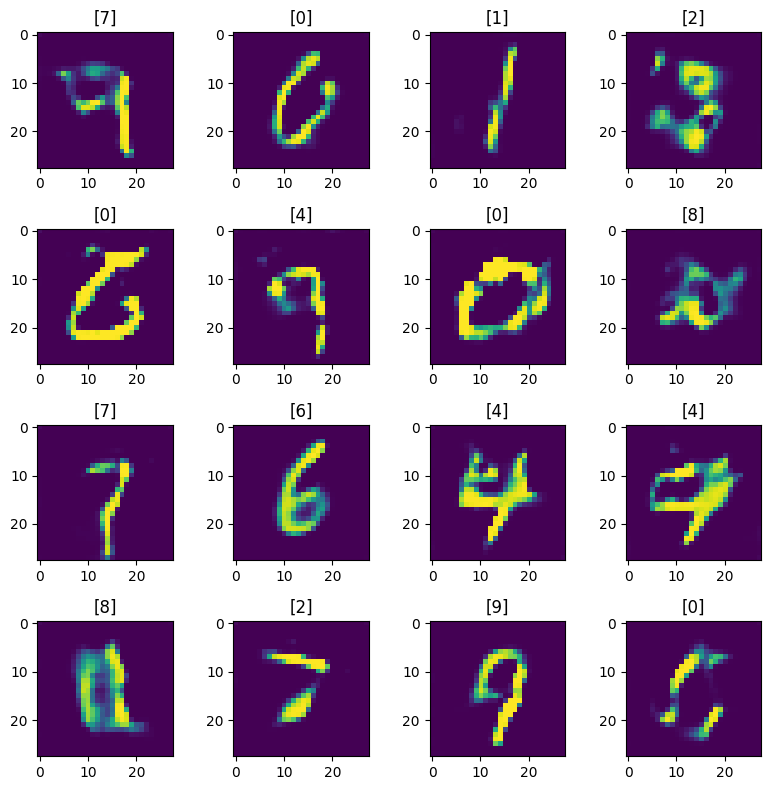

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.31790299713611603 [2.582392930984497, 0.125]
1/1 [==============================] - 0s 20ms/step


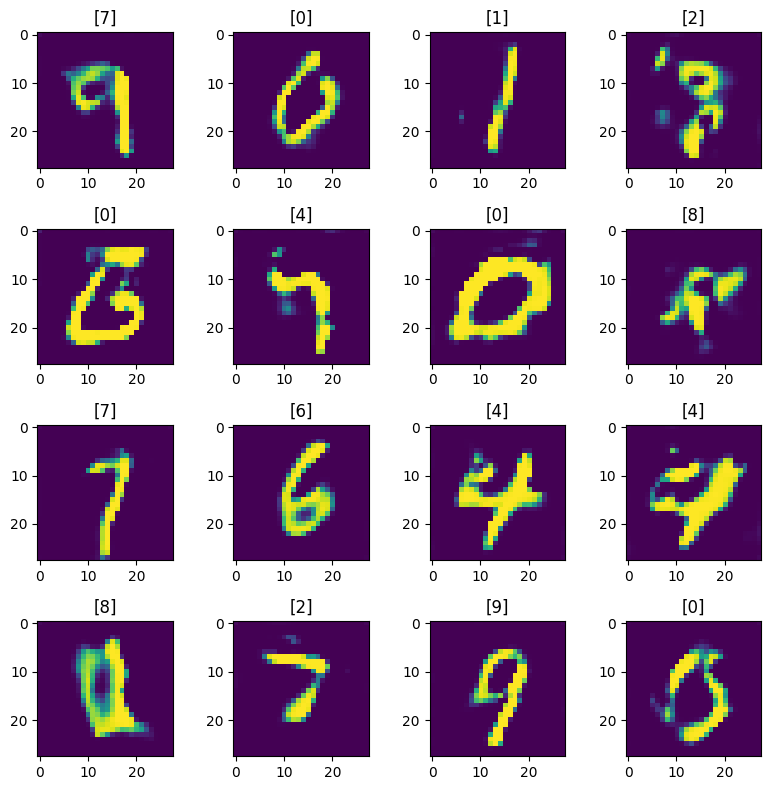

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.2950255870819092 [2.534777879714966, 0.0859375]
1/1 [==============================] - 0s 18ms/step


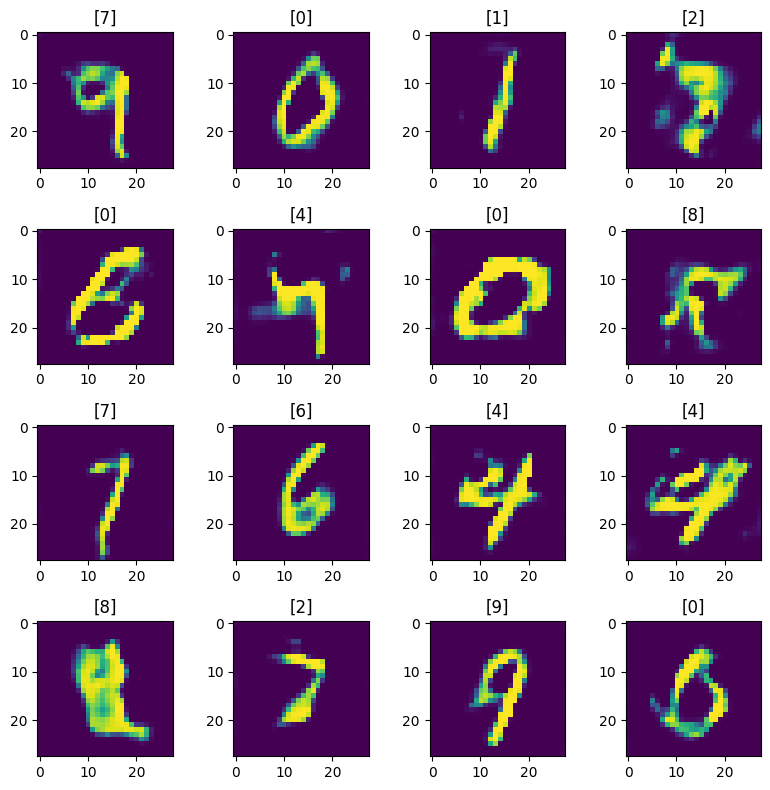

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.3624103367328644 [2.2293448448181152, 0.125]
1/1 [==============================] - 0s 26ms/step


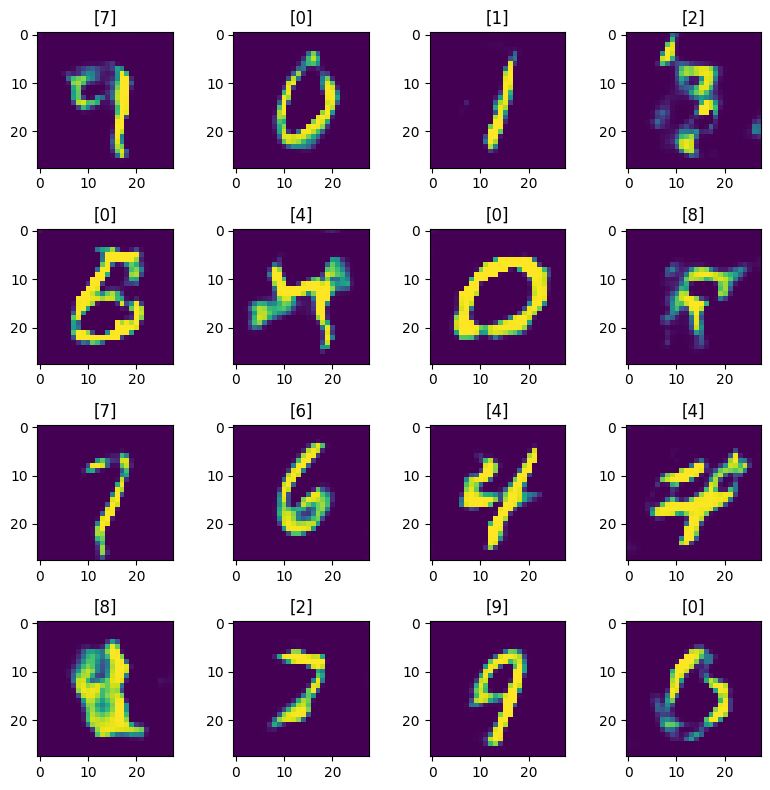

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.30188629031181335 [1.9490550756454468, 0.1796875]
1/1 [==============================] - 0s 18ms/step


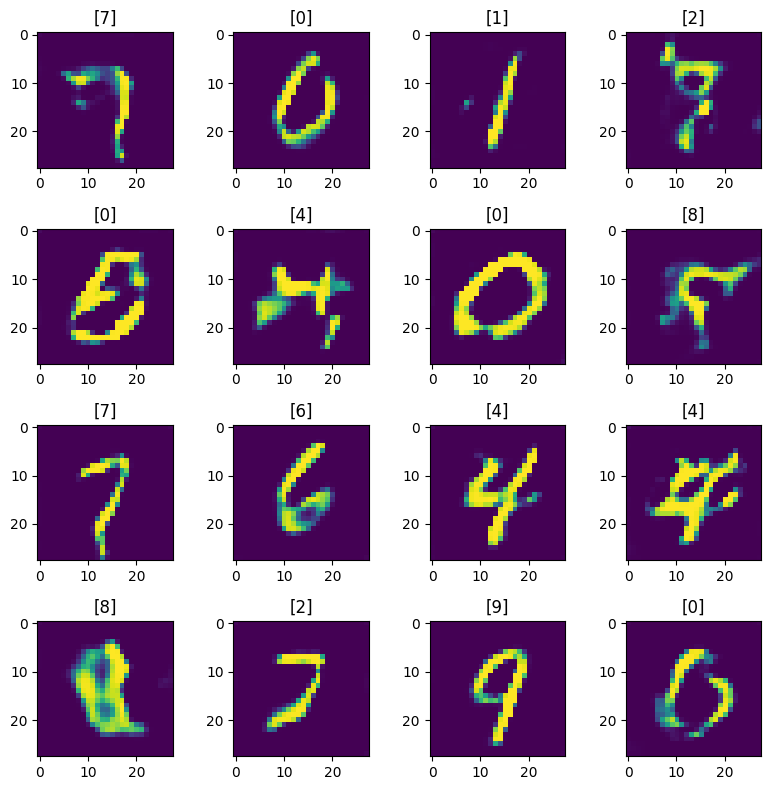

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.4217611849308014 [2.3537814617156982, 0.1328125]
1/1 [==============================] - 0s 19ms/step


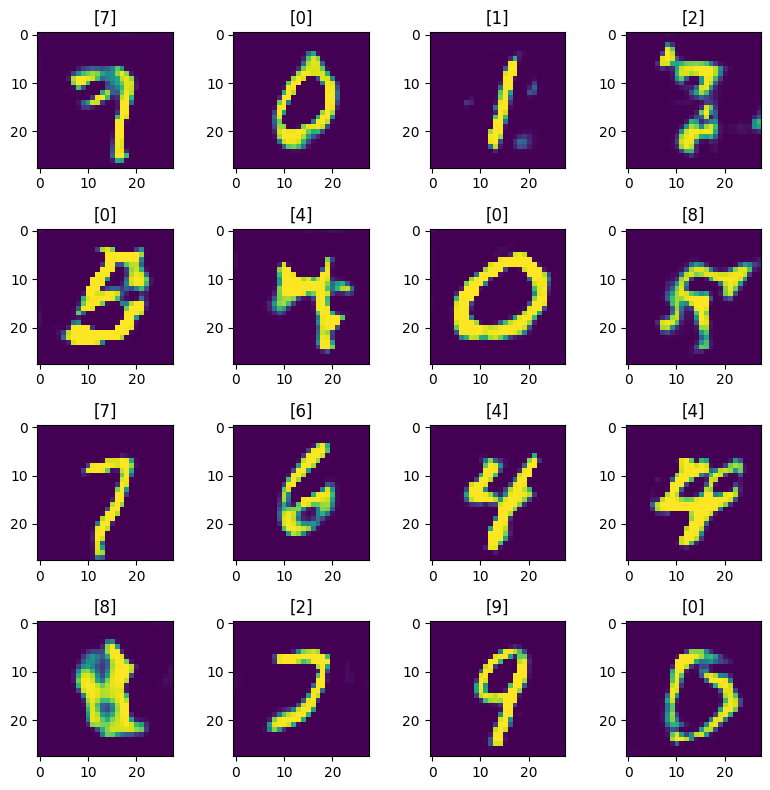

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.3519560694694519 [2.0274205207824707, 0.1171875]
1/1 [==============================] - 0s 23ms/step


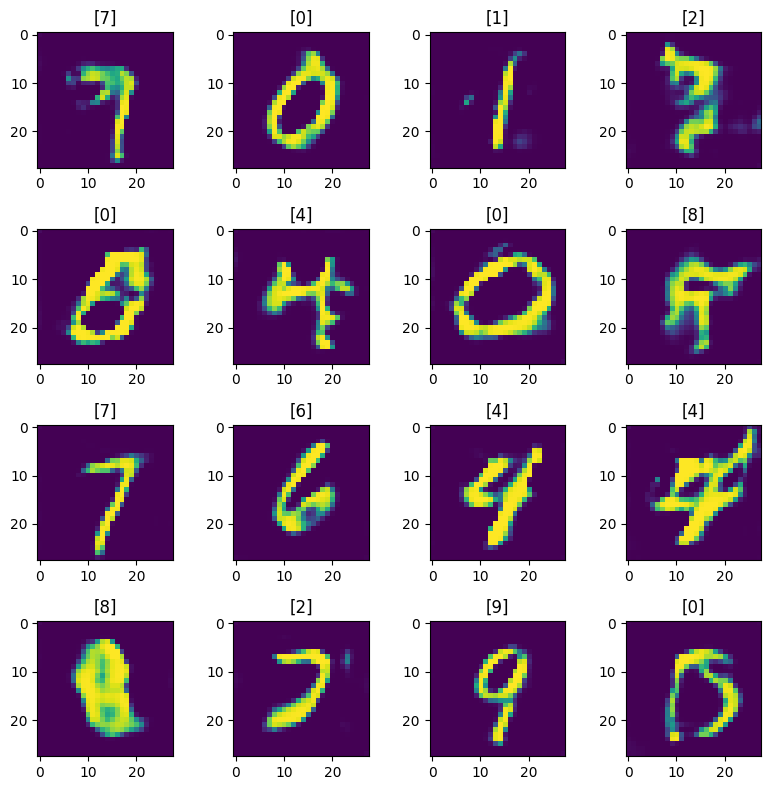

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.43570438027381897 [1.8175692558288574, 0.125]
1/1 [==============================] - 0s 19ms/step


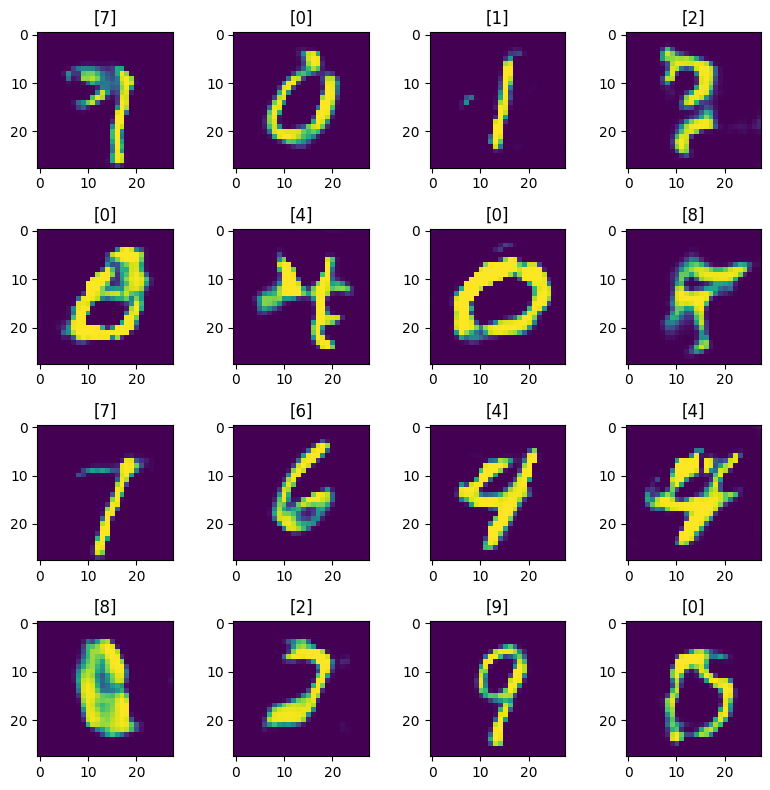

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.36827756464481354 [2.2533912658691406, 0.0703125]
1/1 [==============================] - 0s 19ms/step


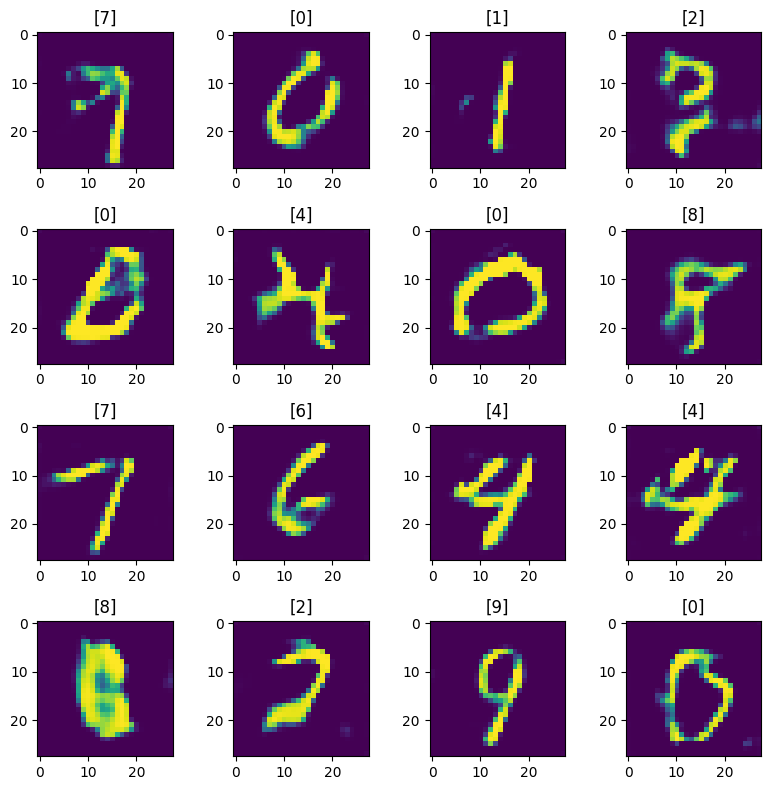

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.49331265687942505 [1.9118115901947021, 0.1328125]
1/1 [==============================] - 0s 20ms/step


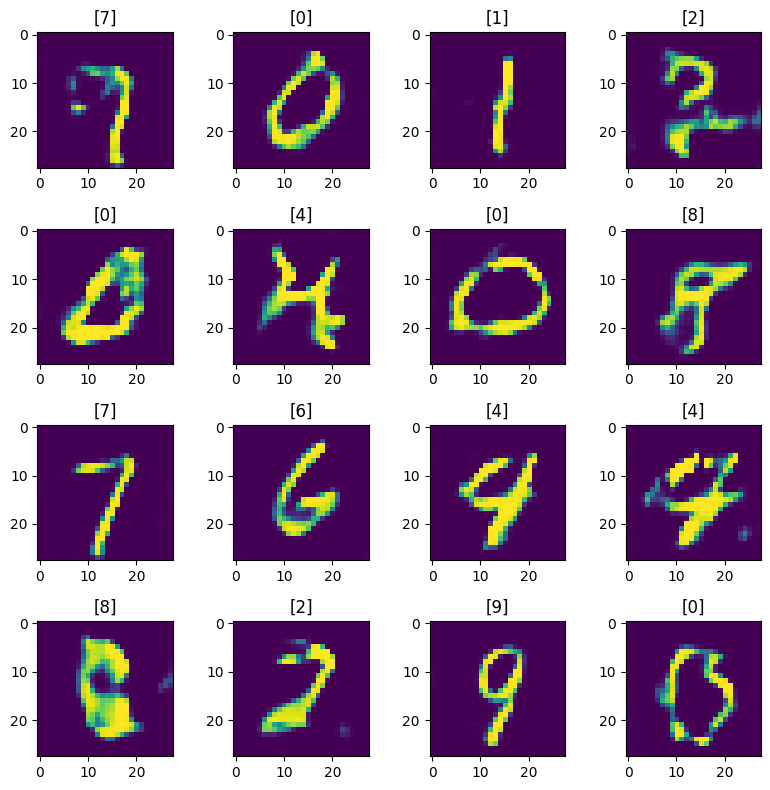

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.4261800944805145 [2.0713906288146973, 0.140625]
1/1 [==============================] - 0s 20ms/step


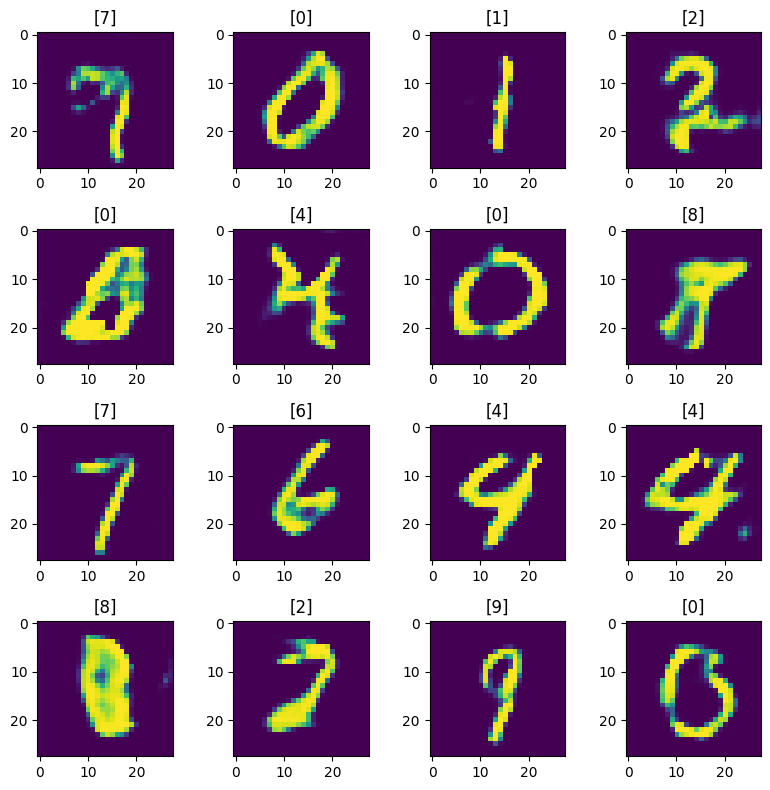

4/4 [==============================] - 0s 8ms/step
Losses(d,g): 0.4422312378883362 [2.114150285720825, 0.1484375]
1/1 [==============================] - 0s 44ms/step


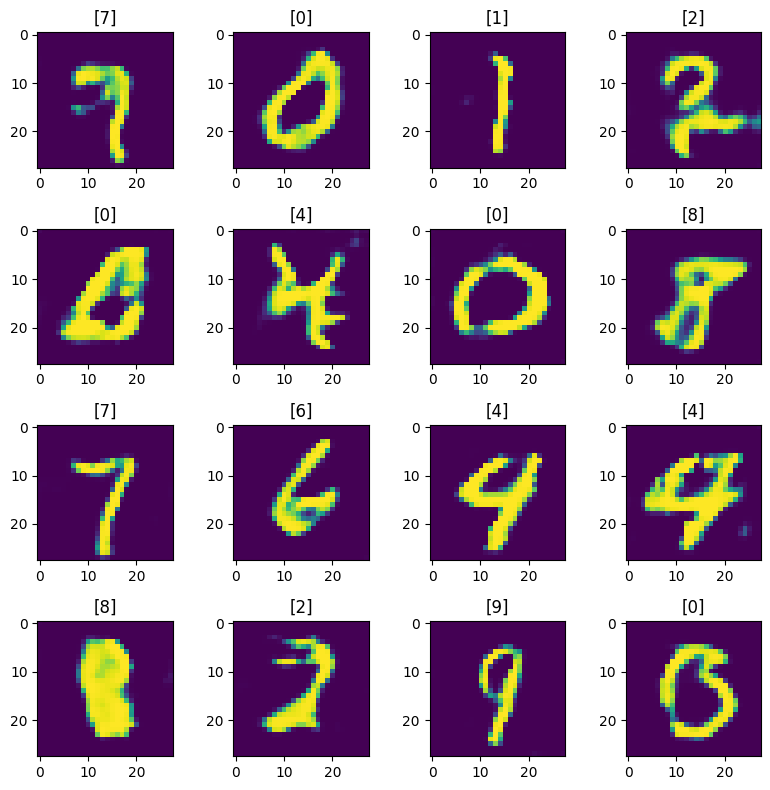

4/4 [==============================] - 0s 8ms/step
Losses(d,g): 0.48441751301288605 [1.3847427368164062, 0.234375]
1/1 [==============================] - 0s 52ms/step


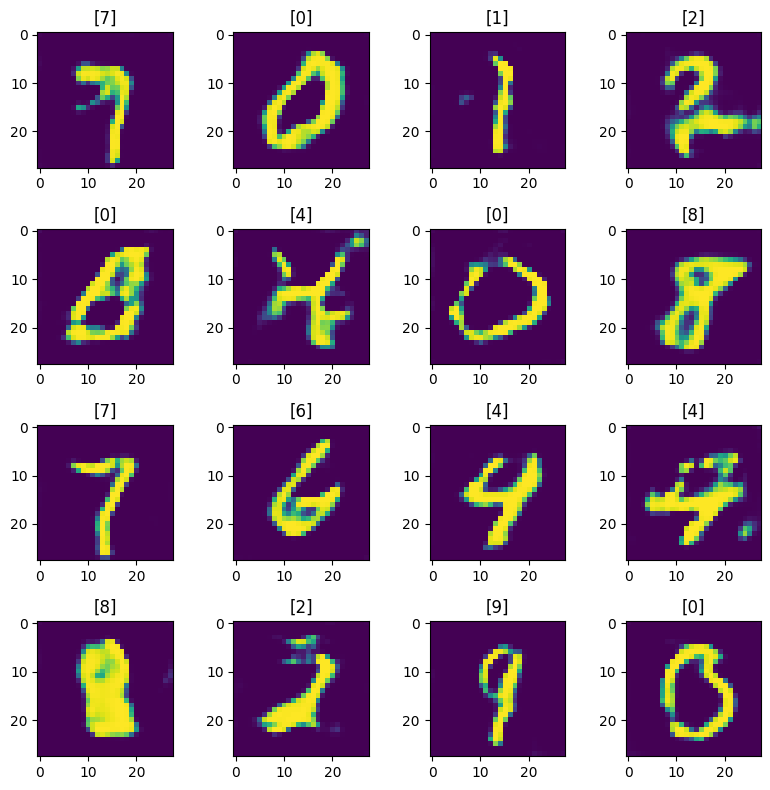

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.42067214846611023 [1.6788890361785889, 0.1796875]
1/1 [==============================] - 0s 20ms/step


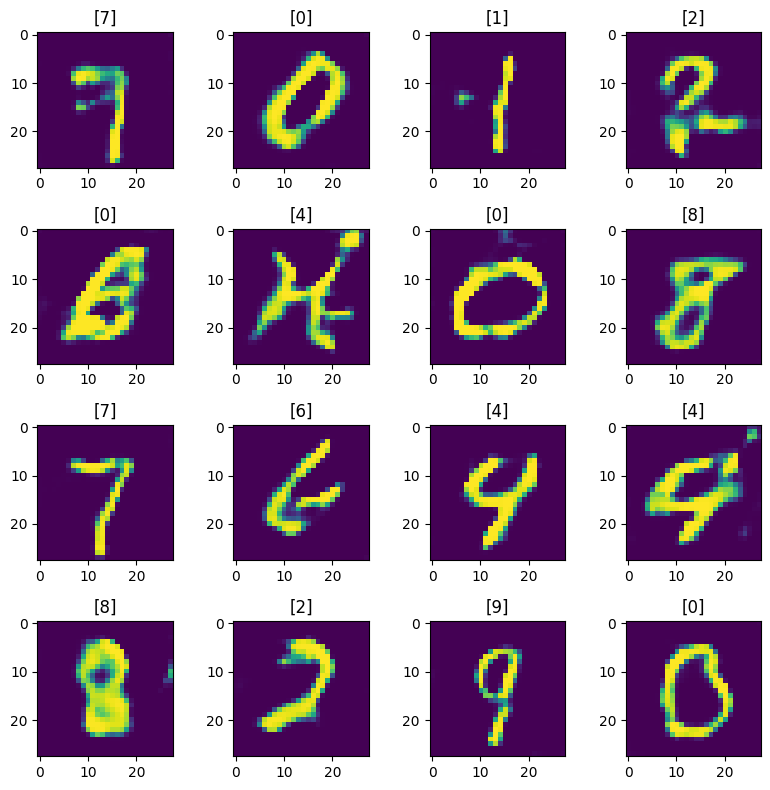

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.4651030898094177 [1.6755998134613037, 0.140625]
1/1 [==============================] - 0s 19ms/step


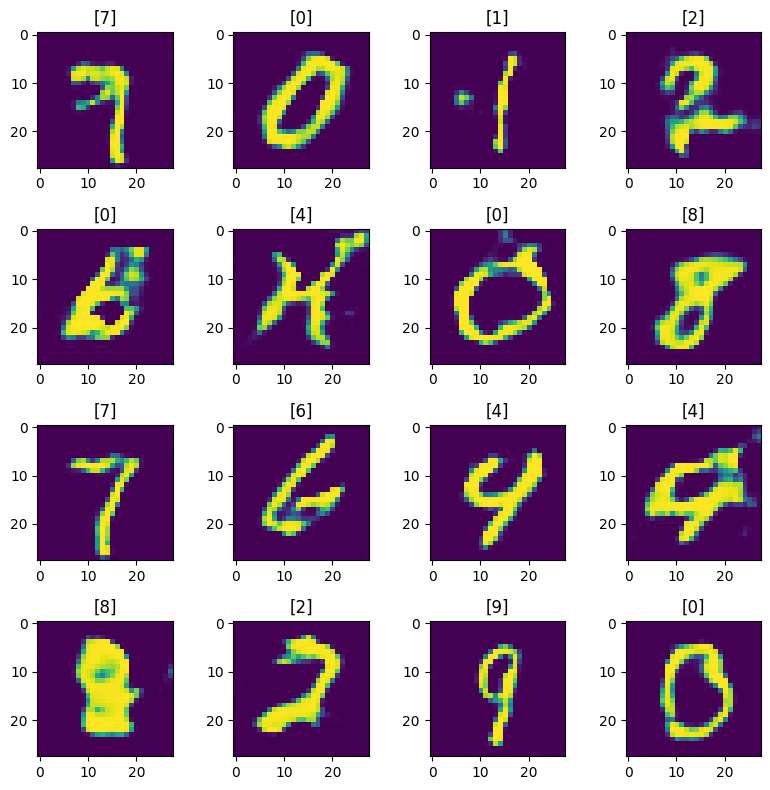

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.4613572955131531 [1.6636525392532349, 0.1328125]
1/1 [==============================] - 0s 36ms/step


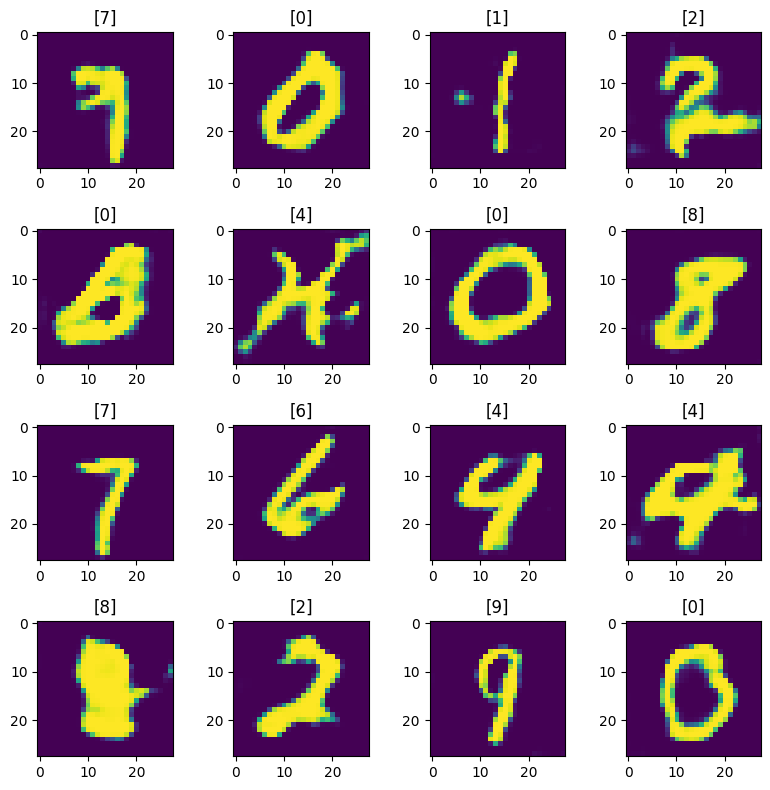

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.4187035411596298 [1.6102052927017212, 0.15625]
1/1 [==============================] - 0s 20ms/step


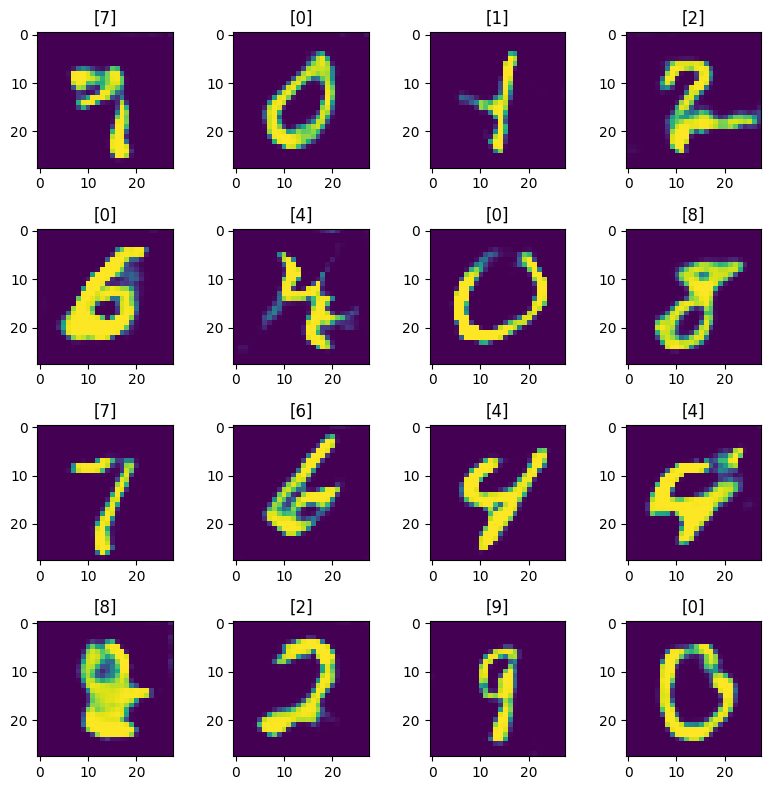

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5033284723758698 [1.844082236289978, 0.09375]
1/1 [==============================] - 0s 18ms/step


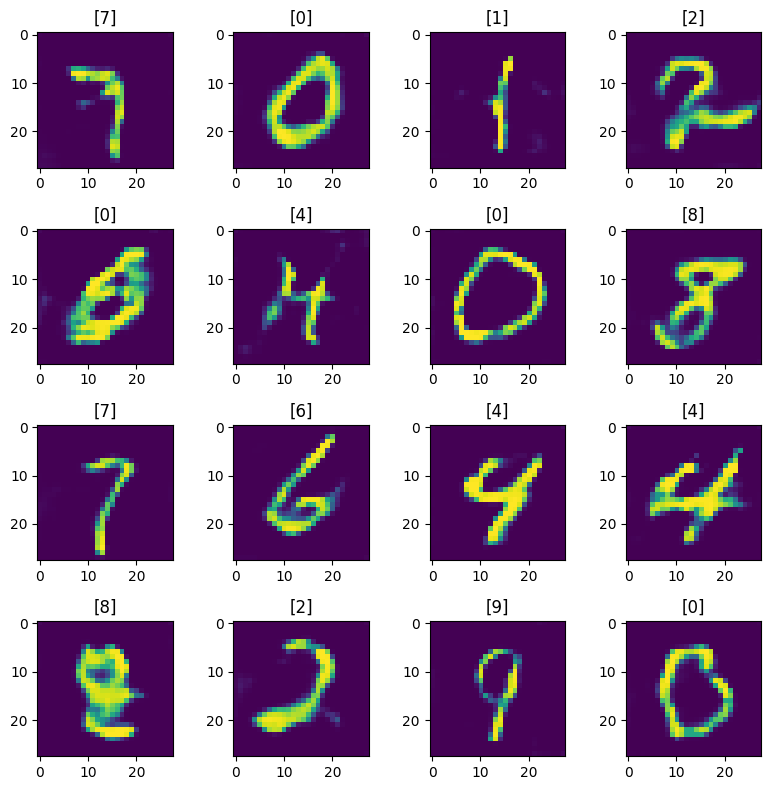

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5086333155632019 [1.4638245105743408, 0.2109375]
1/1 [==============================] - 0s 19ms/step


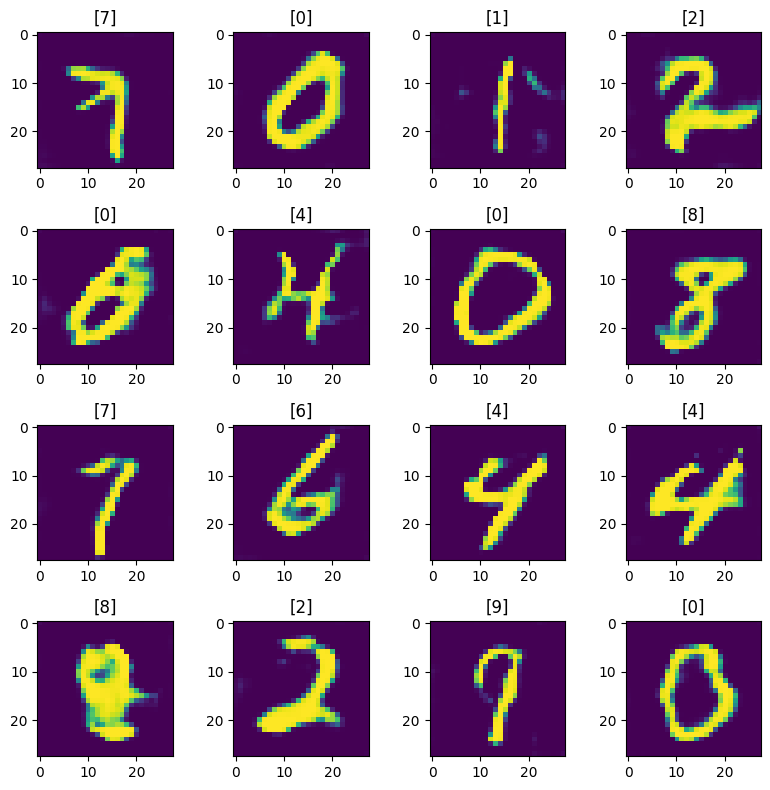

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6057855486869812 [1.085310459136963, 0.28125]
1/1 [==============================] - 0s 23ms/step


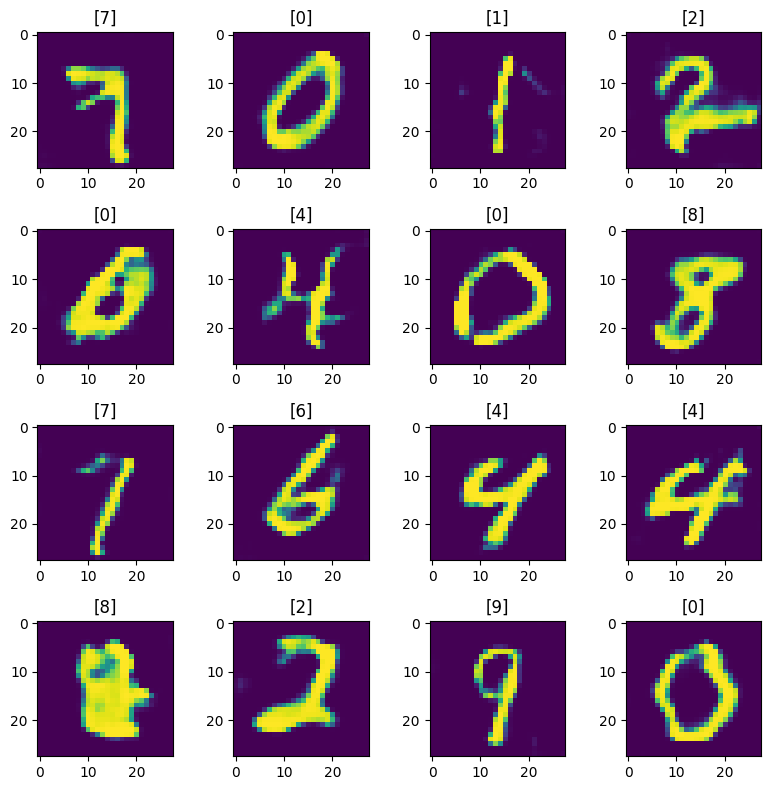

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5297524333000183 [1.365743637084961, 0.1484375]
1/1 [==============================] - 0s 18ms/step


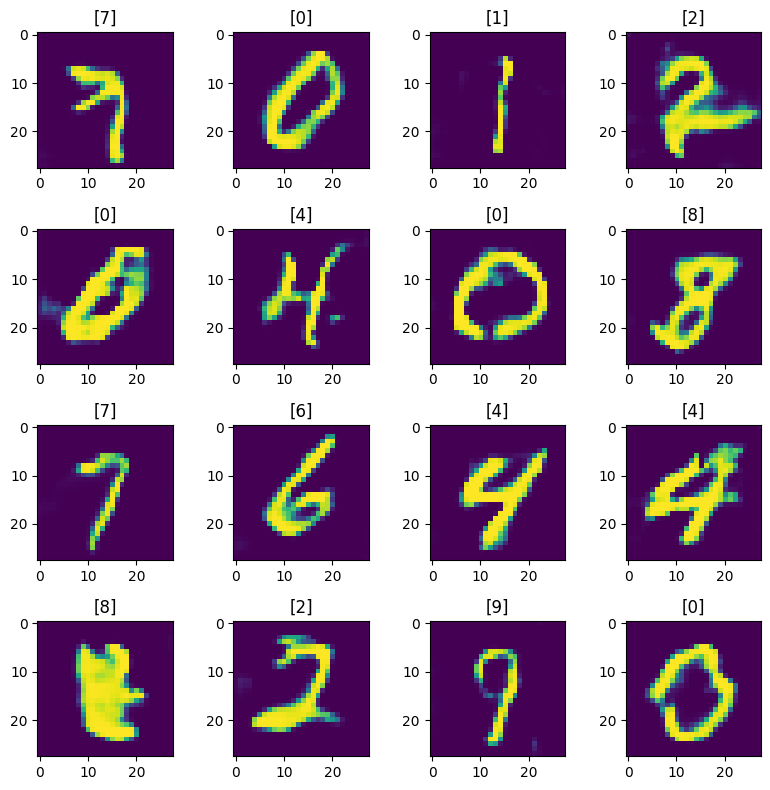

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.4851140081882477 [1.4868412017822266, 0.1015625]
1/1 [==============================] - 0s 20ms/step


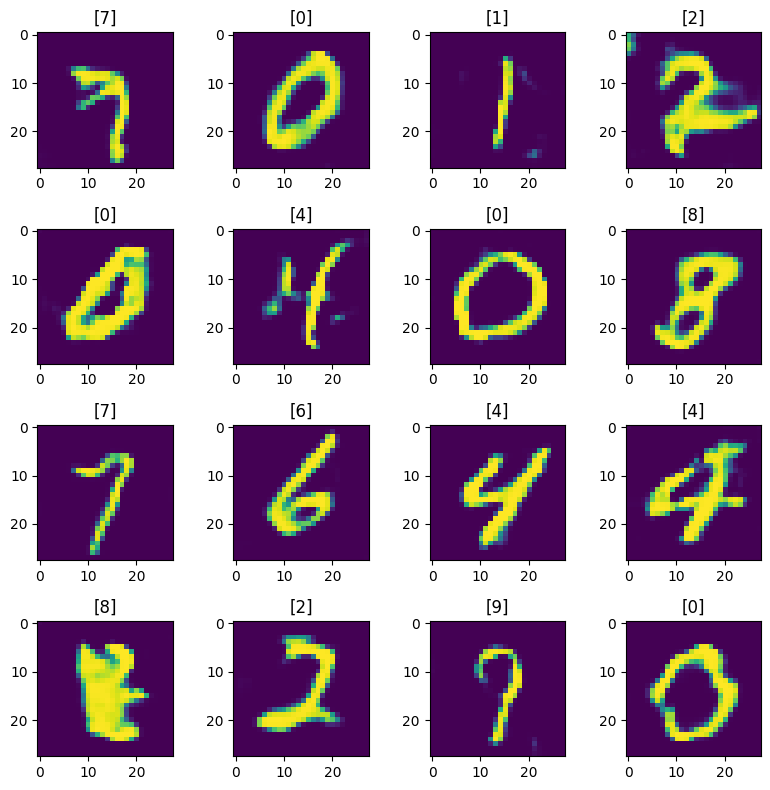

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5073234736919403 [1.38230562210083, 0.1953125]
1/1 [==============================] - 0s 18ms/step


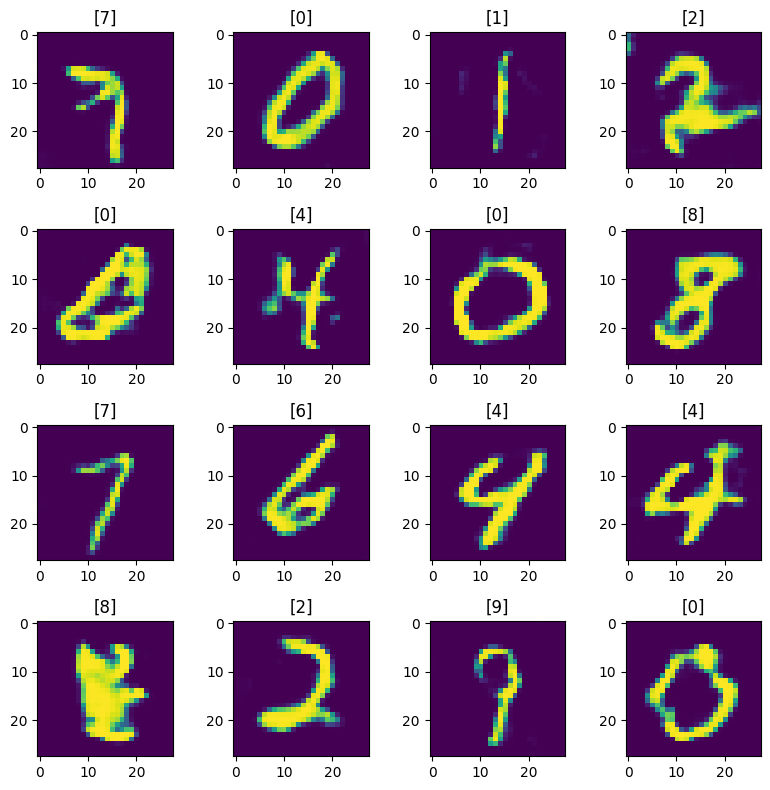

4/4 [==============================] - 0s 7ms/step
Losses(d,g): 0.48862913250923157 [1.5246679782867432, 0.203125]
1/1 [==============================] - 0s 21ms/step


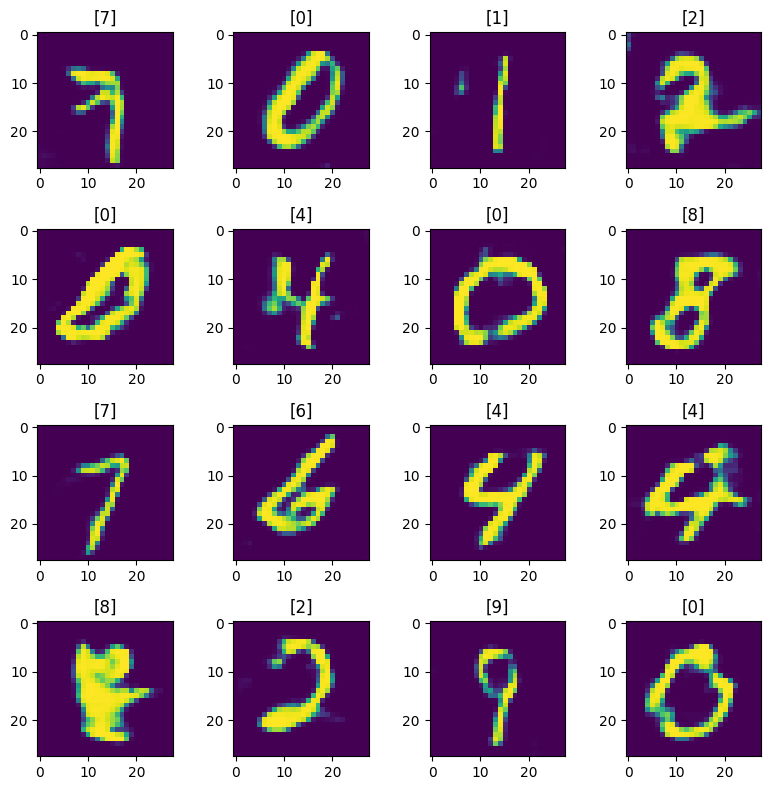

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5150087177753448 [1.3753331899642944, 0.2578125]
1/1 [==============================] - 0s 18ms/step


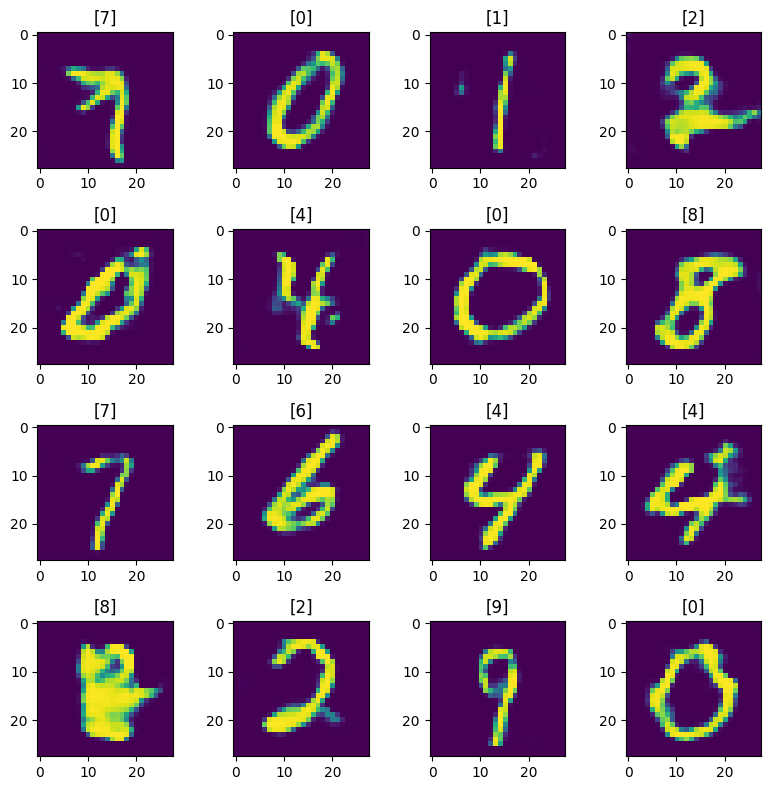

4/4 [==============================] - 0s 7ms/step
Losses(d,g): 0.5704383850097656 [1.1881734132766724, 0.2421875]
1/1 [==============================] - 0s 18ms/step


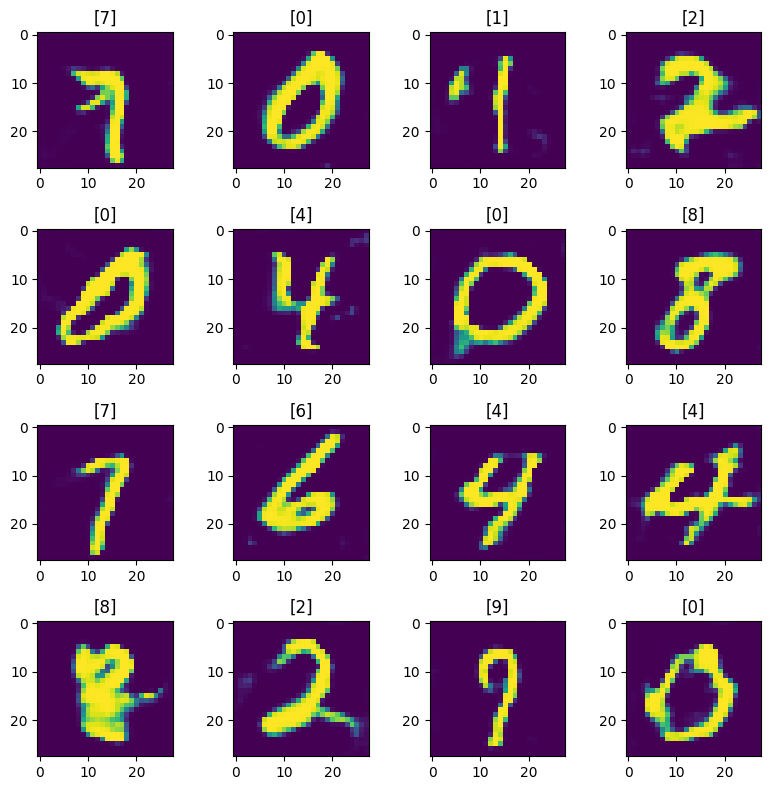

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.4750211834907532 [1.2483110427856445, 0.2421875]
1/1 [==============================] - 0s 19ms/step


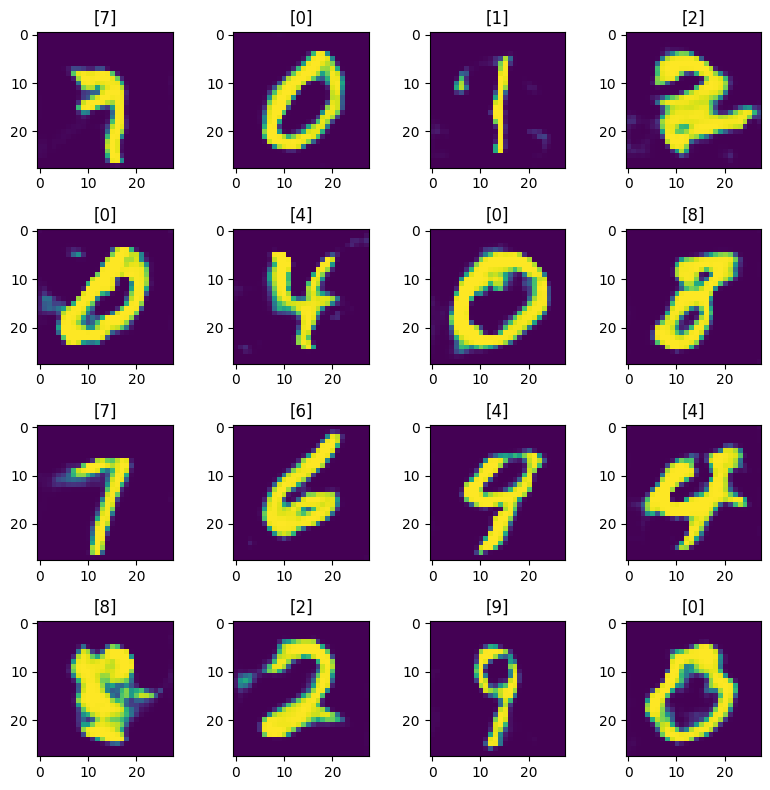

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.48339158296585083 [1.6618092060089111, 0.15625]
1/1 [==============================] - 0s 20ms/step


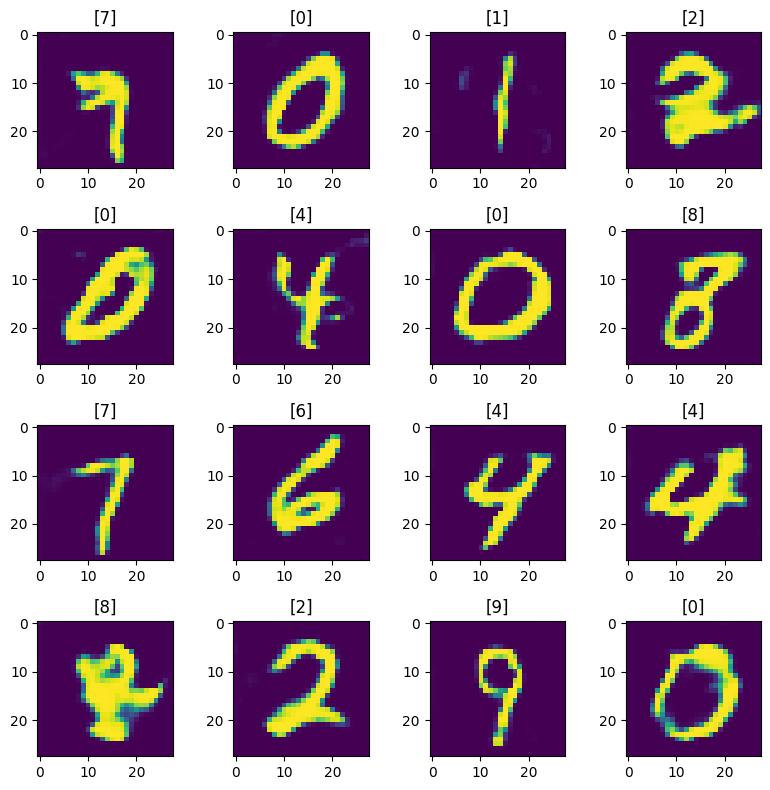

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5129421353340149 [1.3023210763931274, 0.203125]
1/1 [==============================] - 0s 18ms/step


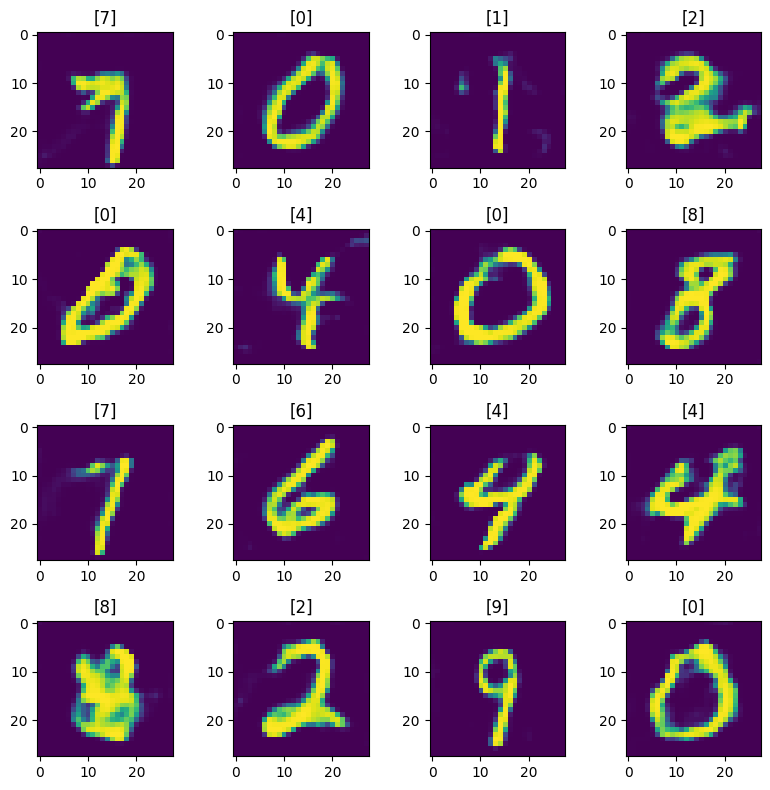

4/4 [==============================] - 0s 8ms/step
Losses(d,g): 0.5168491899967194 [1.1810593605041504, 0.2265625]
1/1 [==============================] - 0s 50ms/step


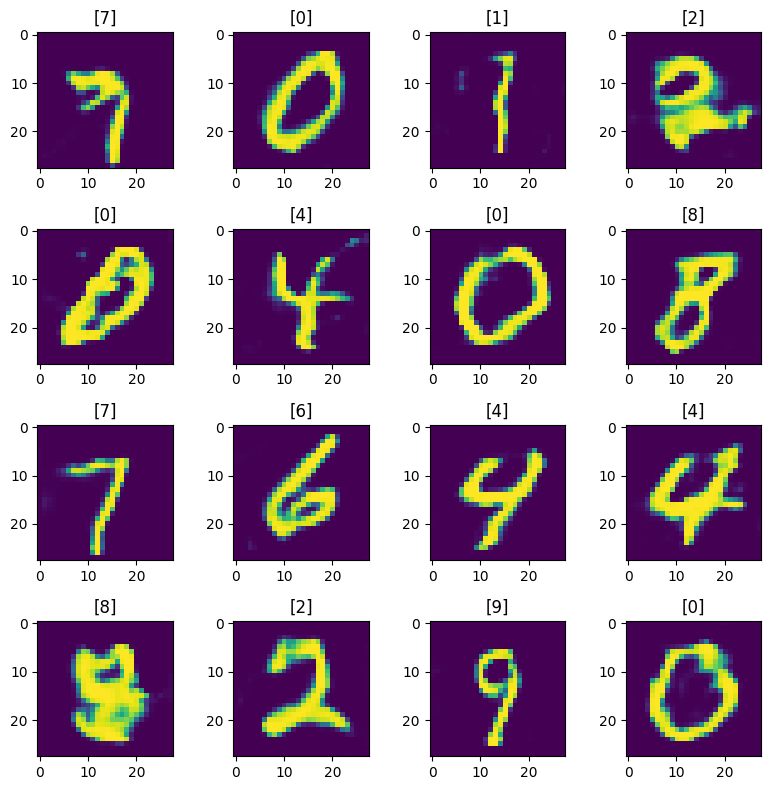

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5293967127799988 [1.2667131423950195, 0.2109375]
1/1 [==============================] - 0s 20ms/step


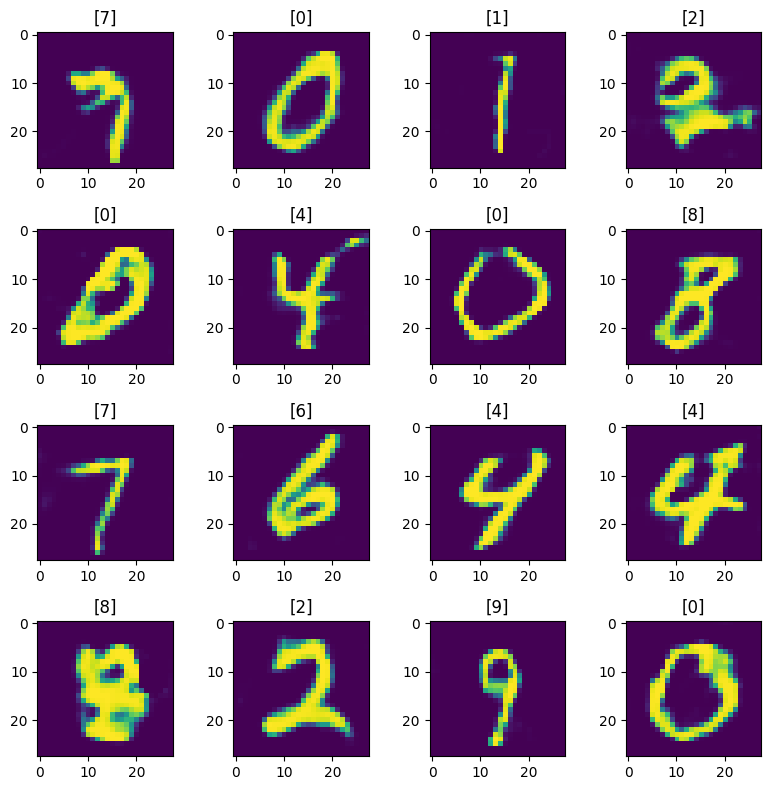

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5096334218978882 [1.1887978315353394, 0.203125]
1/1 [==============================] - 0s 19ms/step


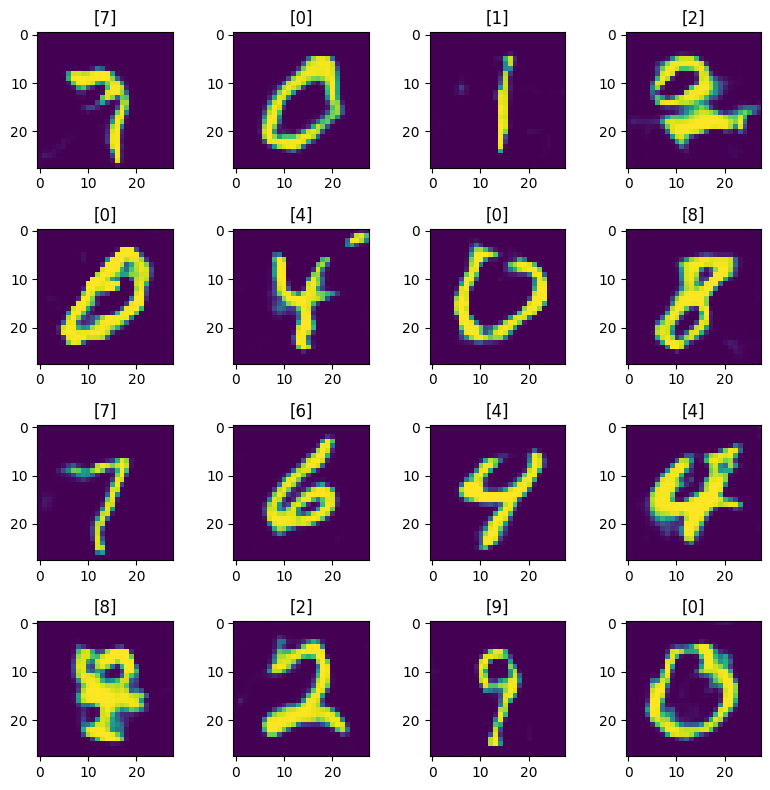

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5010775327682495 [1.4197238683700562, 0.171875]
1/1 [==============================] - 0s 19ms/step


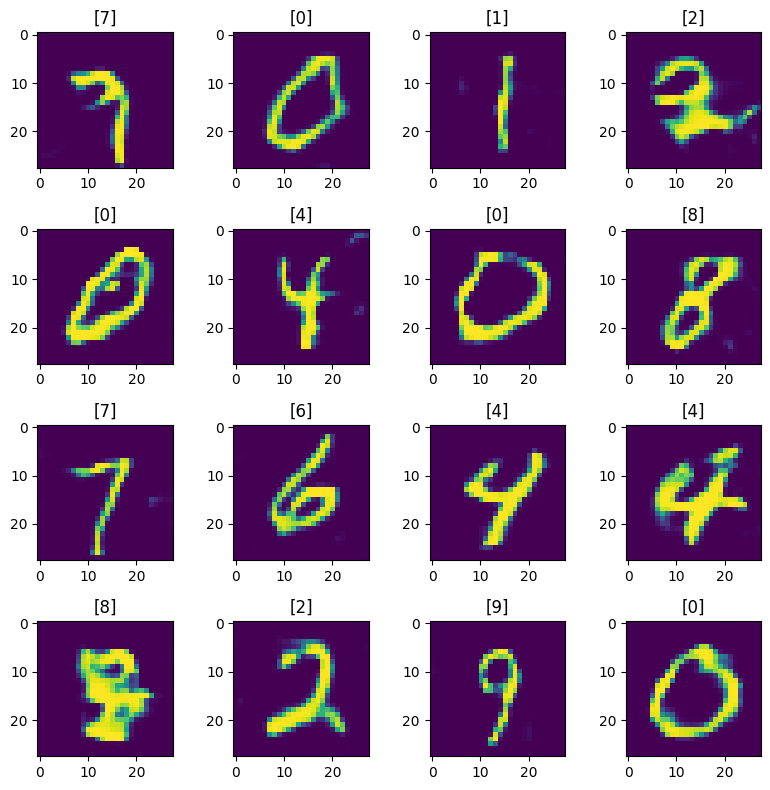

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.48526613414287567 [1.7659456729888916, 0.15625]
1/1 [==============================] - 0s 18ms/step


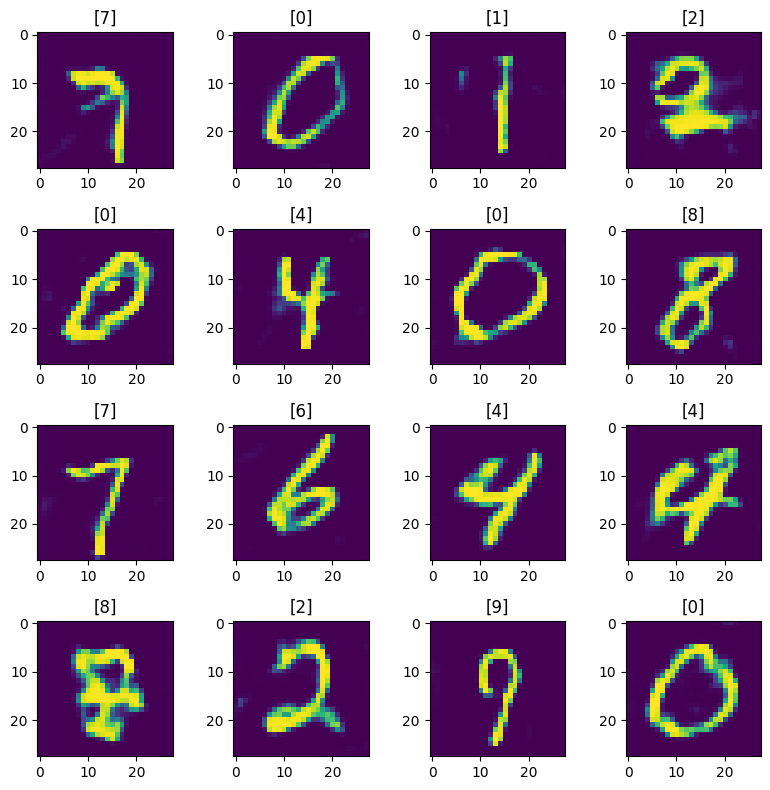

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5012872219085693 [1.3897724151611328, 0.2421875]
1/1 [==============================] - 0s 18ms/step


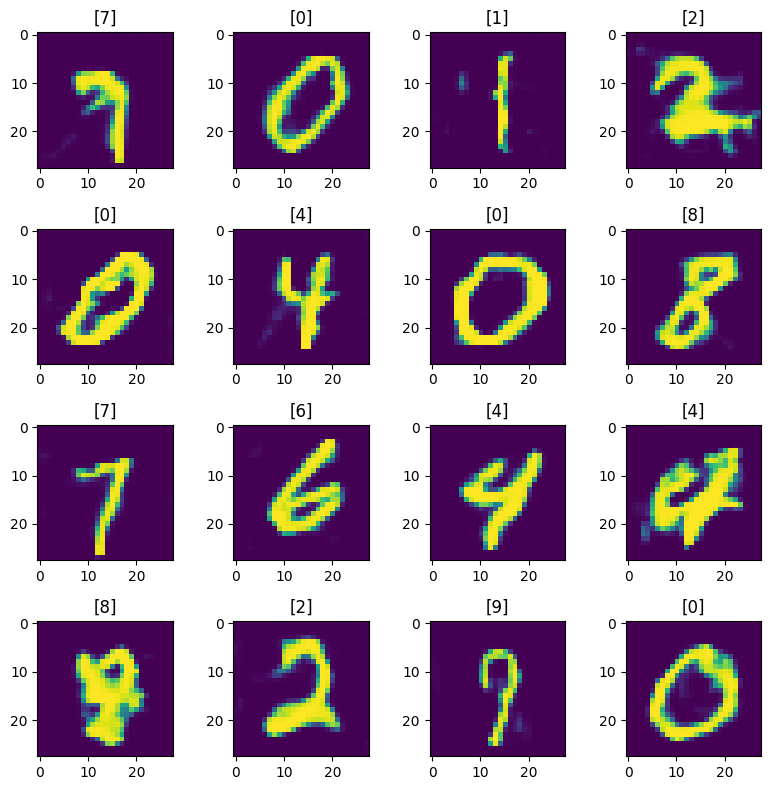

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5780177712440491 [1.1344997882843018, 0.171875]
1/1 [==============================] - 0s 18ms/step


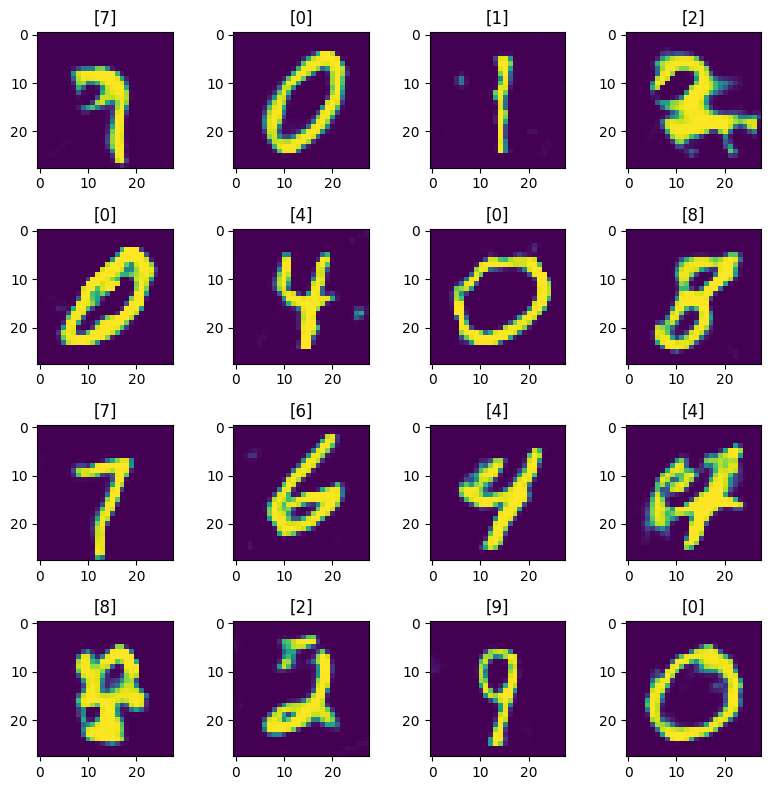

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.4902713894844055 [1.639437198638916, 0.125]
1/1 [==============================] - 0s 18ms/step


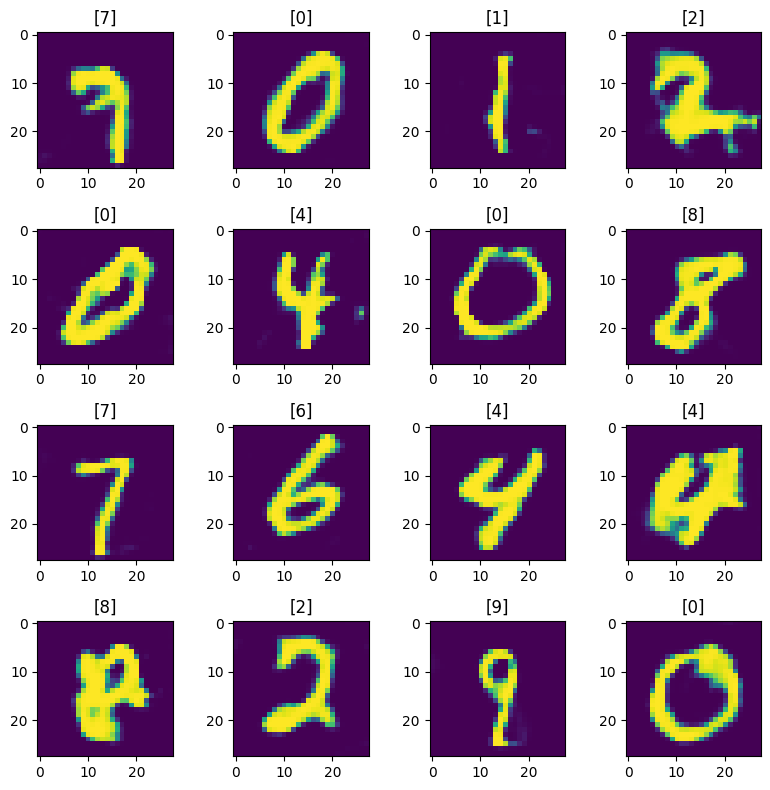

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.49276331067085266 [1.2375378608703613, 0.2265625]
1/1 [==============================] - 0s 18ms/step


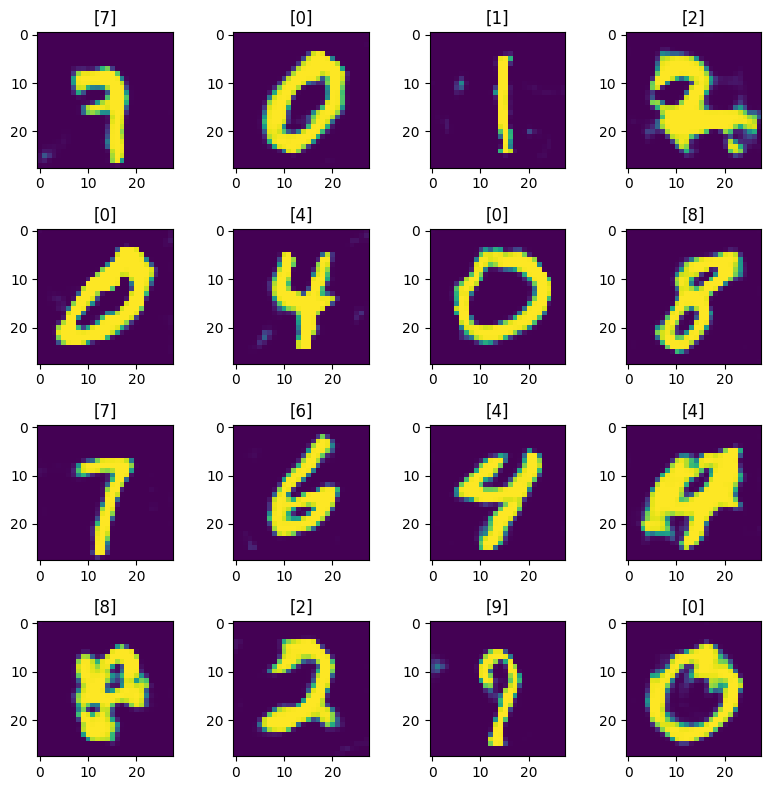

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.48637983202934265 [1.4046883583068848, 0.1484375]
1/1 [==============================] - 0s 22ms/step


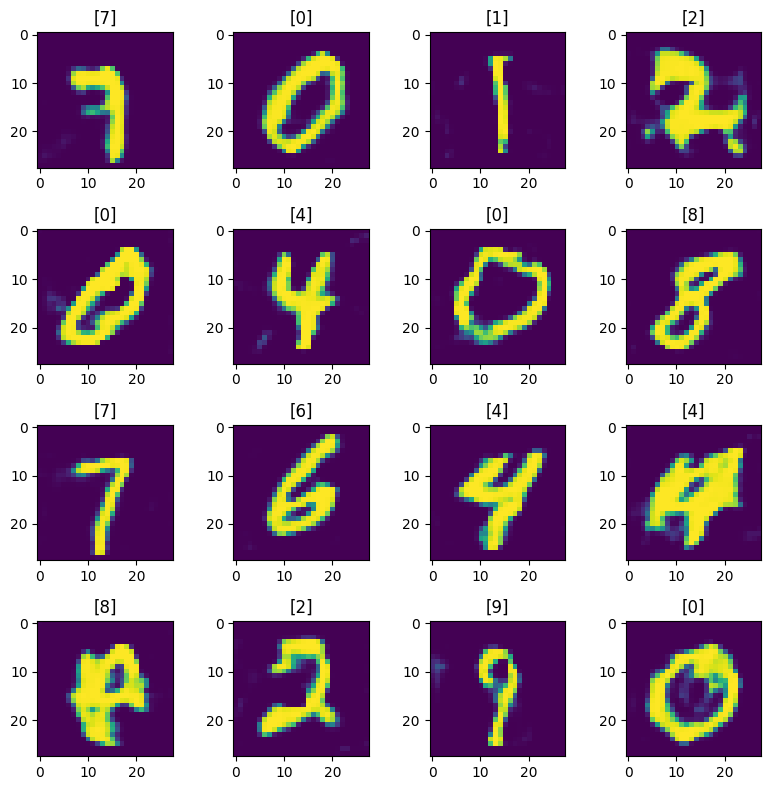

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5064719766378403 [1.2376086711883545, 0.2265625]
1/1 [==============================] - 0s 19ms/step


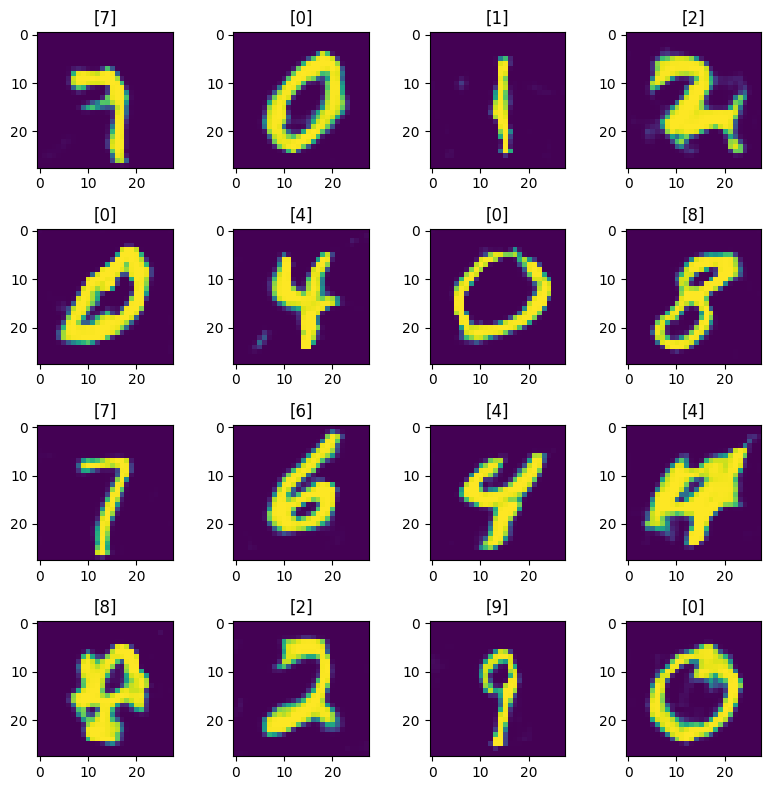

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.630648136138916 [1.158332109451294, 0.2421875]
1/1 [==============================] - 0s 26ms/step


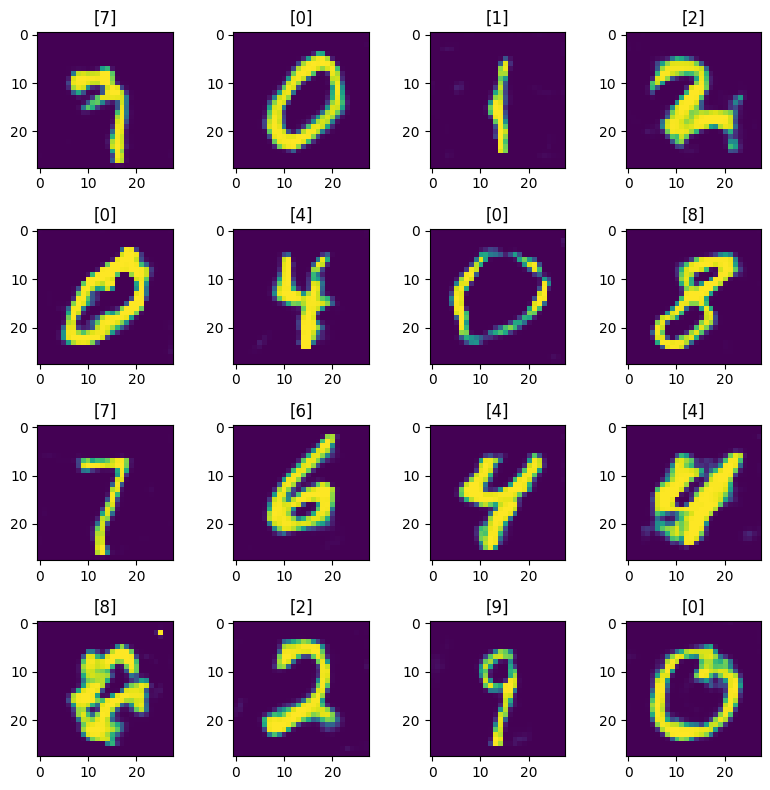

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5264557600021362 [1.5177215337753296, 0.1484375]
1/1 [==============================] - 0s 23ms/step


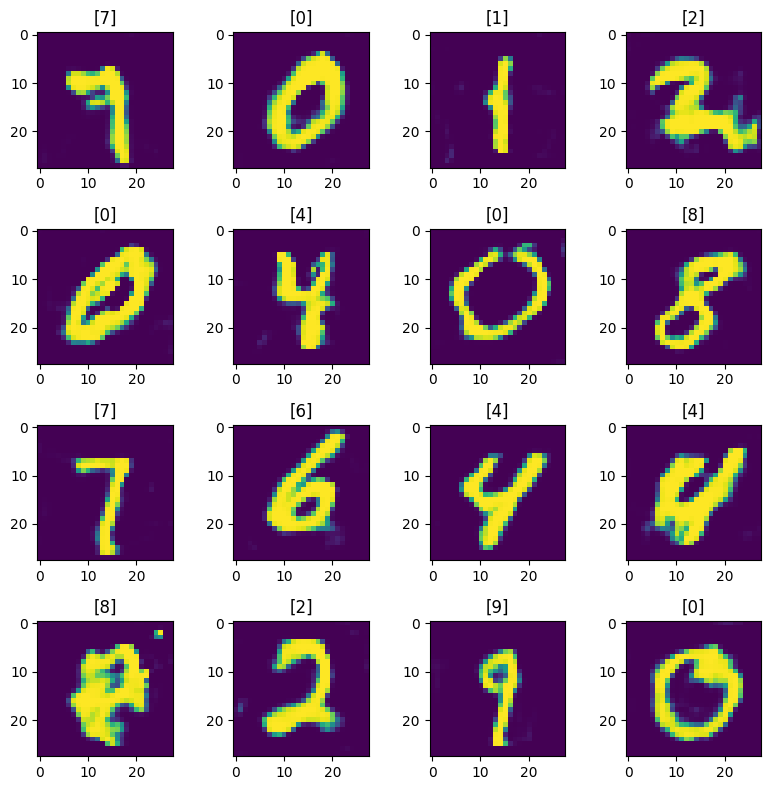

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6042381525039673 [1.1541473865509033, 0.2734375]
1/1 [==============================] - 0s 18ms/step


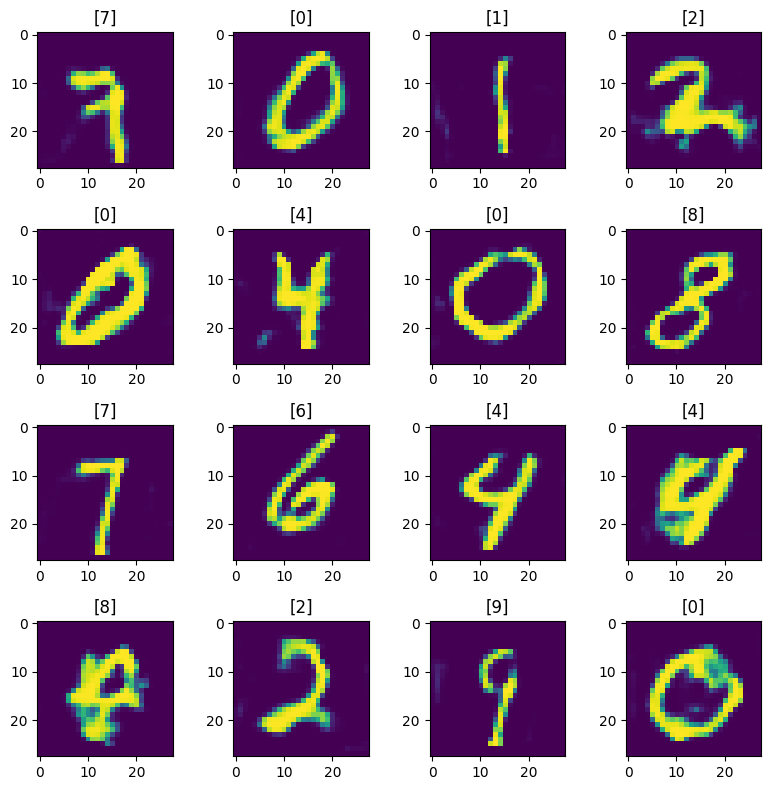

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5307150185108185 [1.3711788654327393, 0.2109375]
1/1 [==============================] - 0s 19ms/step


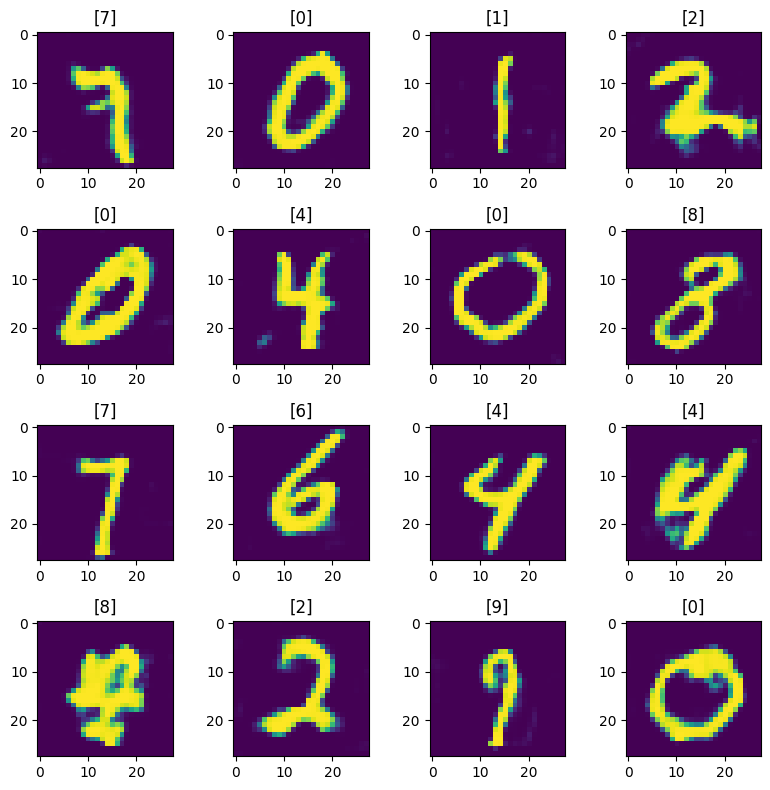

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.5349170565605164 [1.1610028743743896, 0.3359375]
1/1 [==============================] - 0s 17ms/step


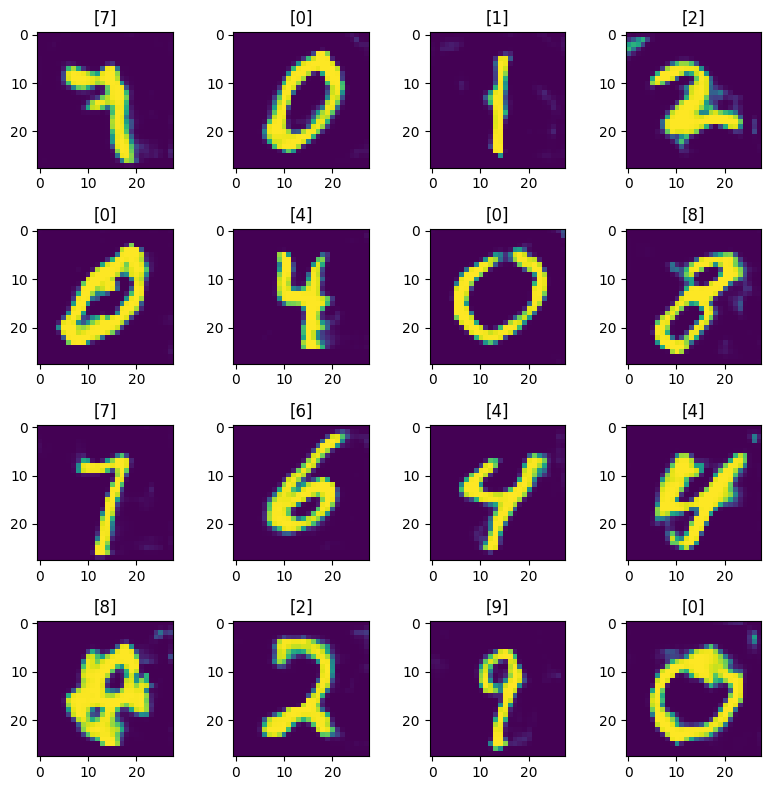

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.570648729801178 [1.2094578742980957, 0.2109375]
1/1 [==============================] - 0s 18ms/step


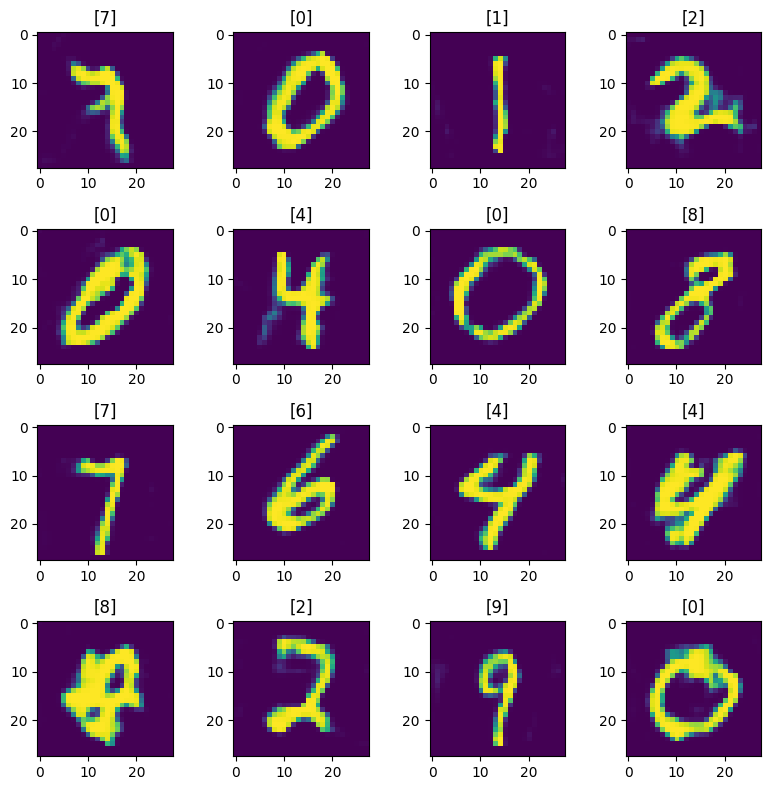

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5818522870540619 [1.1602892875671387, 0.25]
1/1 [==============================] - 0s 41ms/step


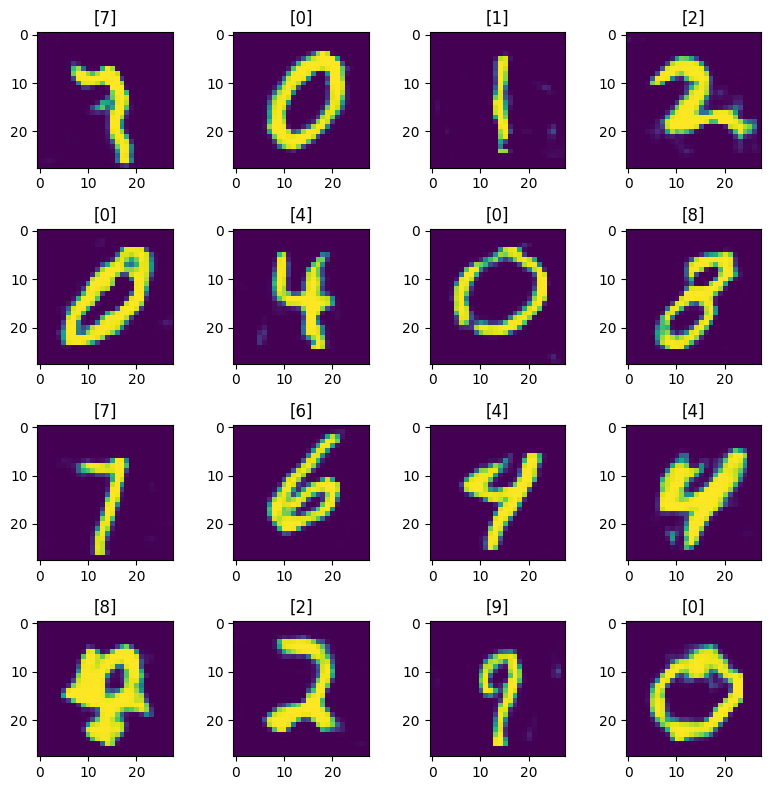

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.6209160685539246 [1.097022294998169, 0.3046875]
1/1 [==============================] - 0s 18ms/step


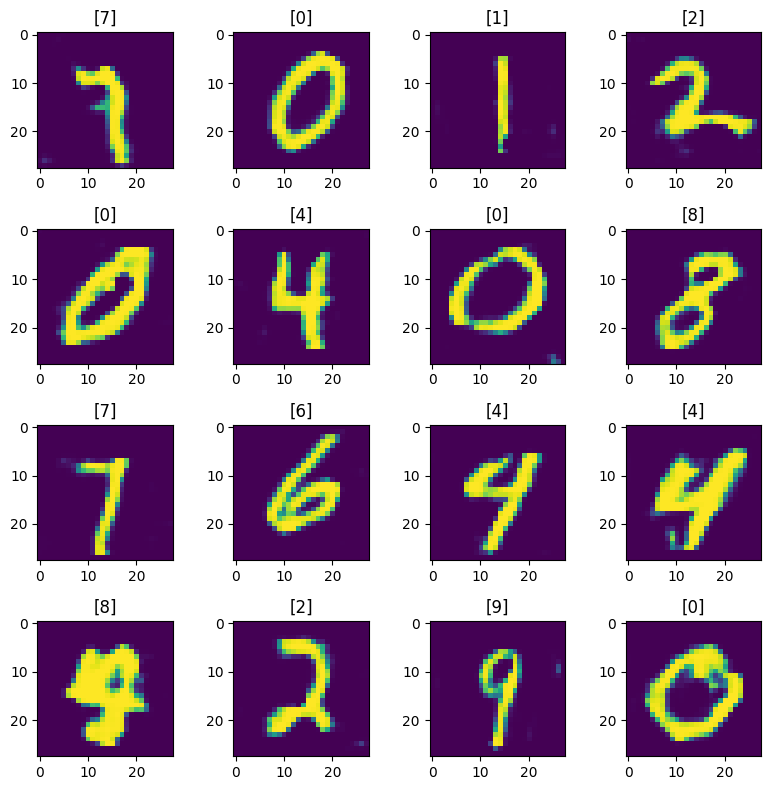

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5220496952533722 [1.3540551662445068, 0.1953125]
1/1 [==============================] - 0s 18ms/step


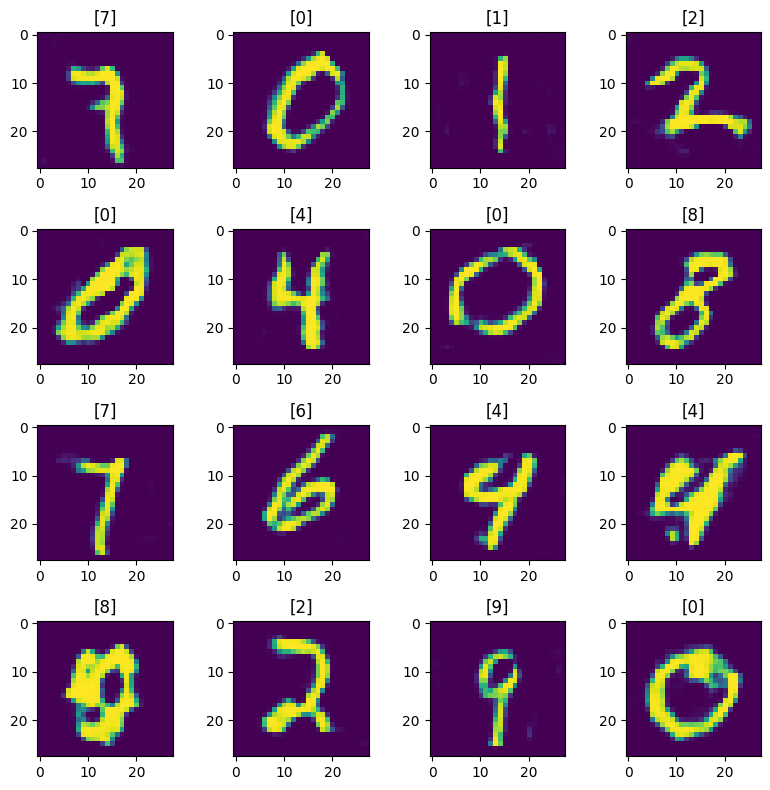

4/4 [==============================] - 0s 8ms/step
Losses(d,g): 0.6643509566783905 [1.0058274269104004, 0.390625]
1/1 [==============================] - 0s 44ms/step


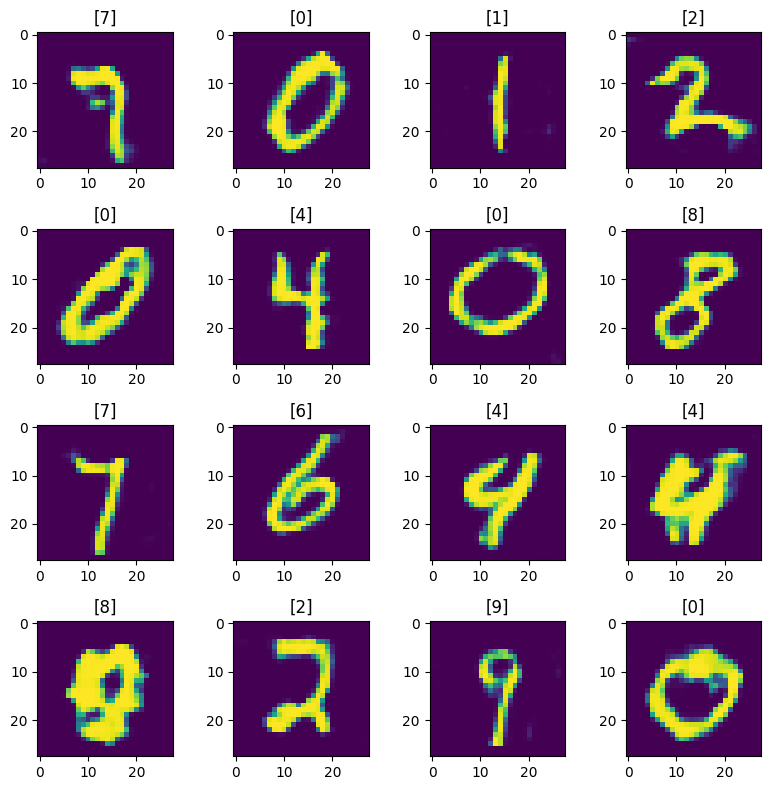

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5688329041004181 [1.0122476816177368, 0.3125]
1/1 [==============================] - 0s 18ms/step


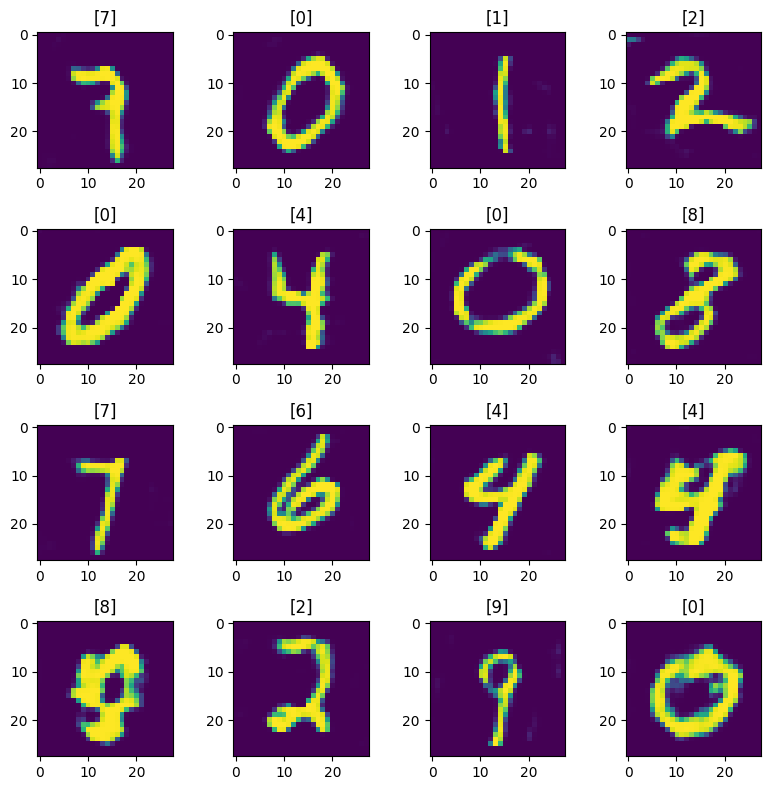

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.548718050122261 [1.3460290431976318, 0.2265625]
1/1 [==============================] - 0s 18ms/step


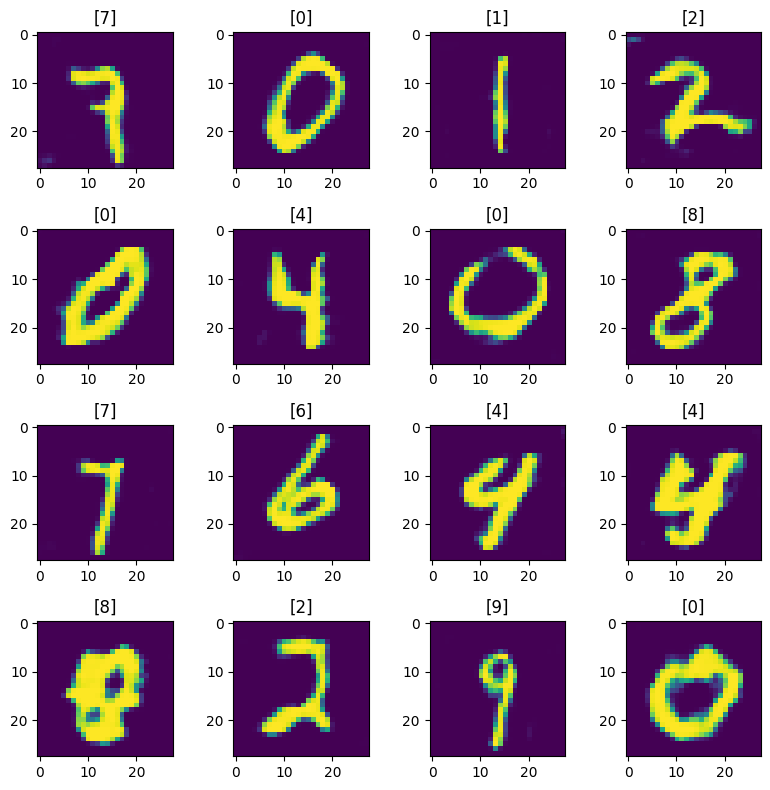

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5857303142547607 [1.2375576496124268, 0.2265625]
1/1 [==============================] - 0s 66ms/step


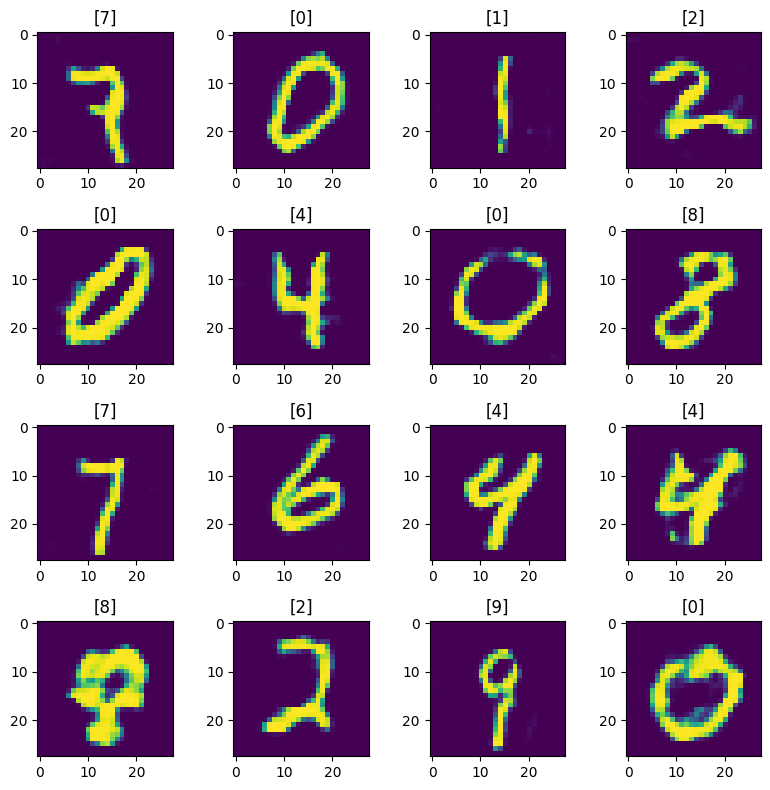

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5969594717025757 [1.1072272062301636, 0.2578125]
1/1 [==============================] - 0s 18ms/step


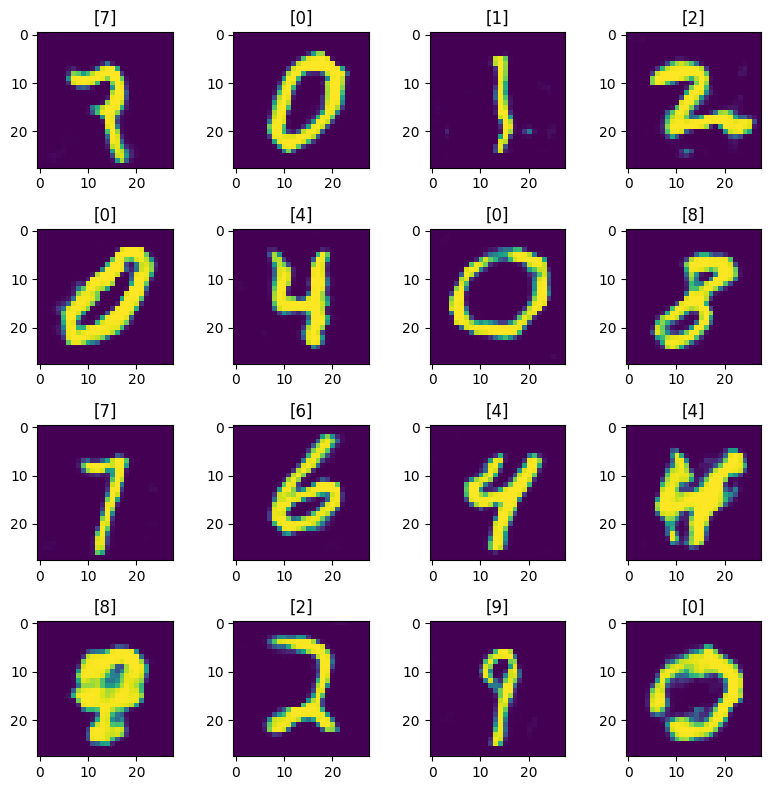

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.605700820684433 [1.1140779256820679, 0.3046875]
1/1 [==============================] - 0s 20ms/step


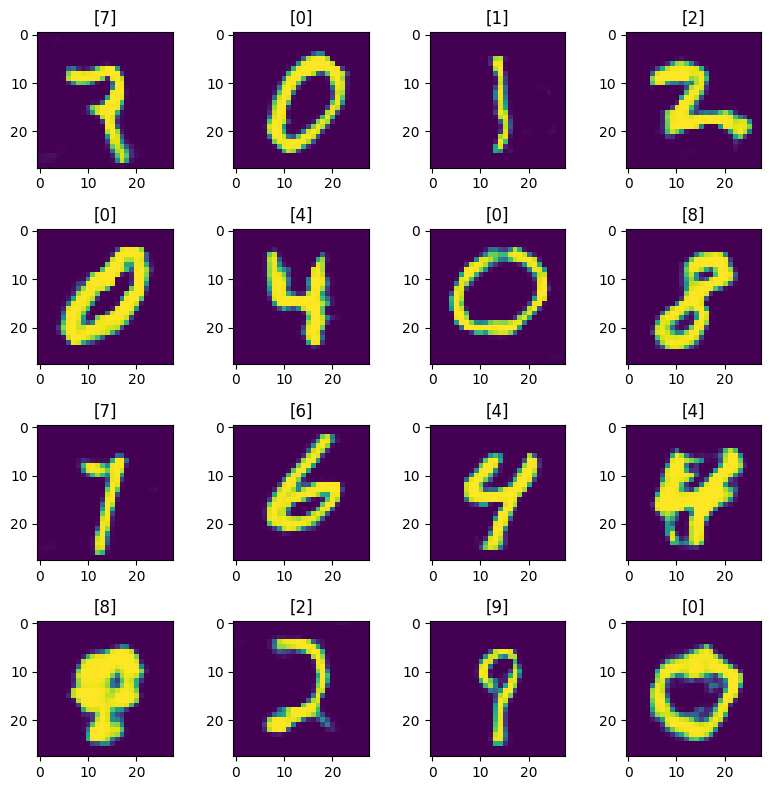

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5579696297645569 [1.1616920232772827, 0.234375]
1/1 [==============================] - 0s 18ms/step


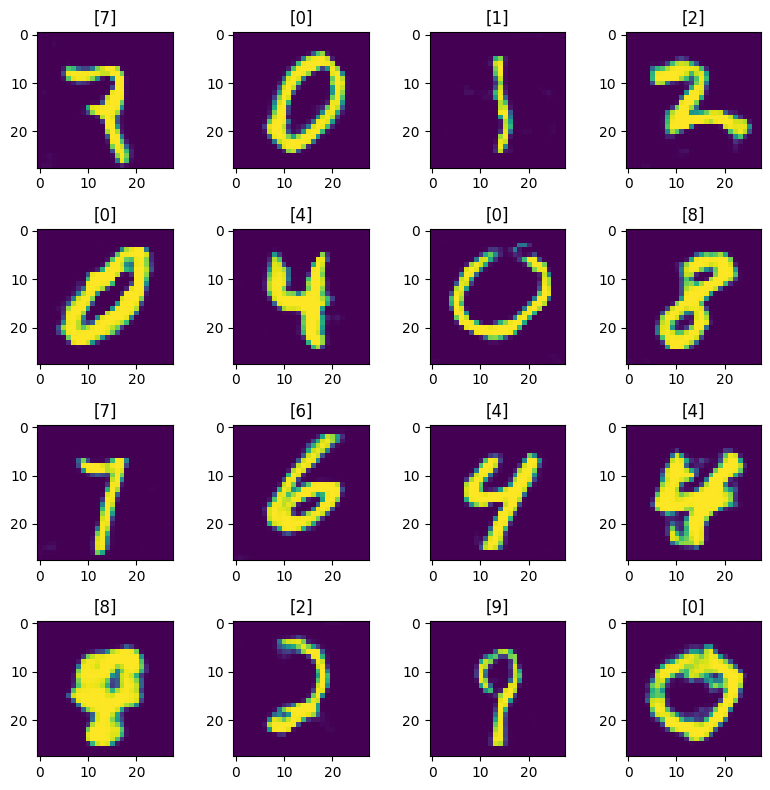

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5797860622406006 [1.119696021080017, 0.2421875]
1/1 [==============================] - 0s 19ms/step


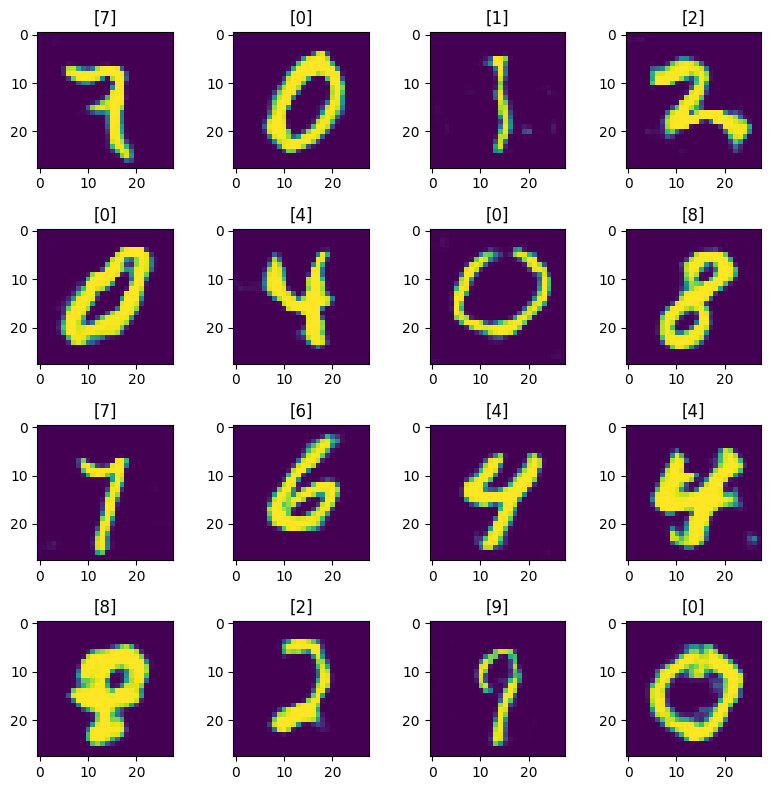

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5697303712368011 [1.1571792364120483, 0.171875]
1/1 [==============================] - 0s 19ms/step


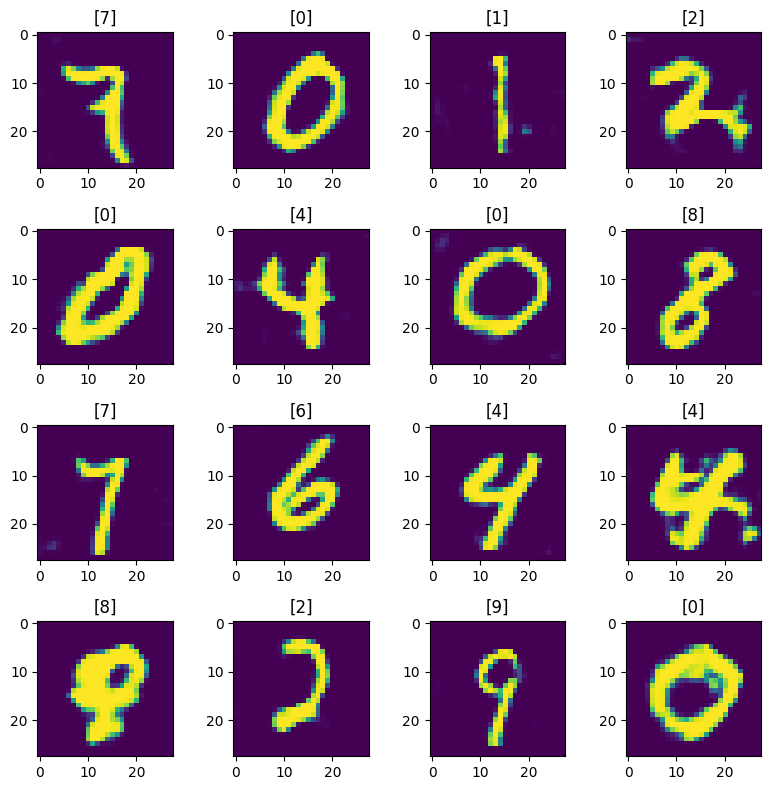

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.583305299282074 [1.1684694290161133, 0.21875]
1/1 [==============================] - 0s 19ms/step


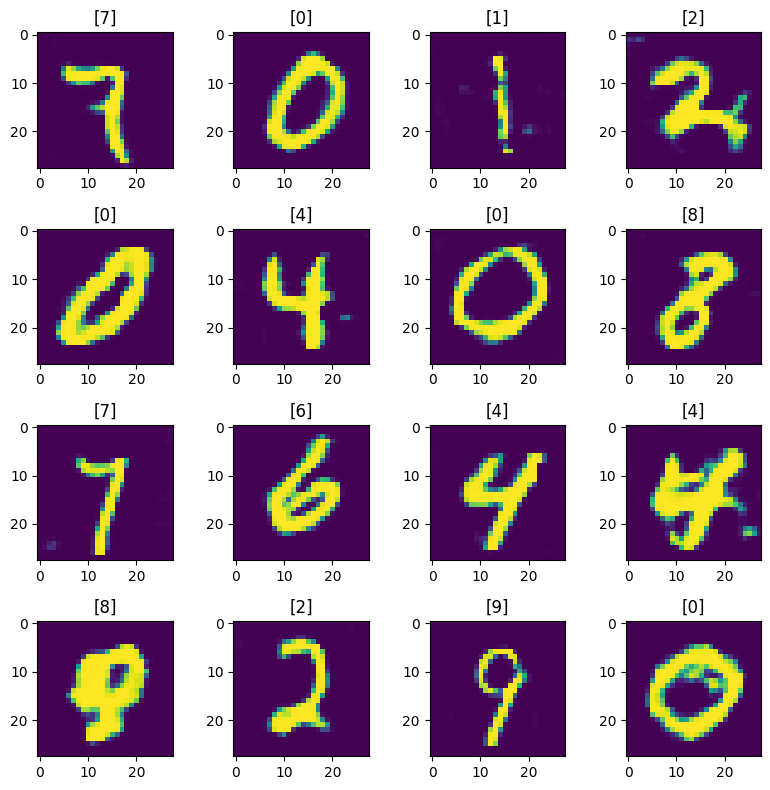

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5161433666944504 [1.0765568017959595, 0.2421875]
1/1 [==============================] - 0s 24ms/step


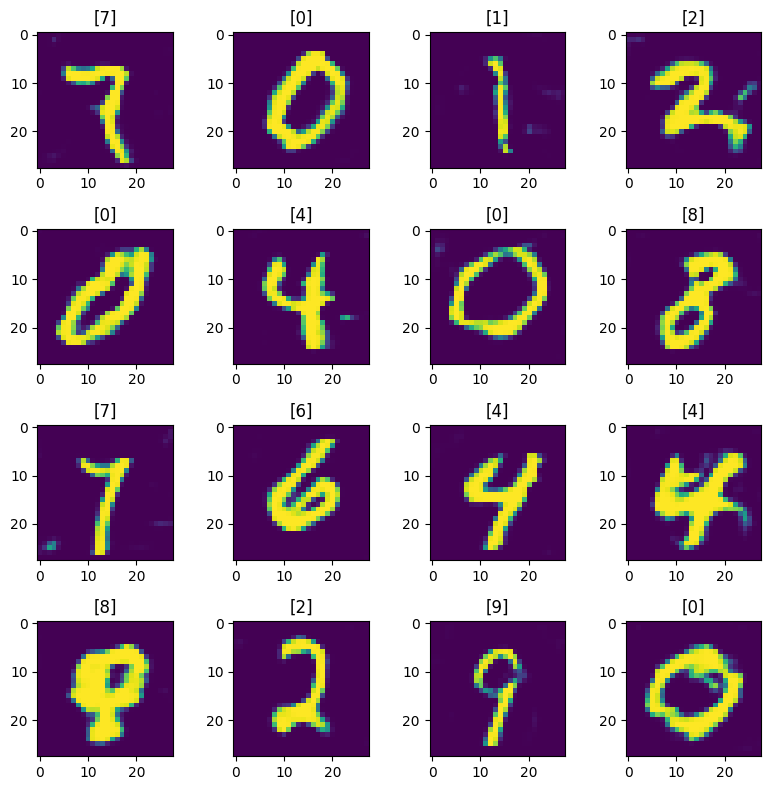

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5985840260982513 [1.0890824794769287, 0.28125]
1/1 [==============================] - 0s 32ms/step


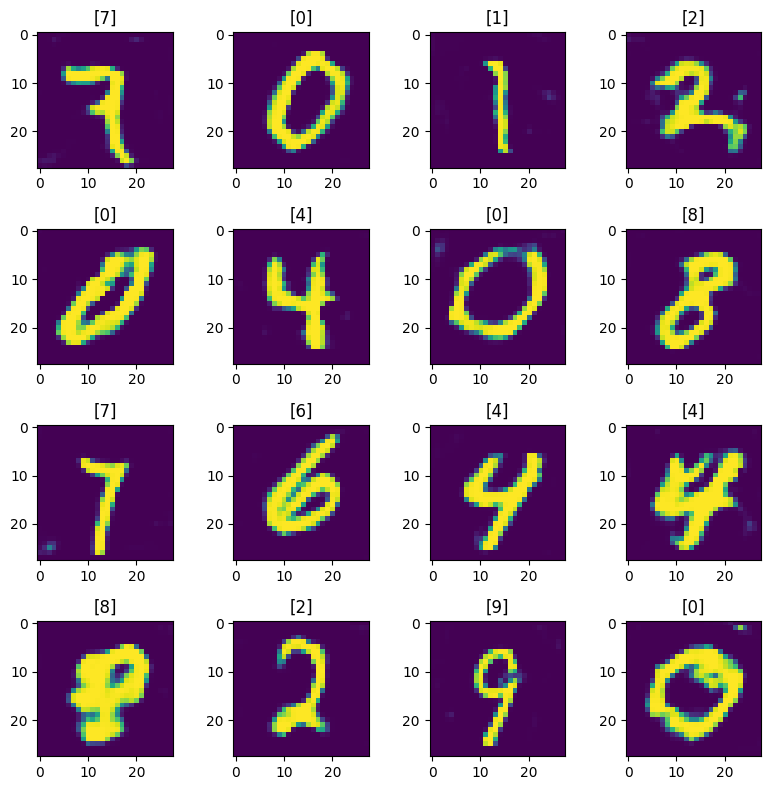

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5300783812999725 [1.2451887130737305, 0.2265625]
1/1 [==============================] - 0s 18ms/step


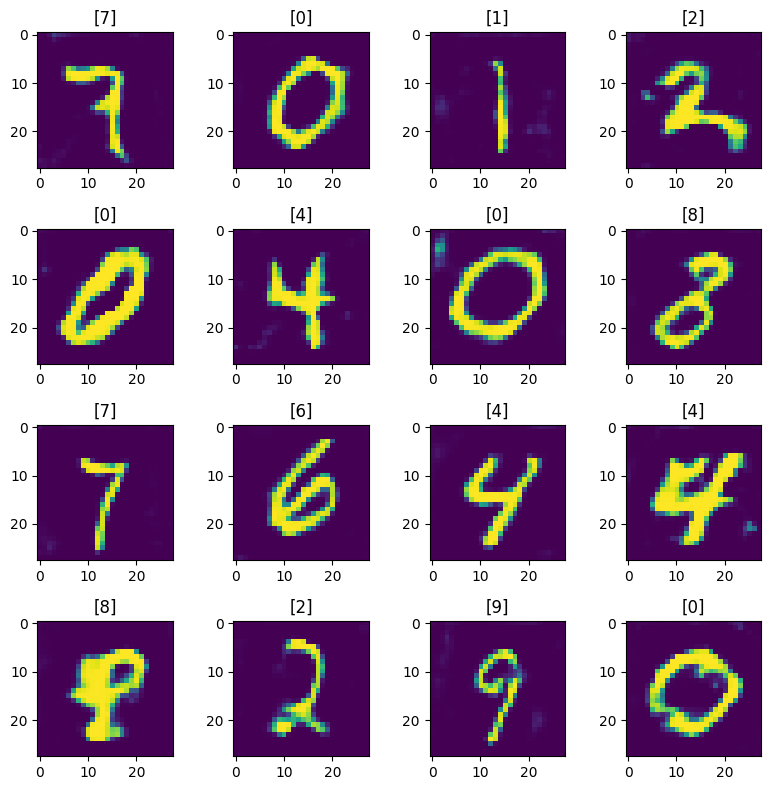

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5776150822639465 [0.9993077516555786, 0.2578125]
1/1 [==============================] - 0s 18ms/step


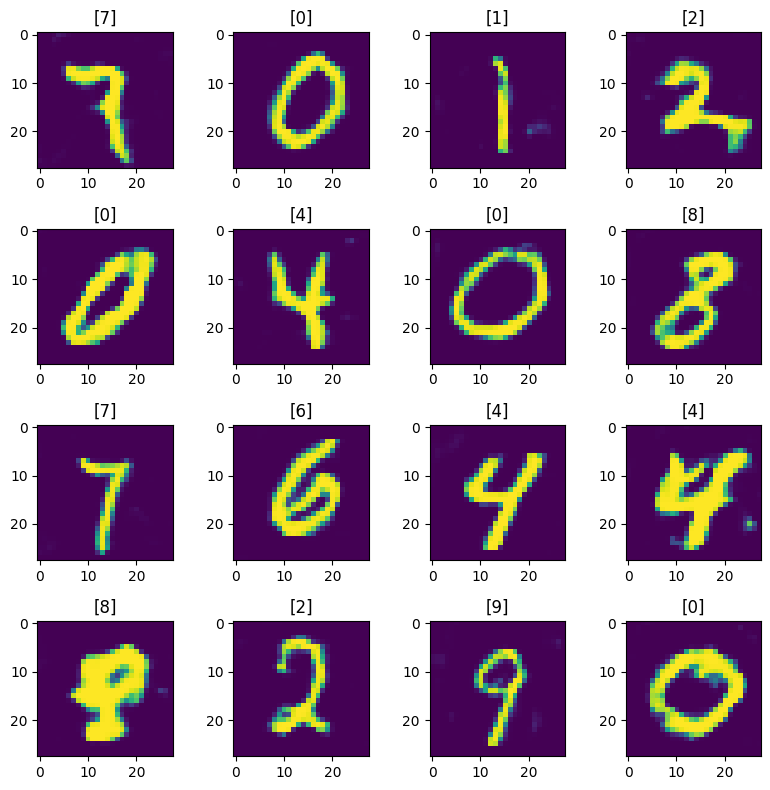

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6192841529846191 [1.0885298252105713, 0.2109375]
1/1 [==============================] - 0s 18ms/step


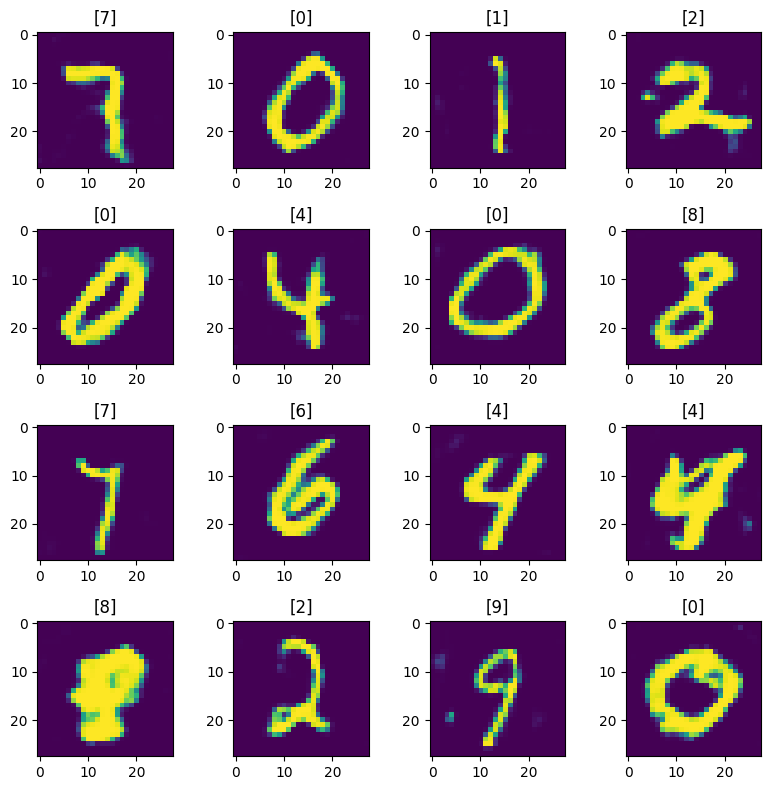

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5490215420722961 [1.0139365196228027, 0.3359375]
1/1 [==============================] - 0s 20ms/step


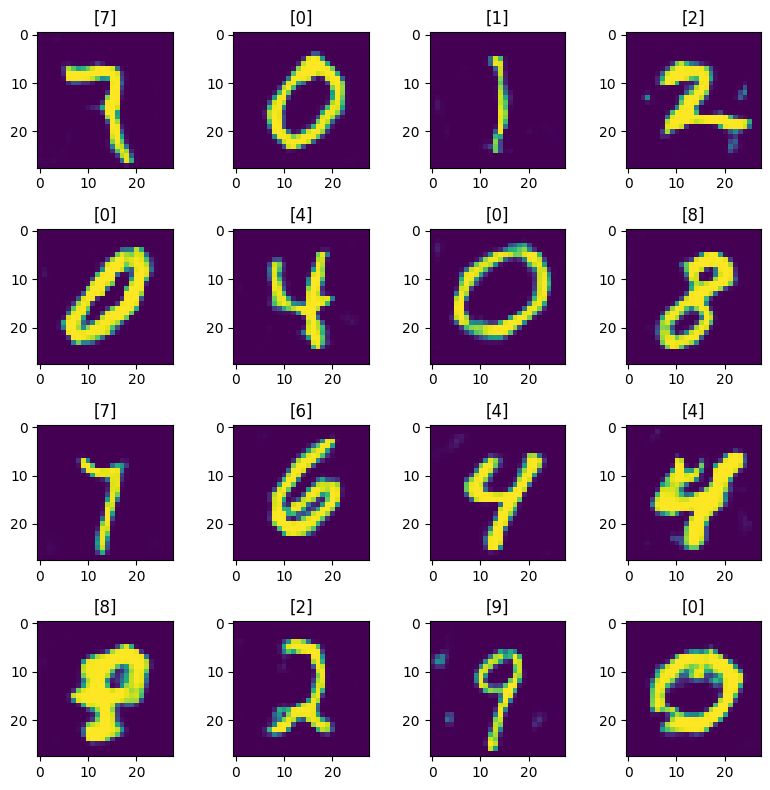

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6473970711231232 [1.1110140085220337, 0.234375]
1/1 [==============================] - 0s 28ms/step


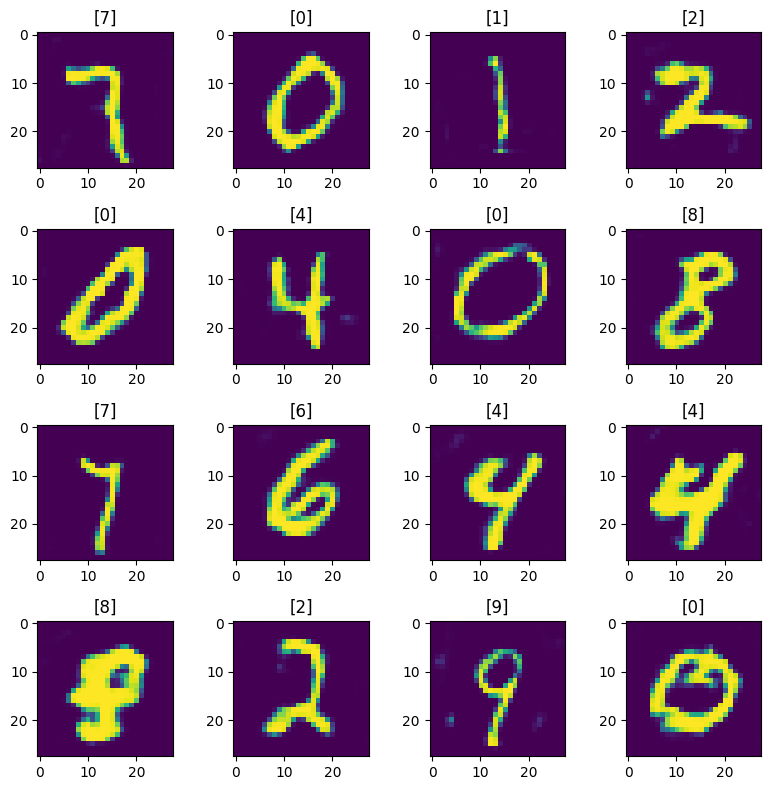

4/4 [==============================] - 0s 9ms/step
Losses(d,g): 0.5953099131584167 [1.078289270401001, 0.2578125]
1/1 [==============================] - 0s 20ms/step


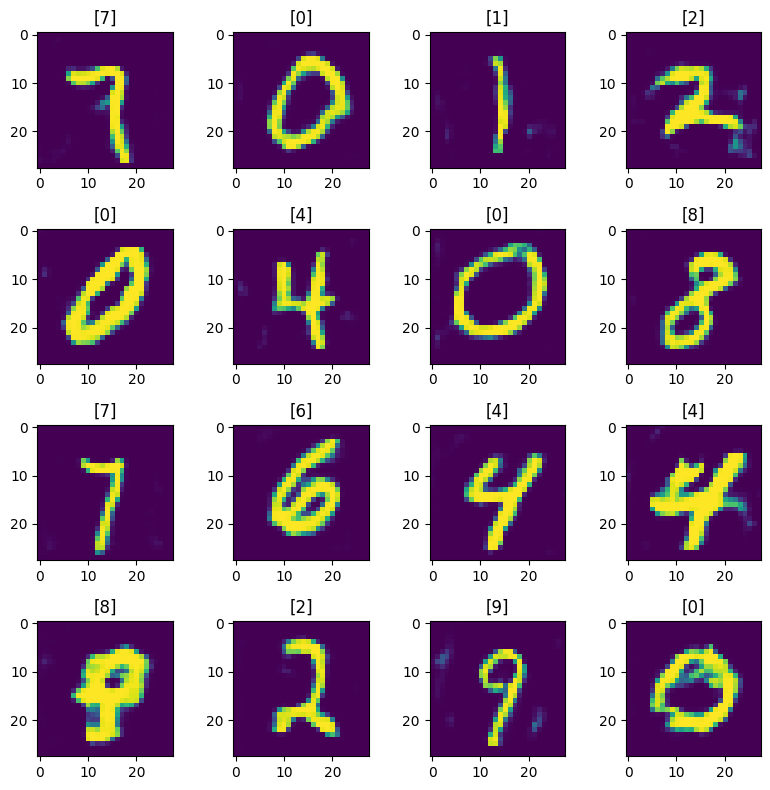

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5809358954429626 [0.9961392879486084, 0.3203125]
1/1 [==============================] - 0s 19ms/step


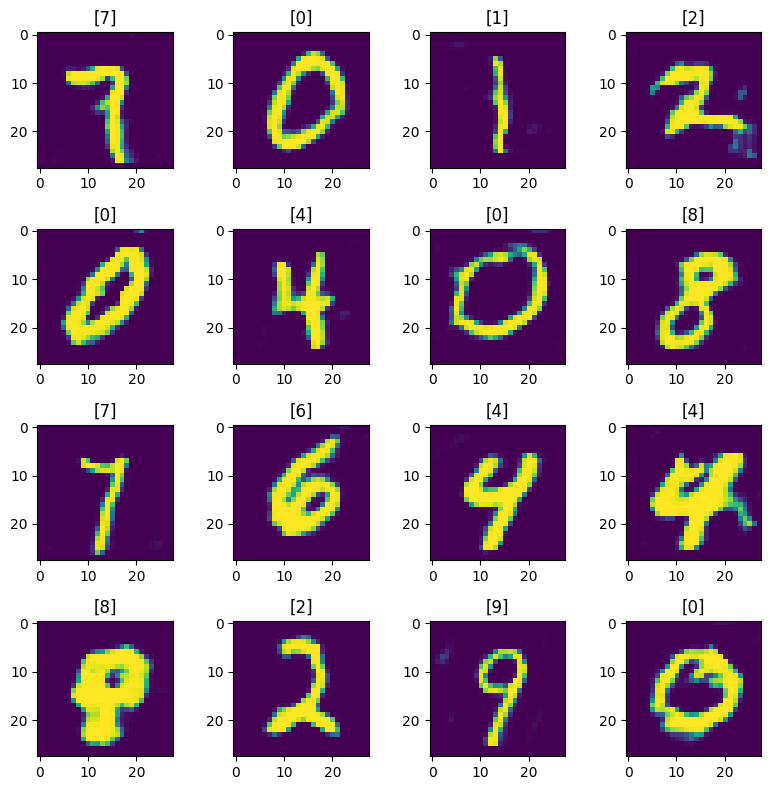

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.591837540268898 [1.334547519683838, 0.171875]
1/1 [==============================] - 0s 23ms/step


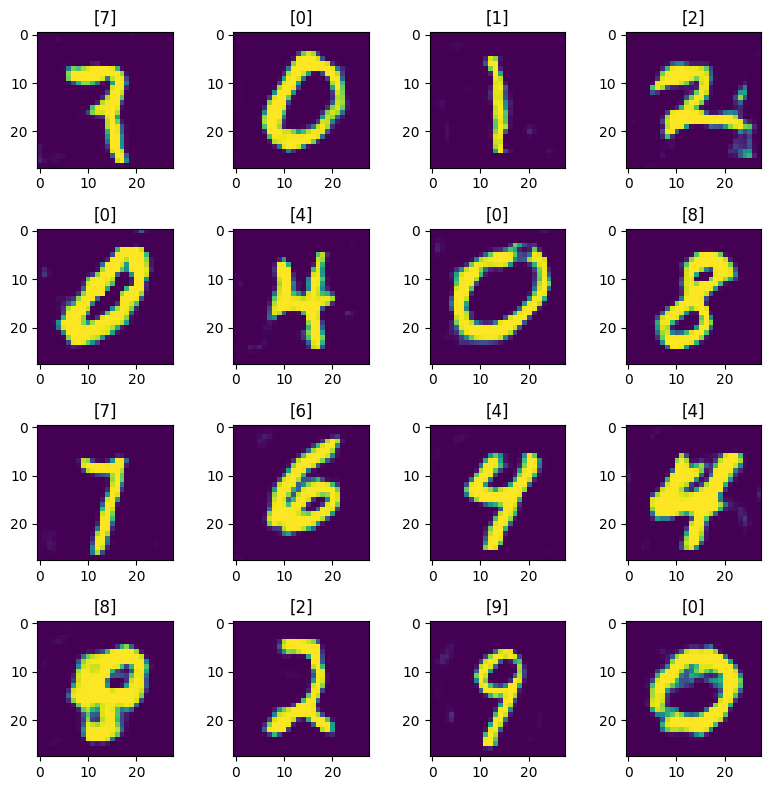

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.6367025971412659 [1.2213826179504395, 0.2421875]
1/1 [==============================] - 0s 44ms/step


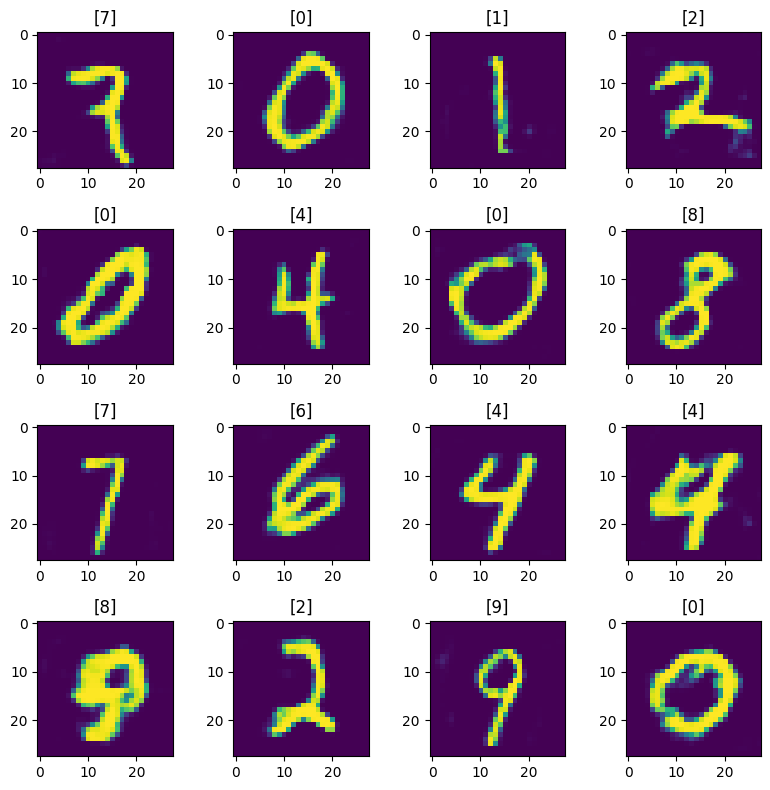

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5771670937538147 [1.193834900856018, 0.234375]
1/1 [==============================] - 0s 19ms/step


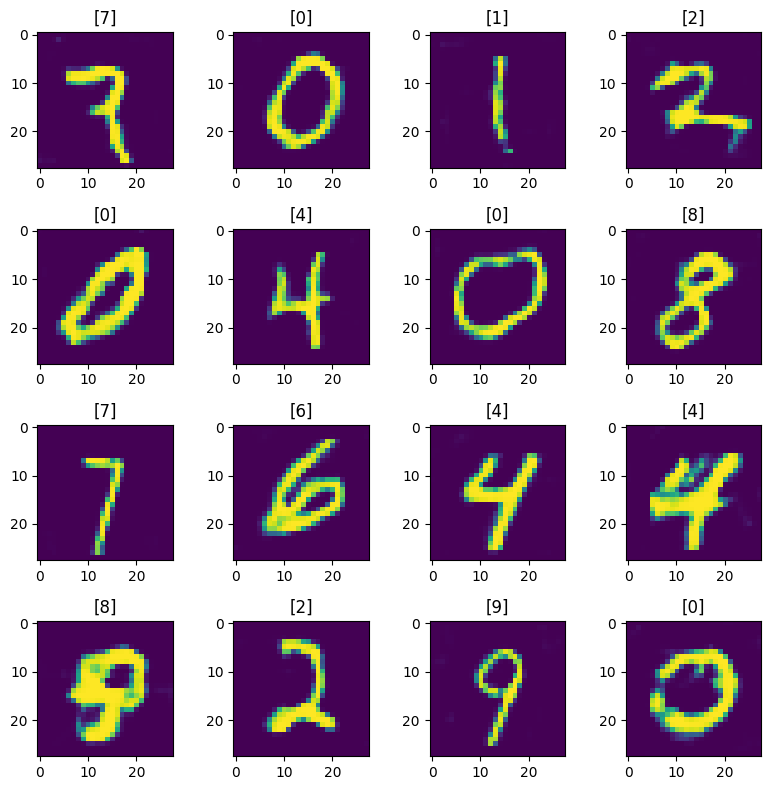

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5598202347755432 [1.1327530145645142, 0.265625]
1/1 [==============================] - 0s 18ms/step


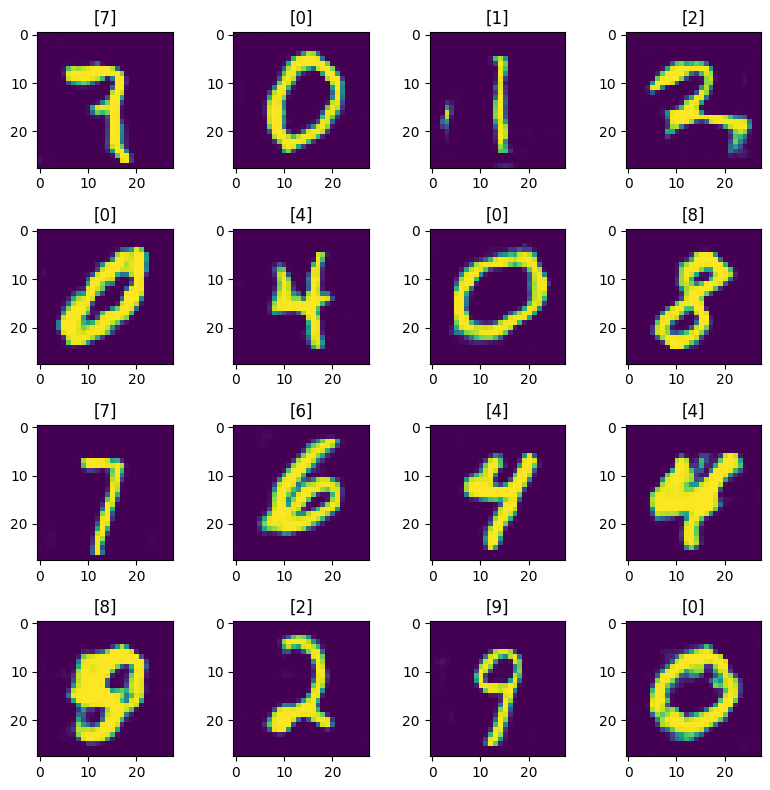

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5600436329841614 [1.2852818965911865, 0.1796875]
1/1 [==============================] - 0s 18ms/step


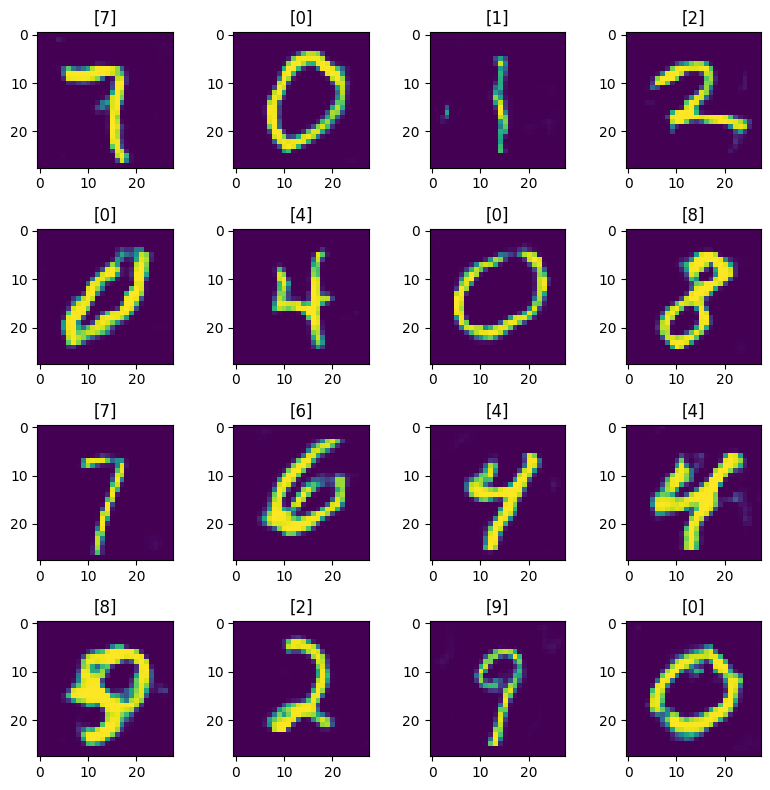

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5686662197113037 [1.1240344047546387, 0.234375]
1/1 [==============================] - 0s 19ms/step


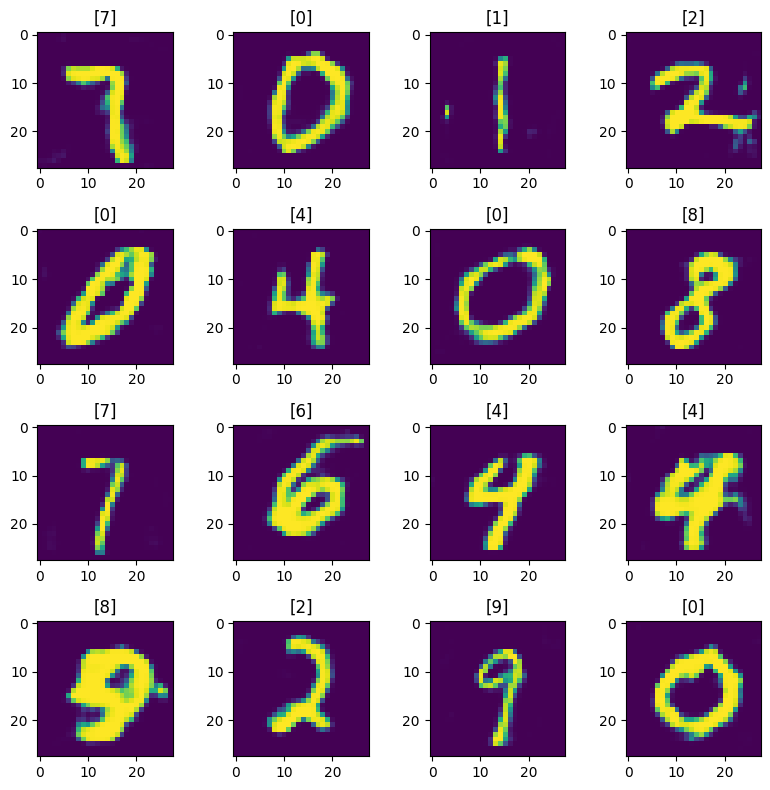

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5617277026176453 [1.1447176933288574, 0.21875]
1/1 [==============================] - 0s 22ms/step


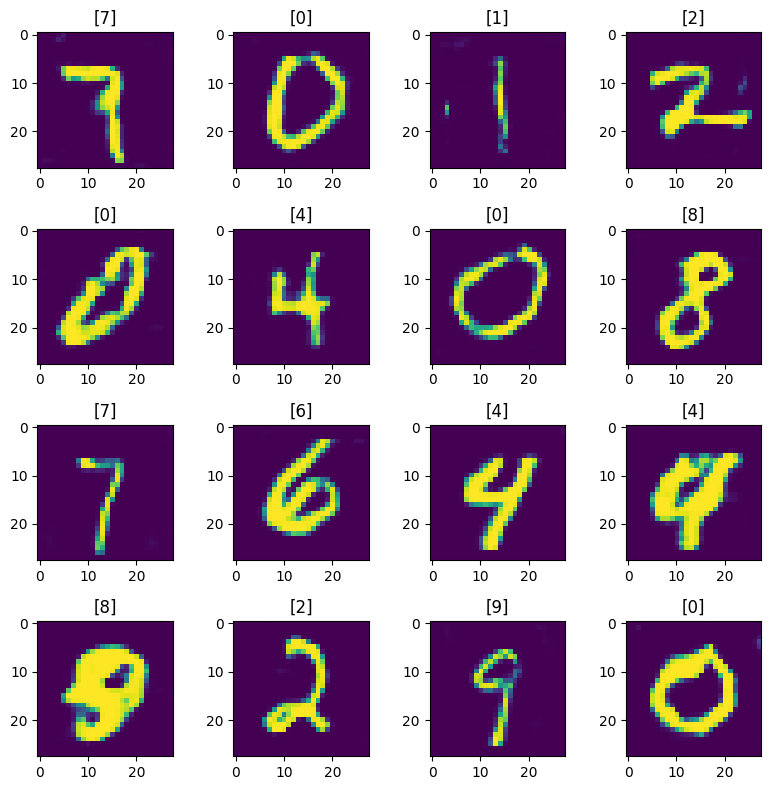

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5184955447912216 [1.107931137084961, 0.2734375]
1/1 [==============================] - 0s 19ms/step


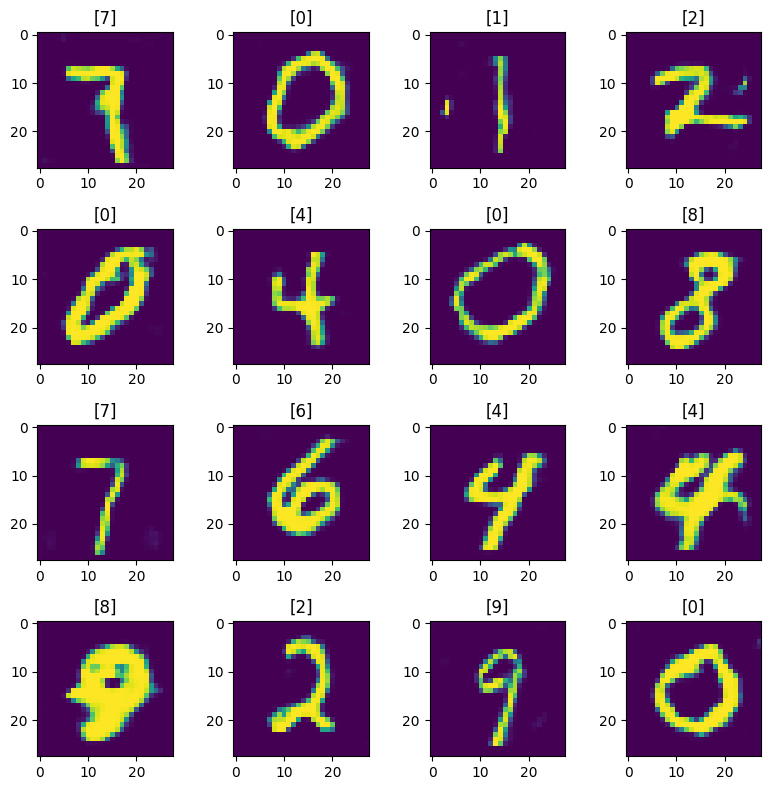

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5814085304737091 [1.1198965311050415, 0.2890625]
1/1 [==============================] - 0s 26ms/step


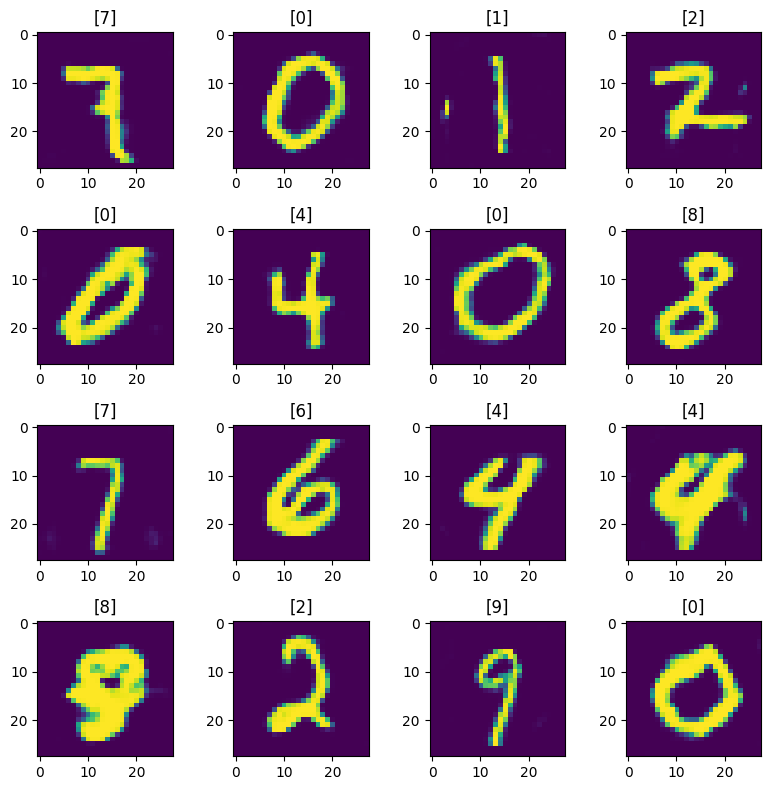

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5535393208265305 [1.1261308193206787, 0.1875]
1/1 [==============================] - 0s 31ms/step


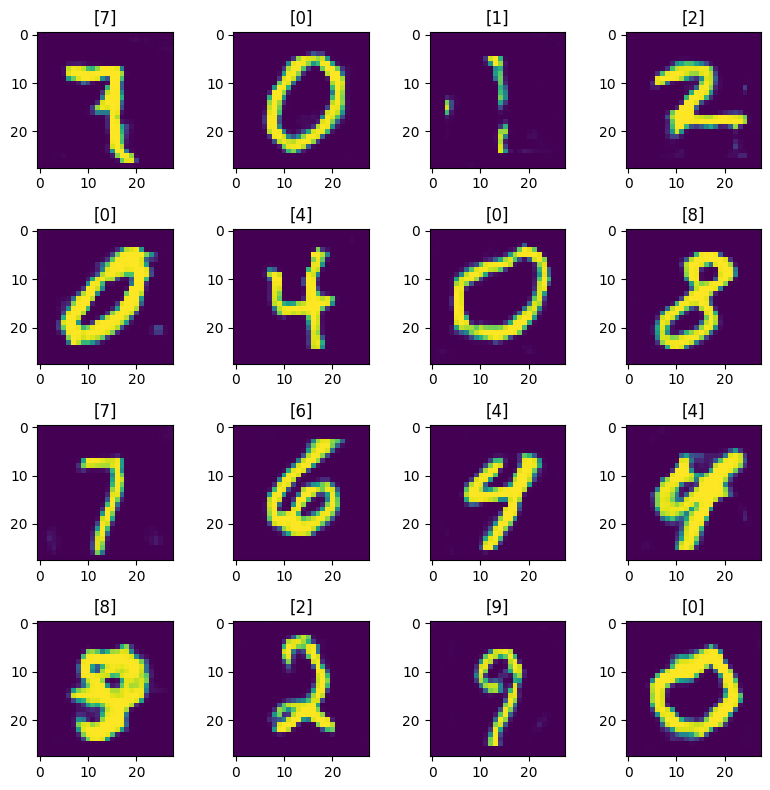

4/4 [==============================] - 0s 8ms/step
Losses(d,g): 0.5546424686908722 [1.0050318241119385, 0.2890625]
1/1 [==============================] - 0s 23ms/step


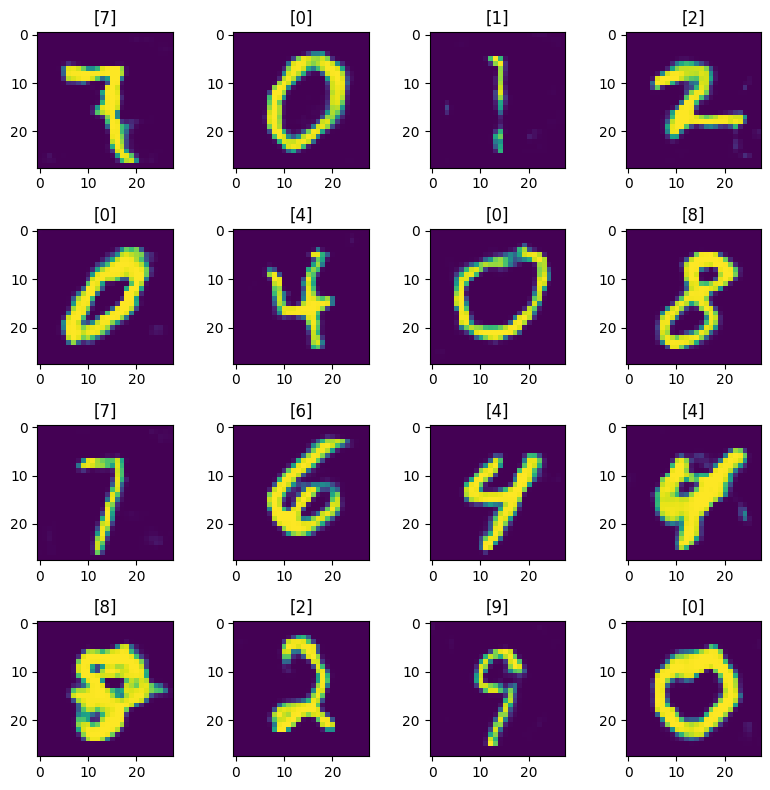

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5454631149768829 [1.0856655836105347, 0.2421875]
1/1 [==============================] - 0s 20ms/step


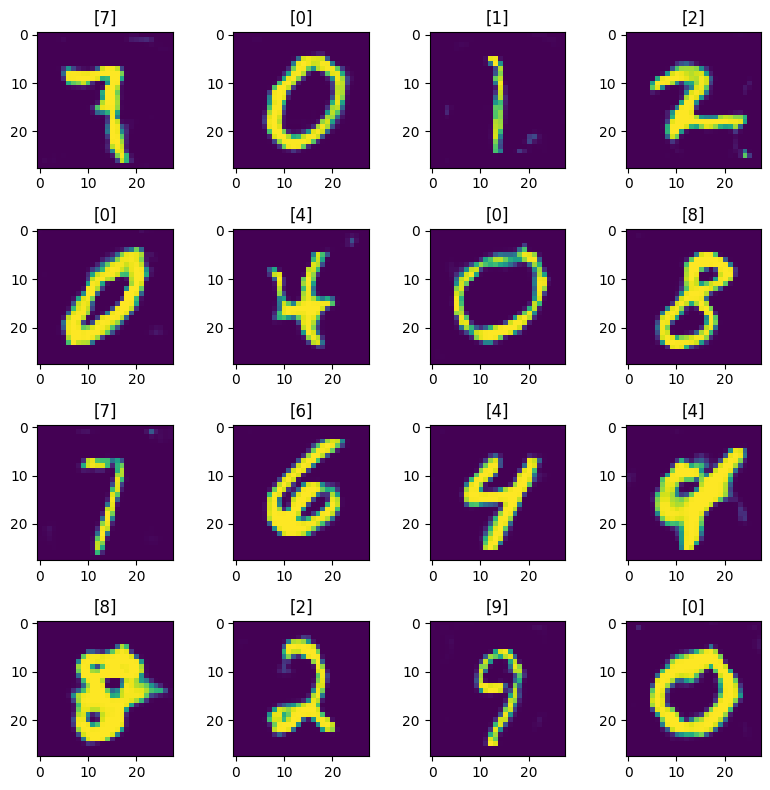

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5584858059883118 [1.1941261291503906, 0.2265625]
1/1 [==============================] - 0s 53ms/step


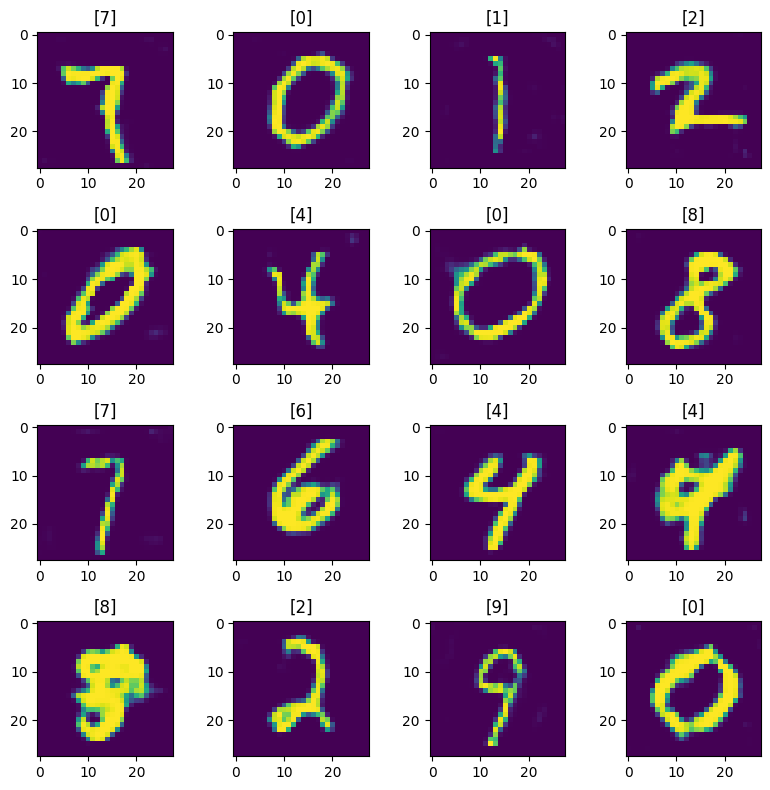

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.5014305114746094 [1.410567283630371, 0.21875]
1/1 [==============================] - 0s 19ms/step


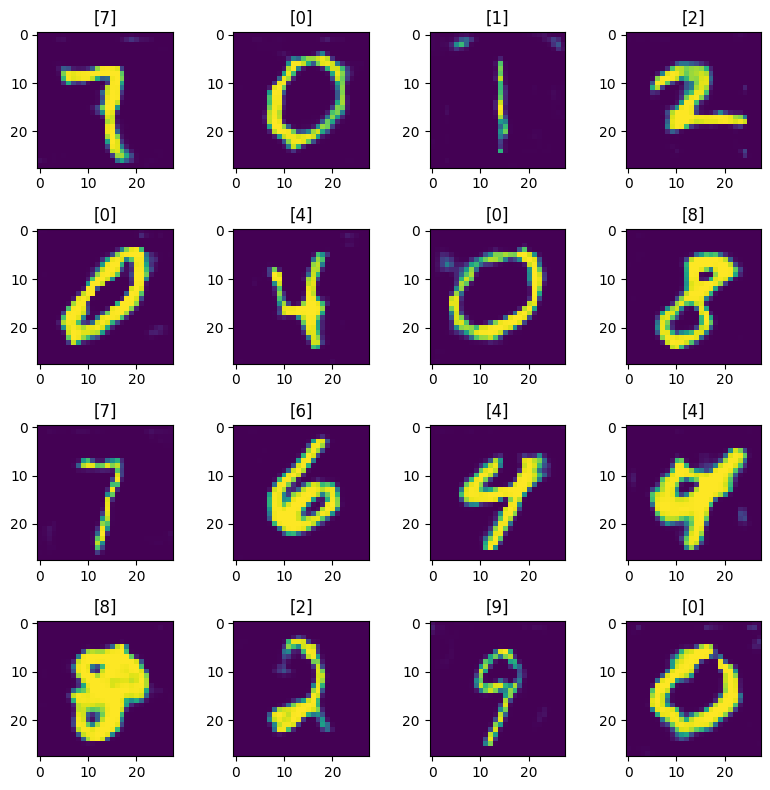

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5716332495212555 [1.0640790462493896, 0.234375]
1/1 [==============================] - 0s 18ms/step


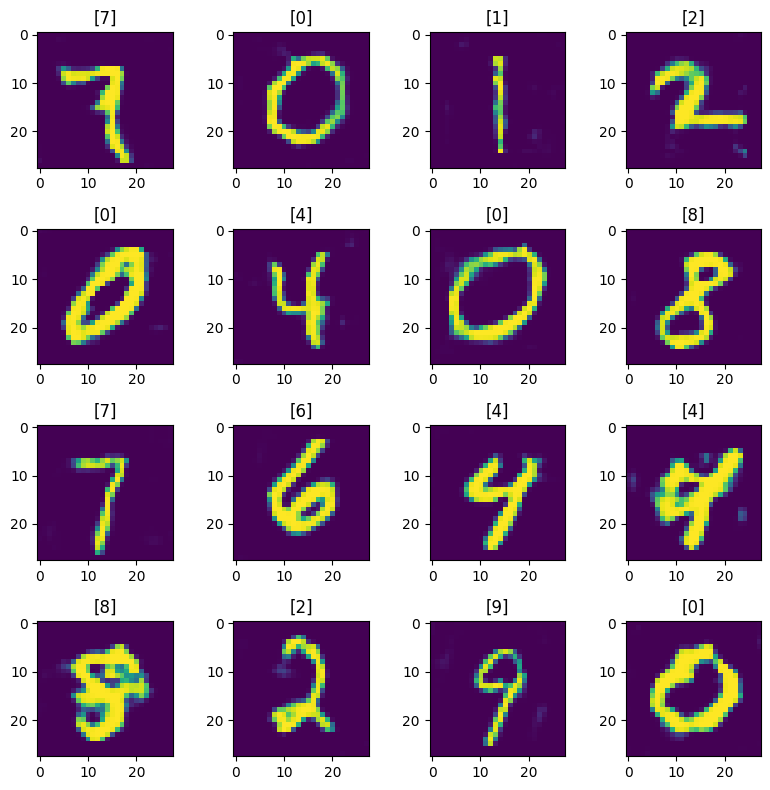

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5664284229278564 [1.1292165517807007, 0.265625]
1/1 [==============================] - 0s 22ms/step


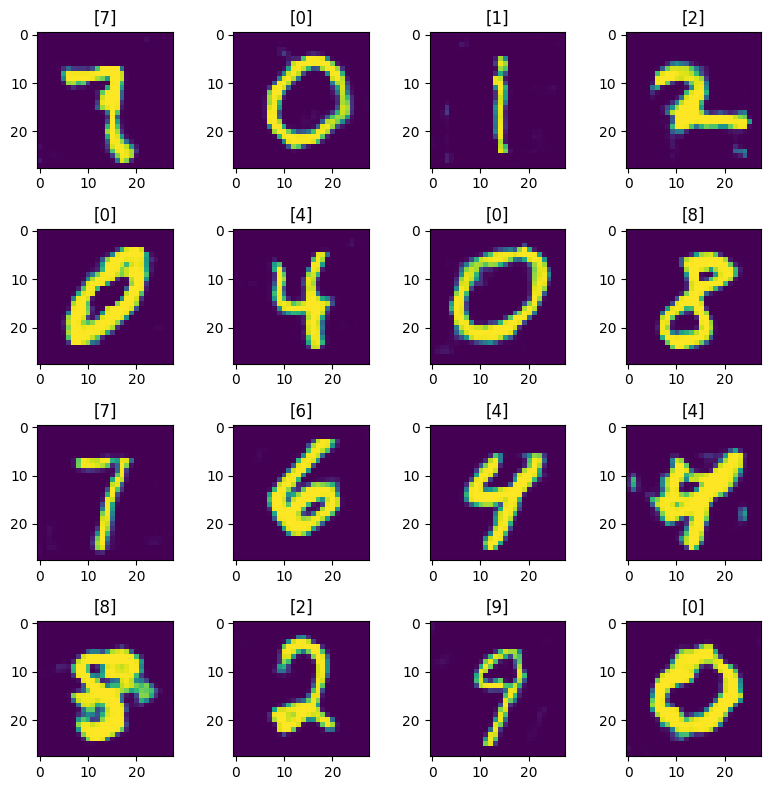

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5864456295967102 [1.0928888320922852, 0.2734375]
1/1 [==============================] - 0s 47ms/step


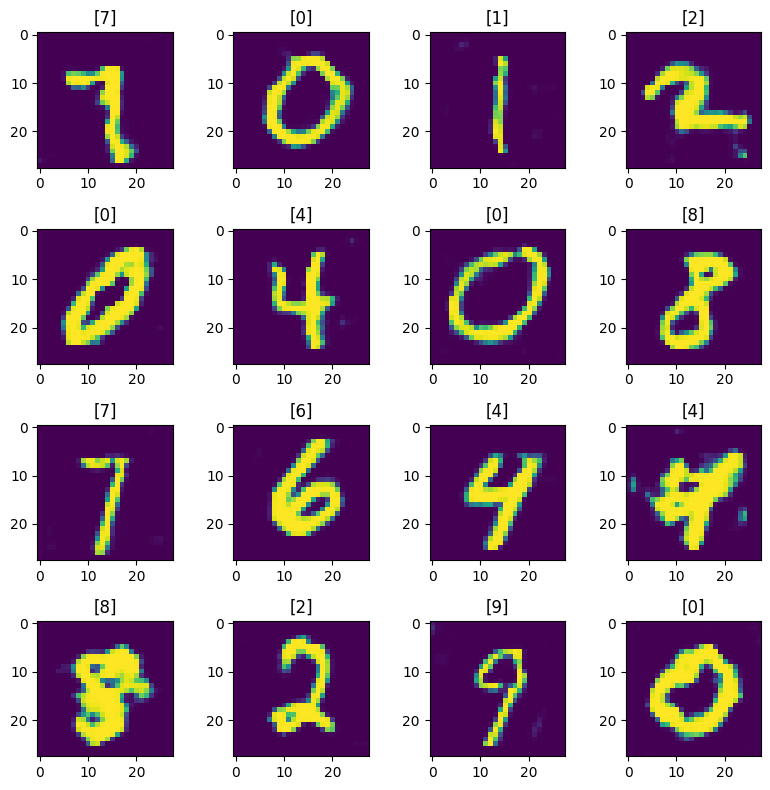

4/4 [==============================] - 0s 7ms/step
Losses(d,g): 0.566556990146637 [1.128649353981018, 0.21875]
1/1 [==============================] - 0s 20ms/step


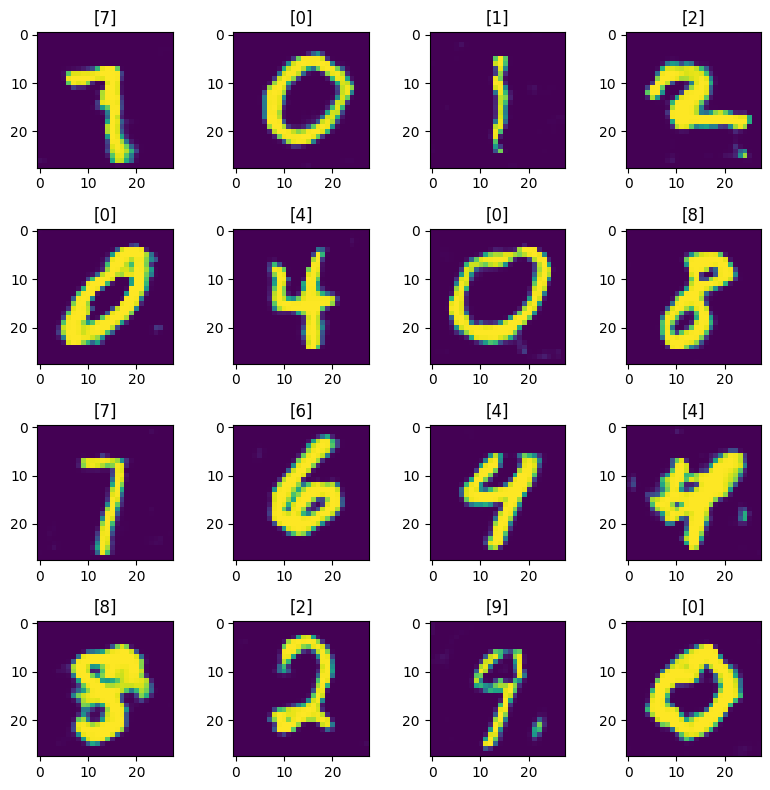

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5796931385993958 [1.0977115631103516, 0.2578125]
1/1 [==============================] - 0s 19ms/step


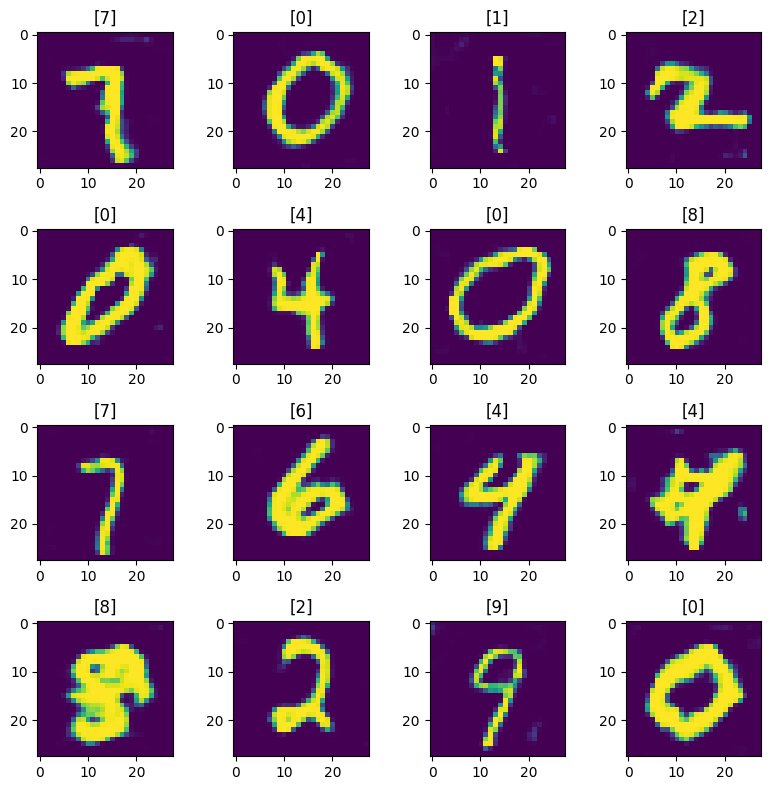

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5522620975971222 [1.0987904071807861, 0.2578125]
1/1 [==============================] - 0s 32ms/step


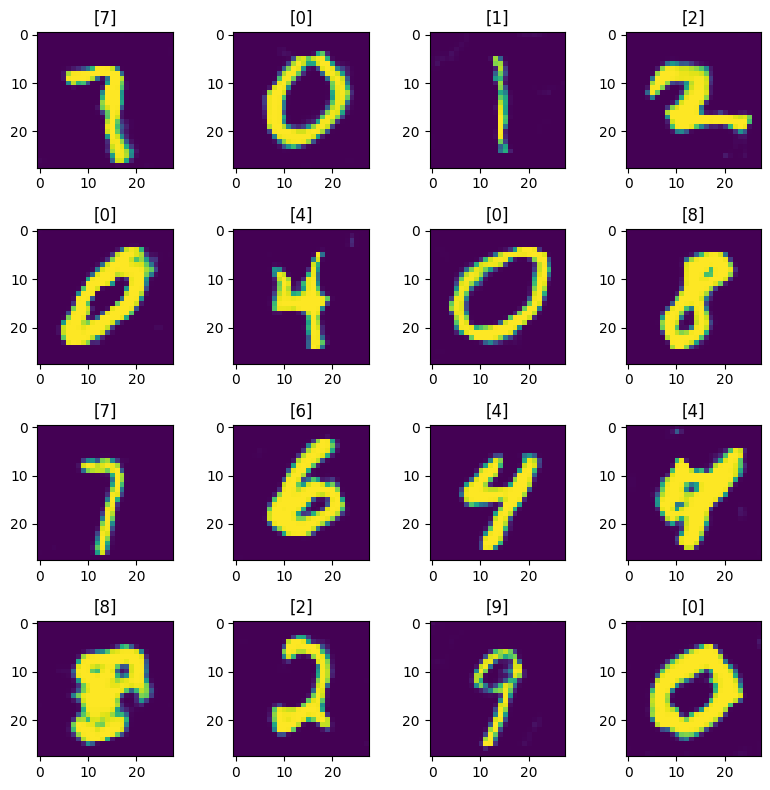

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5895320475101471 [1.06448233127594, 0.2734375]
1/1 [==============================] - 0s 39ms/step


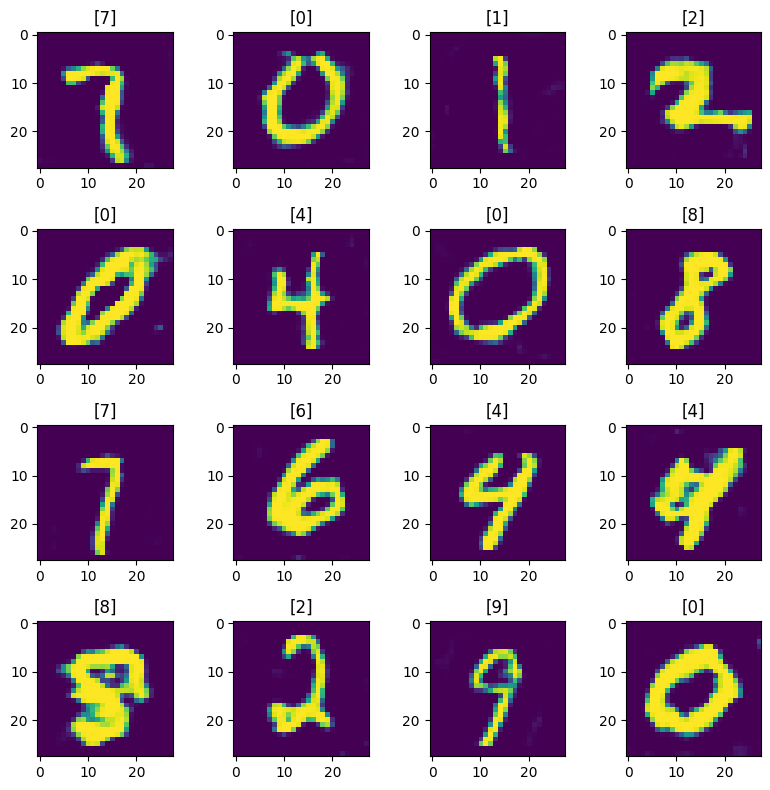

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.612722247838974 [1.003161907196045, 0.2734375]
1/1 [==============================] - 0s 23ms/step


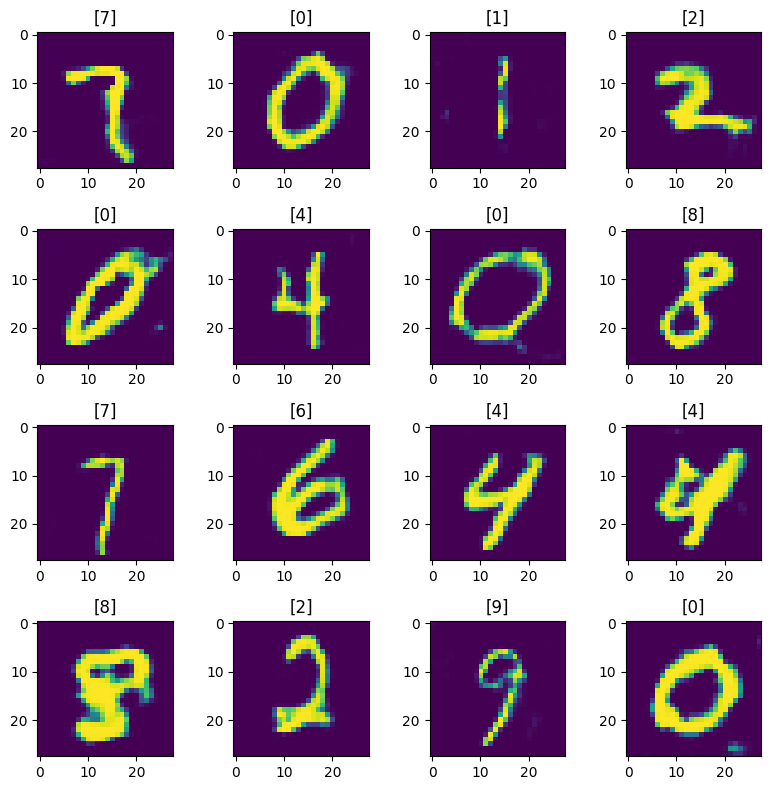

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6145232319831848 [0.9848850965499878, 0.2265625]
1/1 [==============================] - 0s 22ms/step


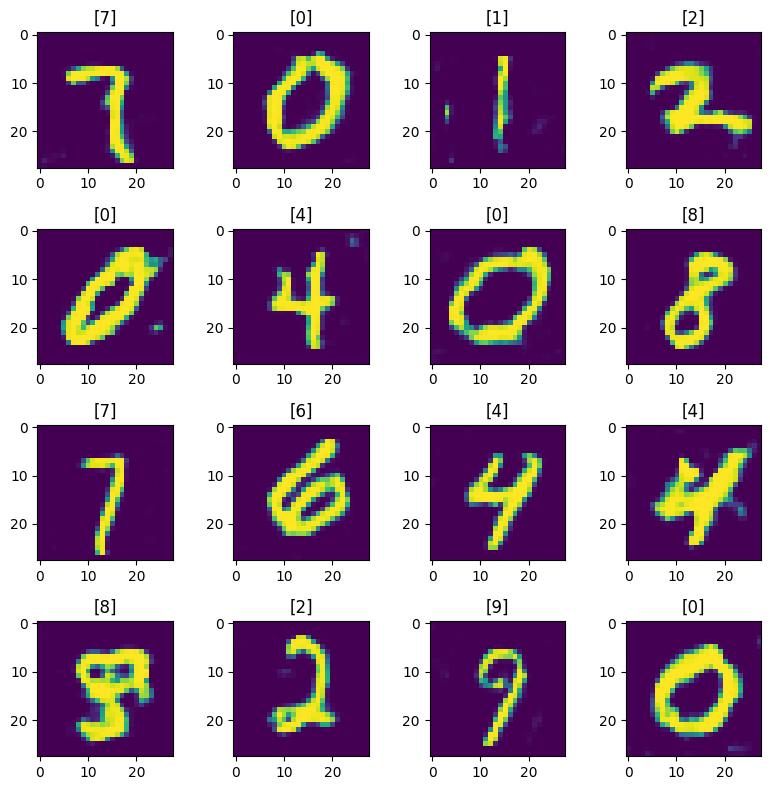

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.6073277741670609 [1.1352301836013794, 0.203125]
1/1 [==============================] - 0s 27ms/step


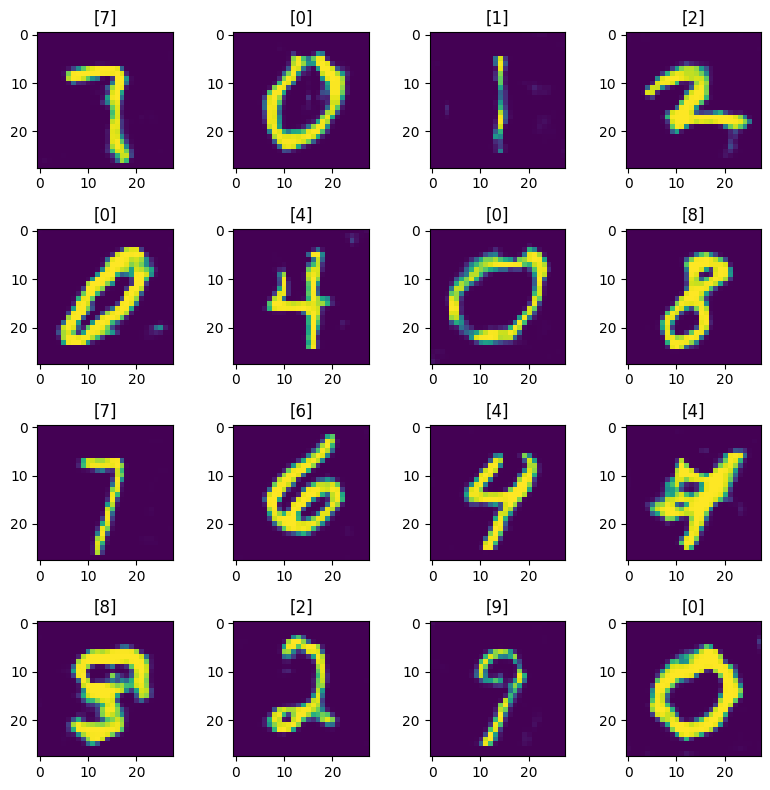

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5870791971683502 [1.0716928243637085, 0.2578125]
1/1 [==============================] - 0s 36ms/step


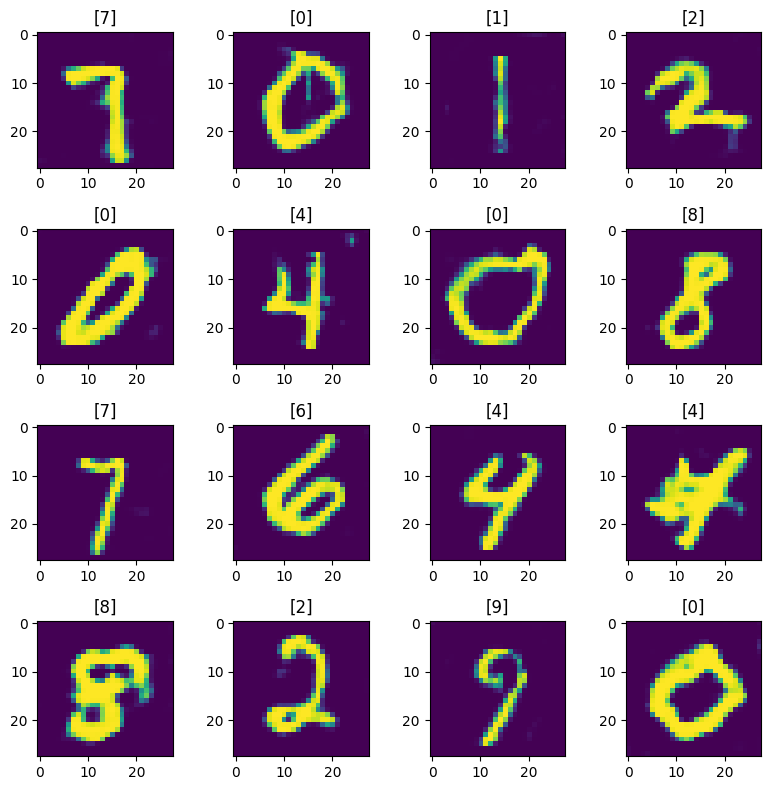

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5825933218002319 [1.0480825901031494, 0.28125]
1/1 [==============================] - 0s 28ms/step


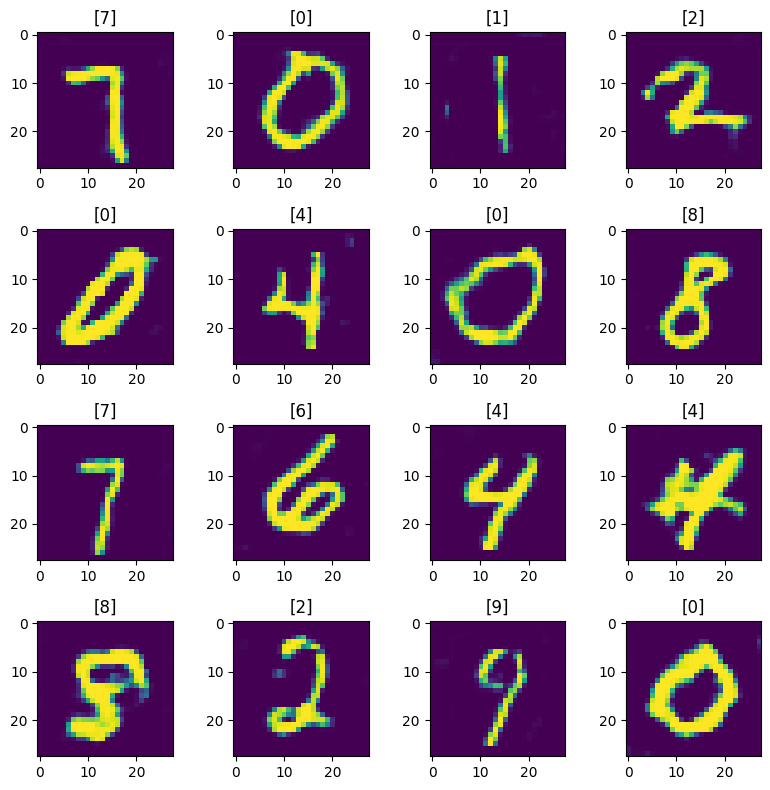

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5606080889701843 [1.059566617012024, 0.1875]
1/1 [==============================] - 0s 29ms/step


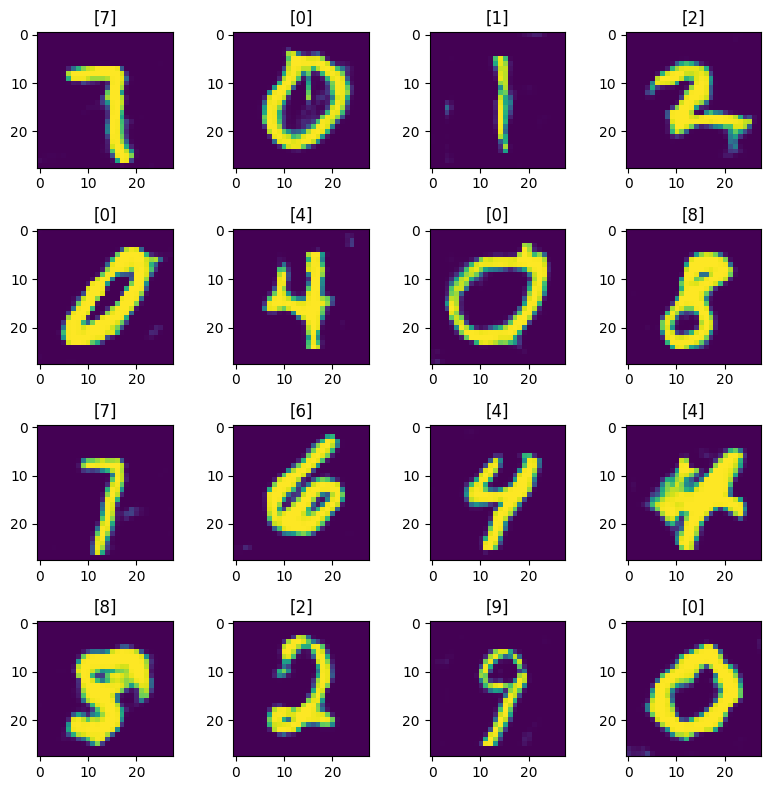

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6346226930618286 [0.8685756921768188, 0.3515625]
1/1 [==============================] - 0s 31ms/step


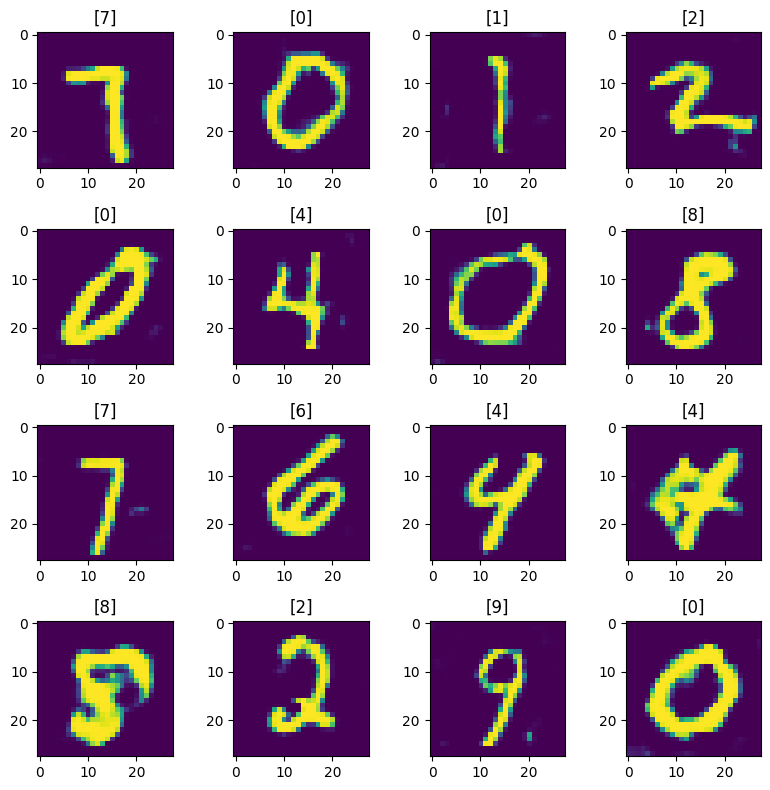

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6107576191425323 [1.0476434230804443, 0.2734375]
1/1 [==============================] - 0s 28ms/step


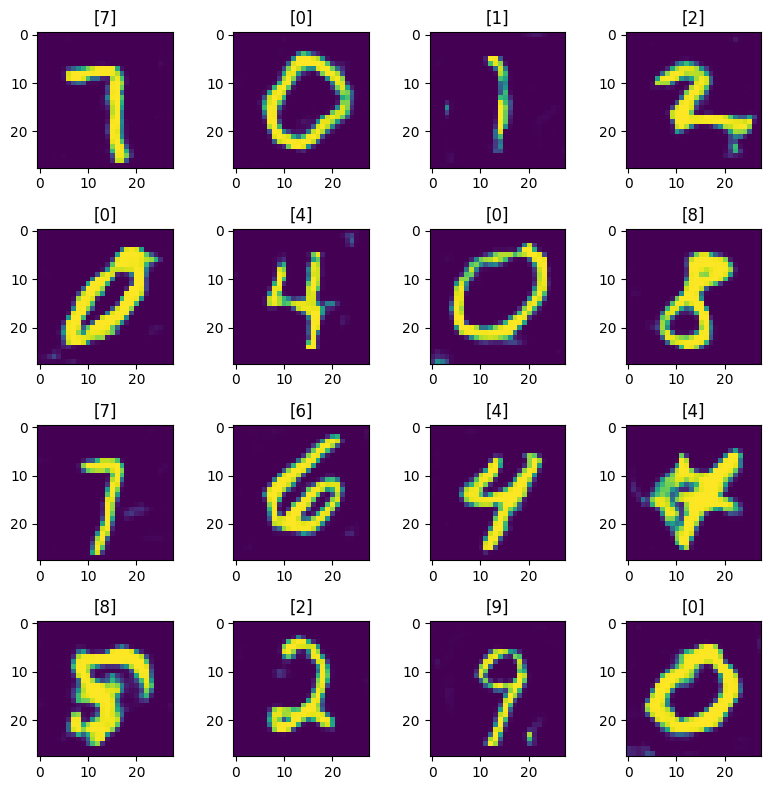

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.5291679203510284 [1.2326178550720215, 0.203125]
1/1 [==============================] - 0s 18ms/step


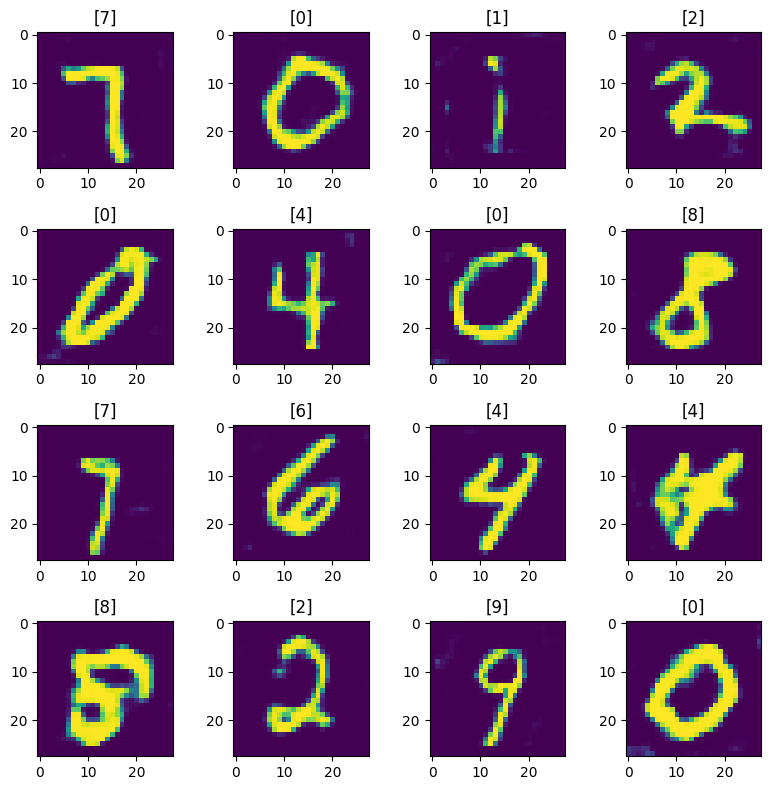

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5792983174324036 [1.0791314840316772, 0.2578125]
1/1 [==============================] - 0s 22ms/step


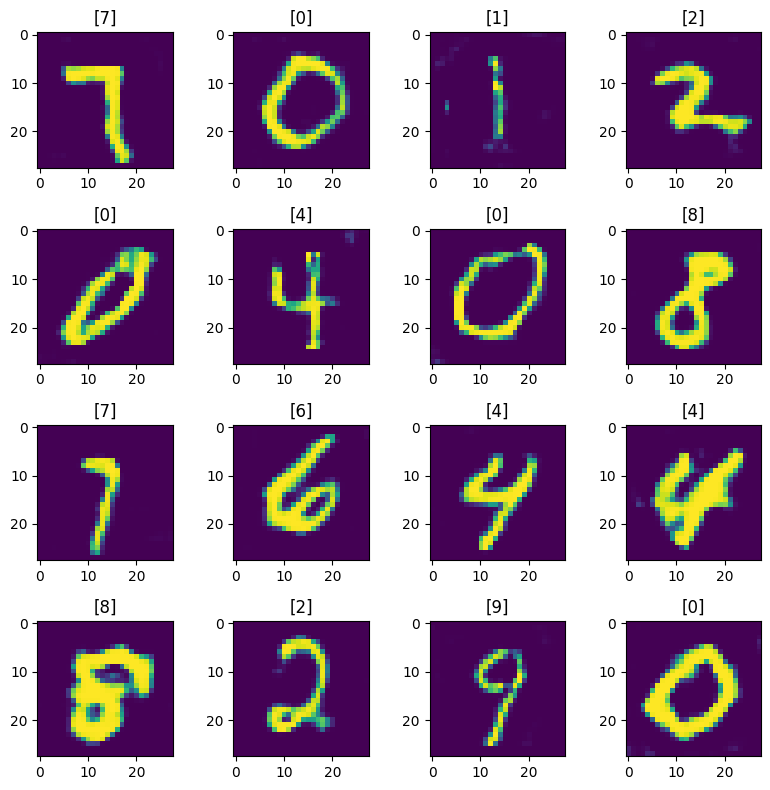

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.5255642831325531 [1.1465723514556885, 0.203125]
1/1 [==============================] - 0s 29ms/step


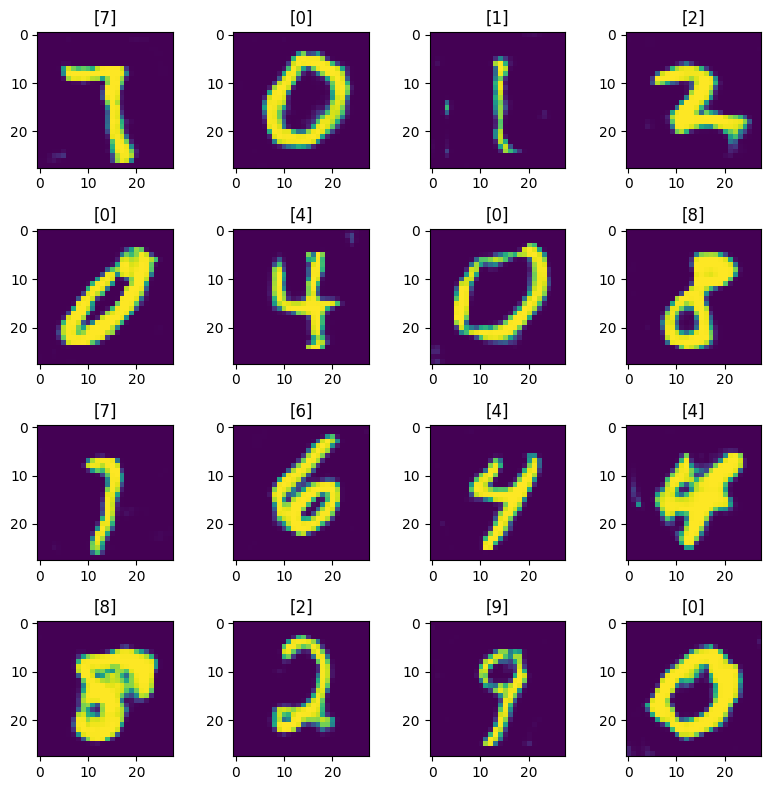

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6111381351947784 [0.9544852375984192, 0.2734375]
1/1 [==============================] - 0s 32ms/step


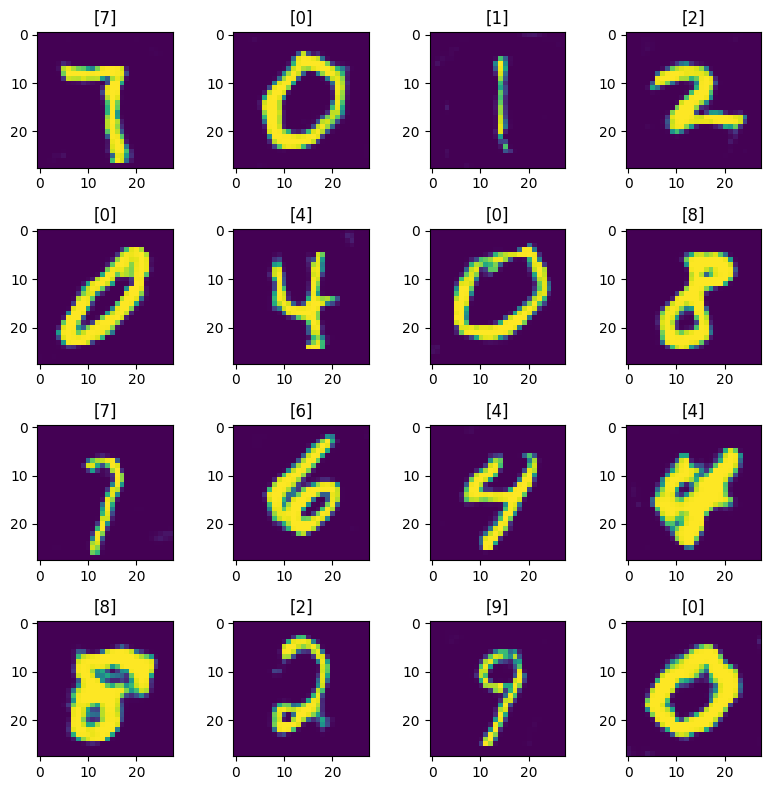

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.5739881098270416 [1.0180785655975342, 0.2734375]
1/1 [==============================] - 0s 42ms/step


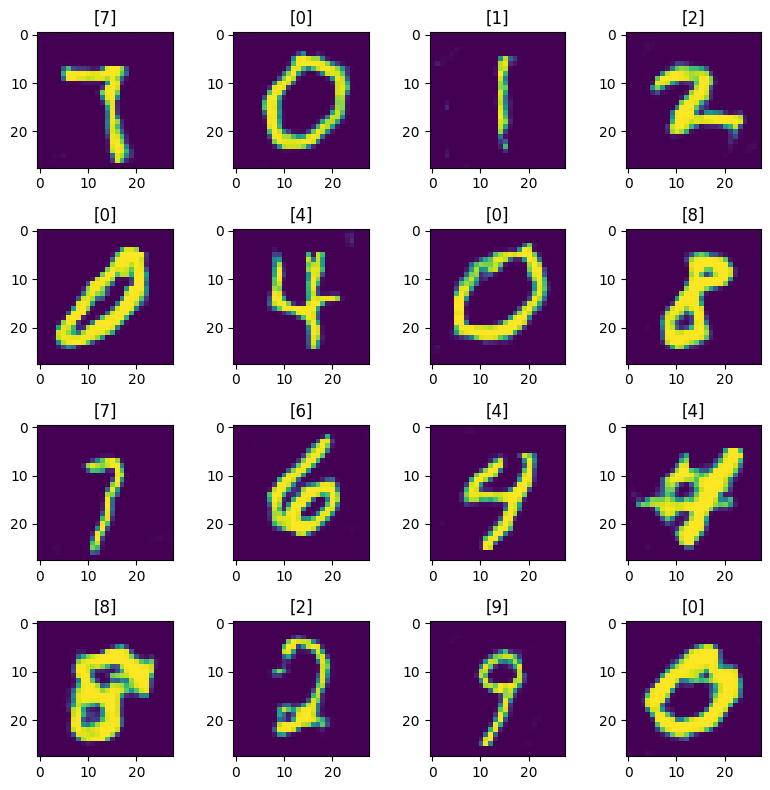

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6239670217037201 [1.0876590013504028, 0.2734375]
1/1 [==============================] - 0s 42ms/step


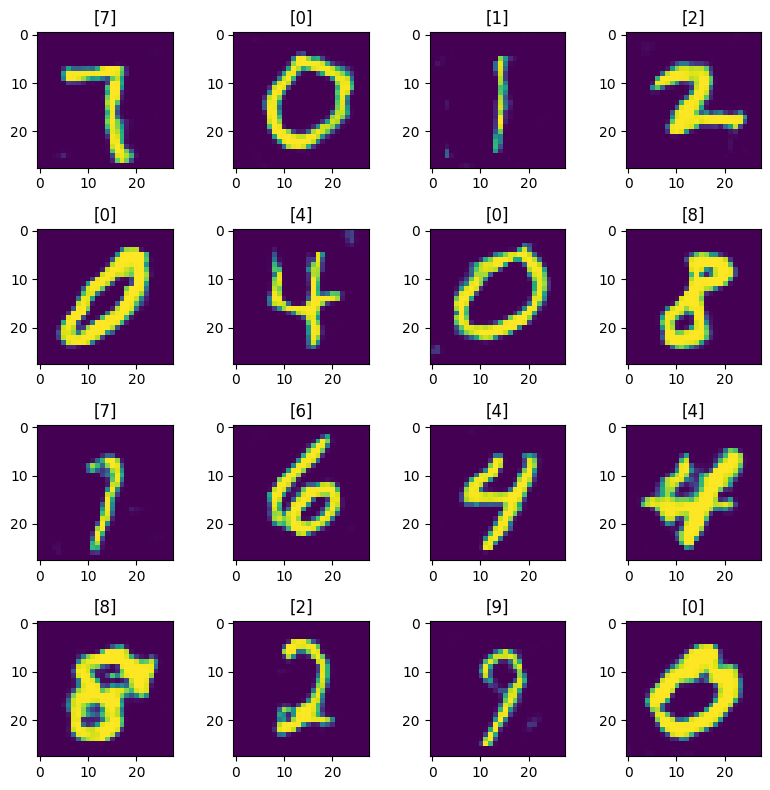

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.5775094032287598 [1.0702283382415771, 0.2421875]
1/1 [==============================] - 0s 27ms/step


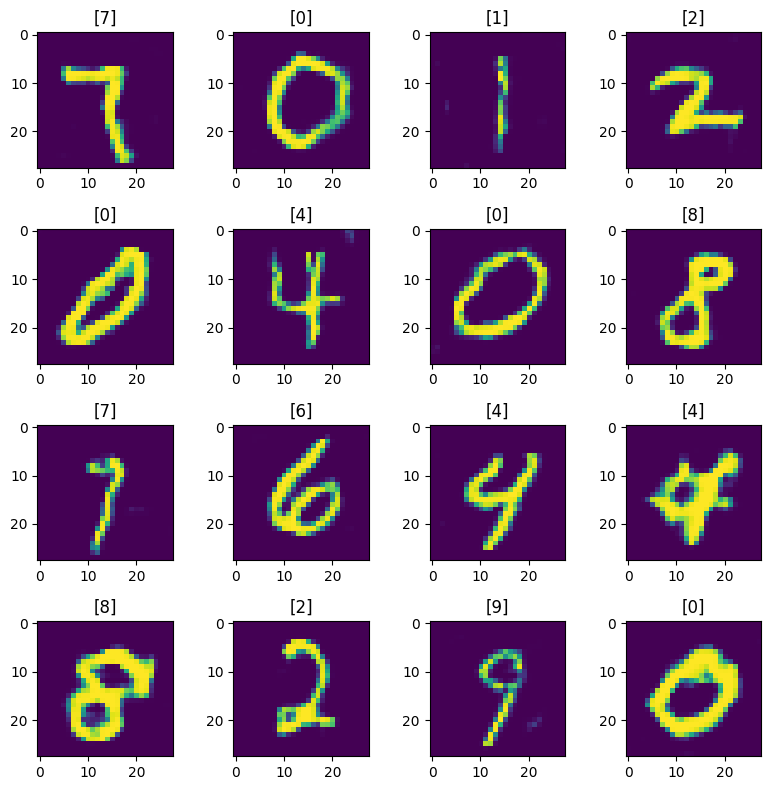

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5467188954353333 [1.3289287090301514, 0.125]
1/1 [==============================] - 0s 20ms/step


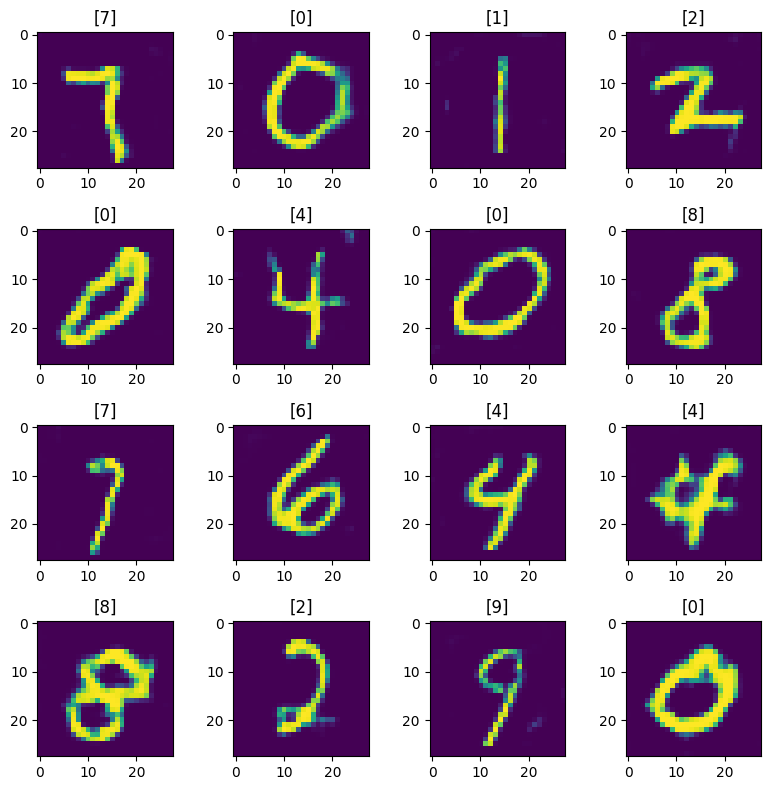

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5393581688404083 [1.2410571575164795, 0.1640625]
1/1 [==============================] - 0s 37ms/step


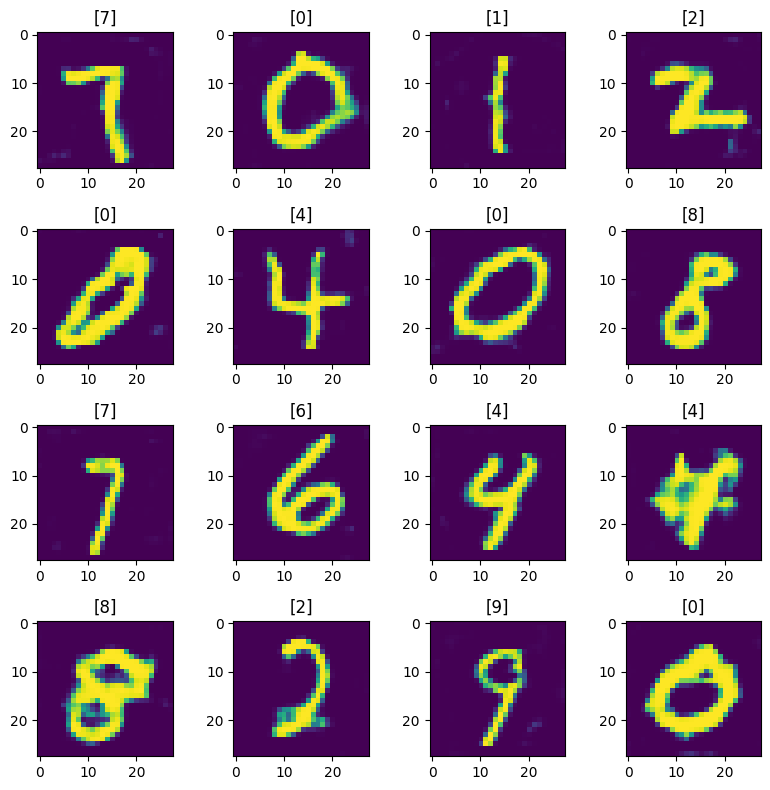

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5986681580543518 [1.0050201416015625, 0.25]
1/1 [==============================] - 0s 20ms/step


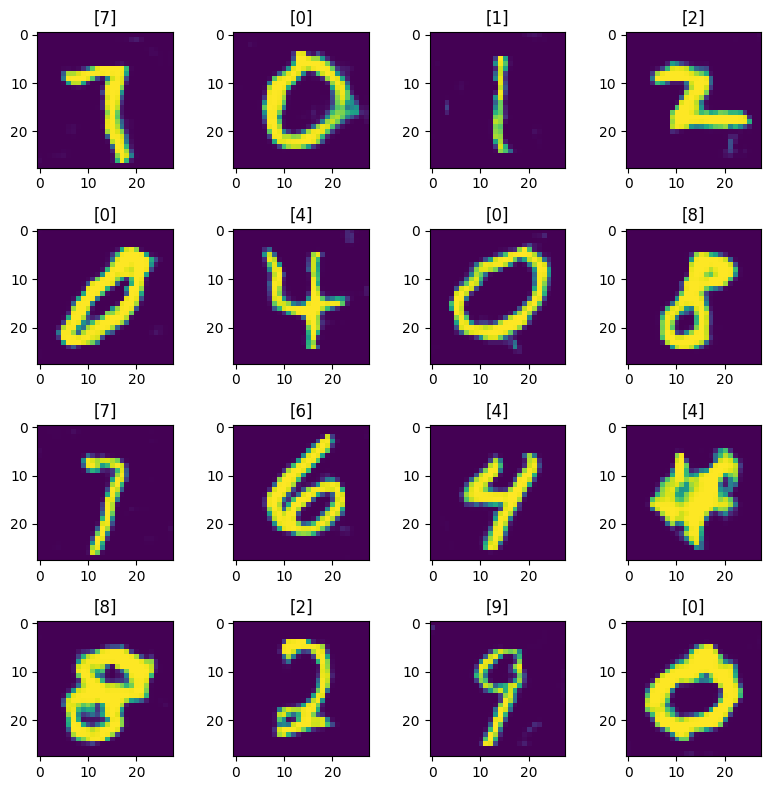

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.569352388381958 [1.0813723802566528, 0.2890625]
1/1 [==============================] - 0s 30ms/step


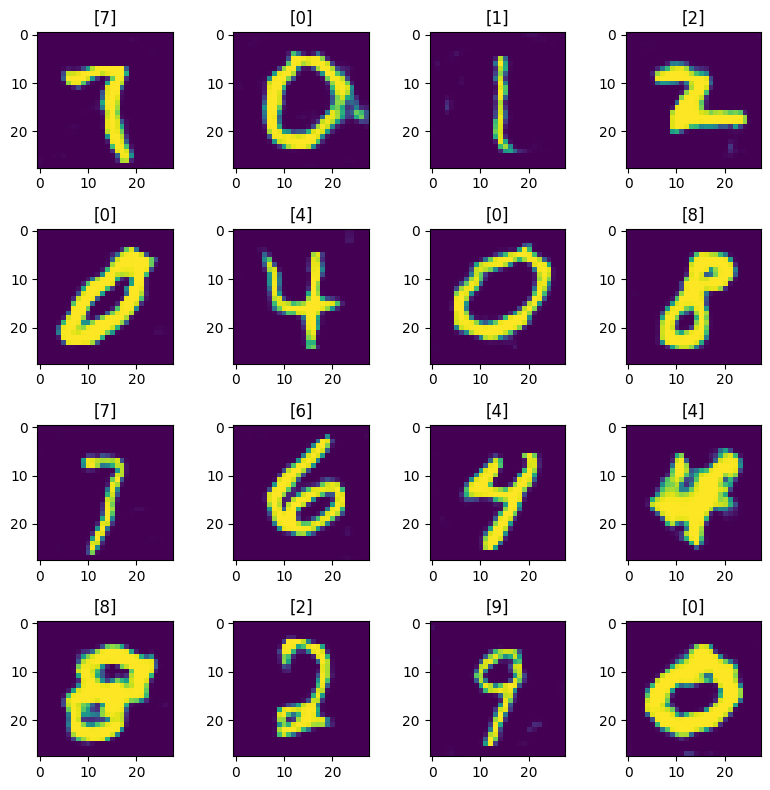

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.5767186880111694 [1.1430437564849854, 0.1875]
1/1 [==============================] - 0s 29ms/step


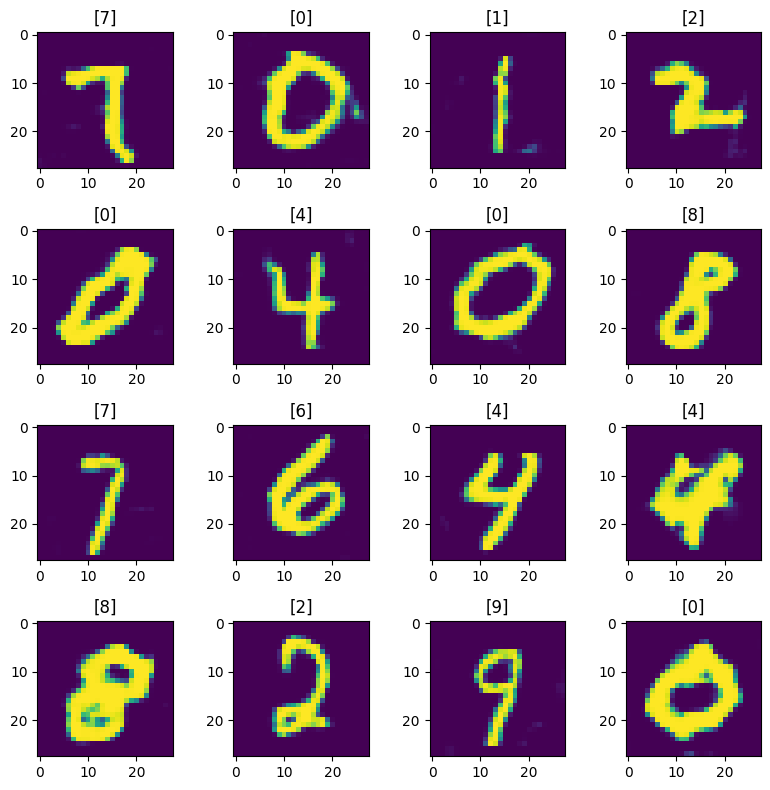

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5312518179416656 [1.036731481552124, 0.265625]
1/1 [==============================] - 0s 37ms/step


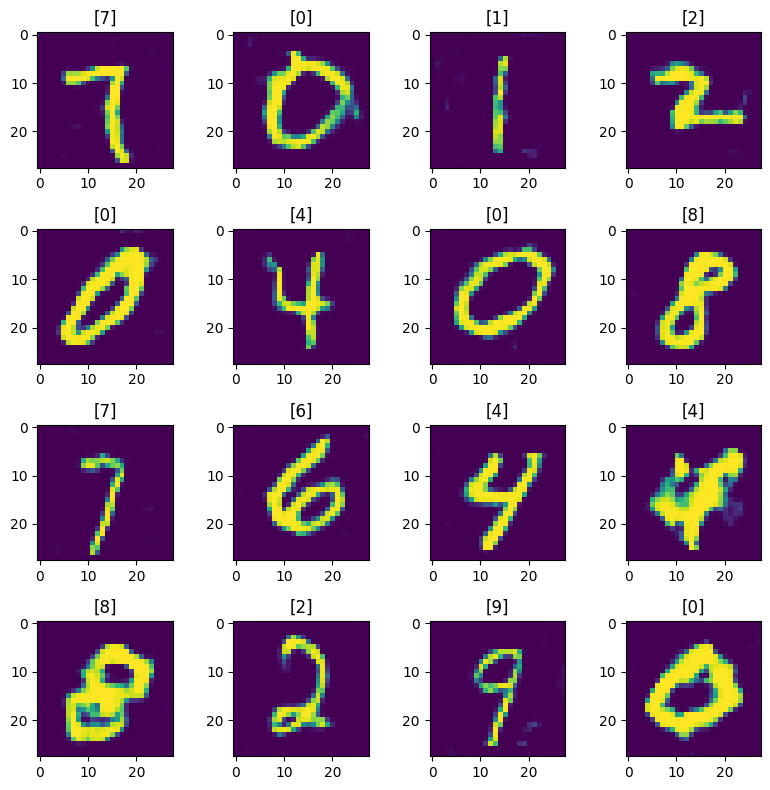

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5776601731777191 [1.0861105918884277, 0.2734375]
1/1 [==============================] - 0s 44ms/step


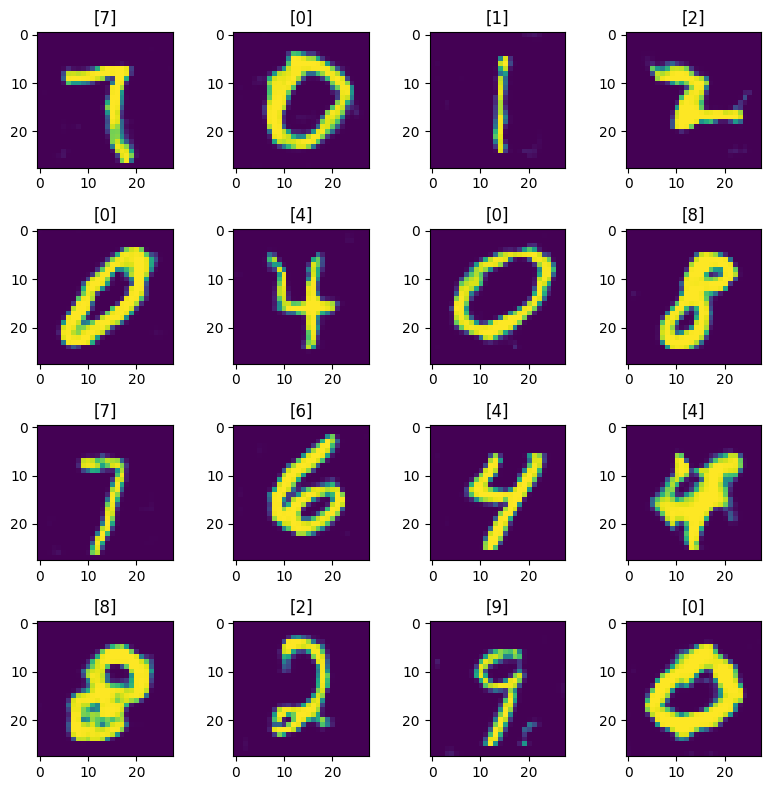

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.6150434017181396 [1.0572547912597656, 0.2734375]
1/1 [==============================] - 0s 27ms/step


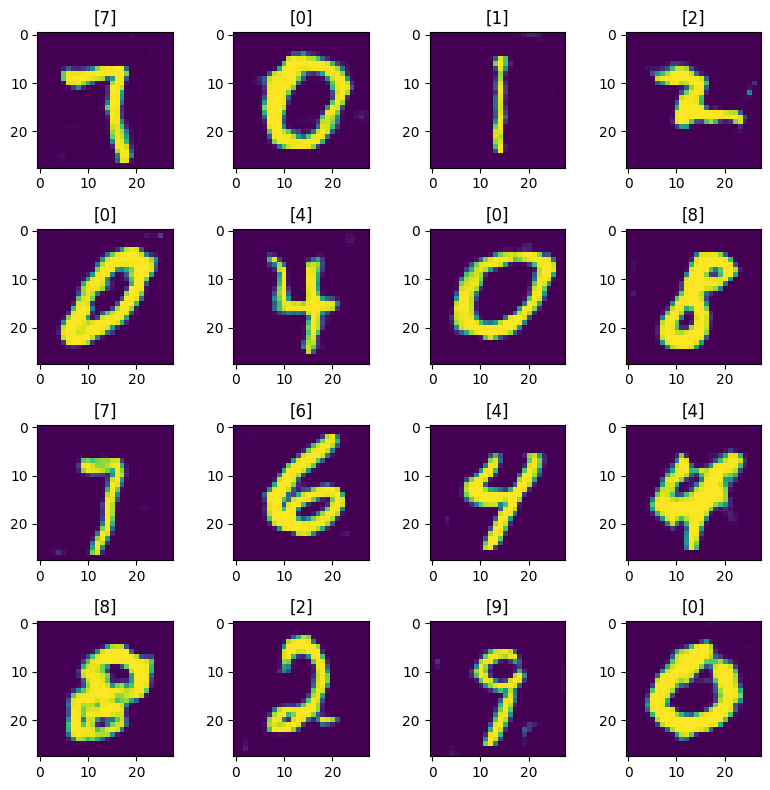

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.6437165141105652 [1.0067836046218872, 0.28125]
1/1 [==============================] - 0s 28ms/step


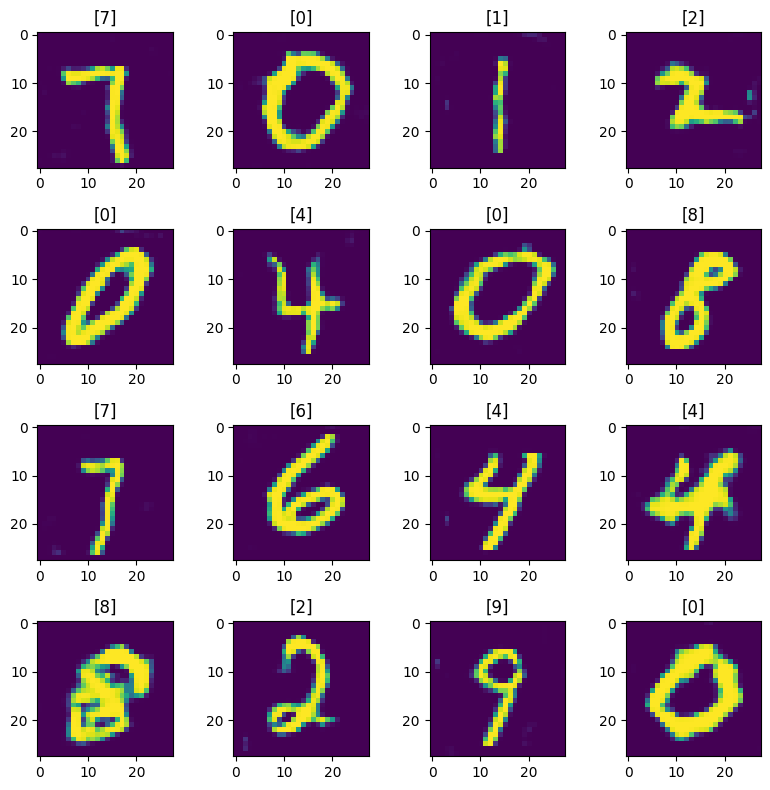

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.6256935596466064 [1.0917397737503052, 0.3125]
1/1 [==============================] - 0s 49ms/step


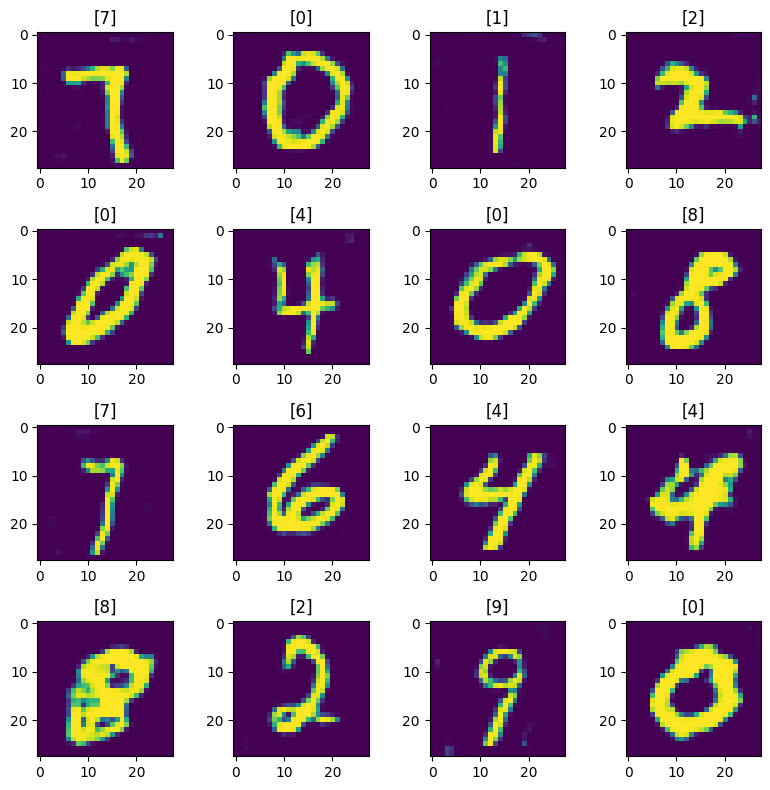

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5874886512756348 [0.9903445243835449, 0.328125]
1/1 [==============================] - 0s 31ms/step


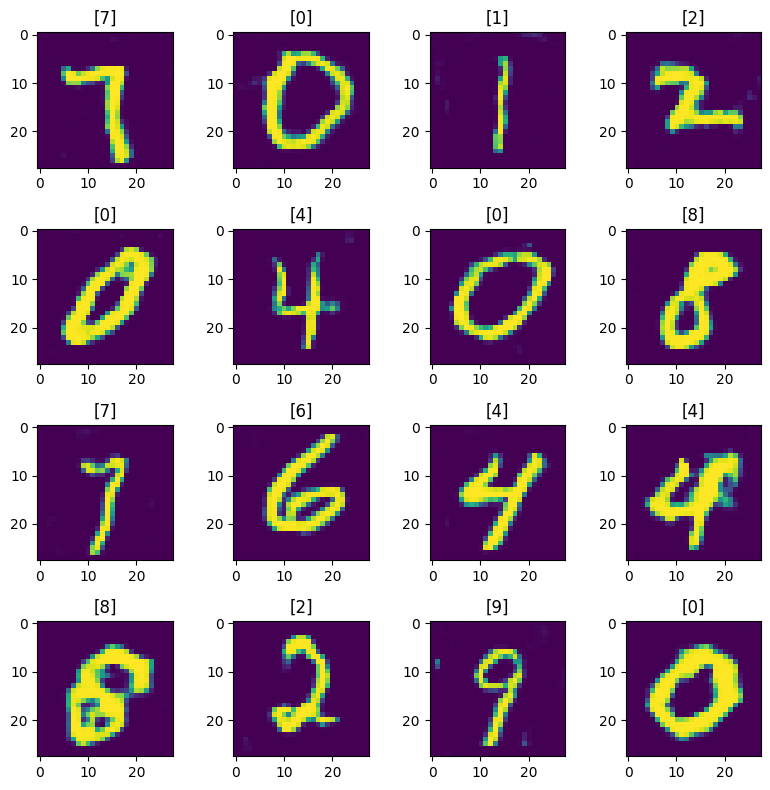

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.595166027545929 [1.0961846113204956, 0.1875]
1/1 [==============================] - 0s 27ms/step


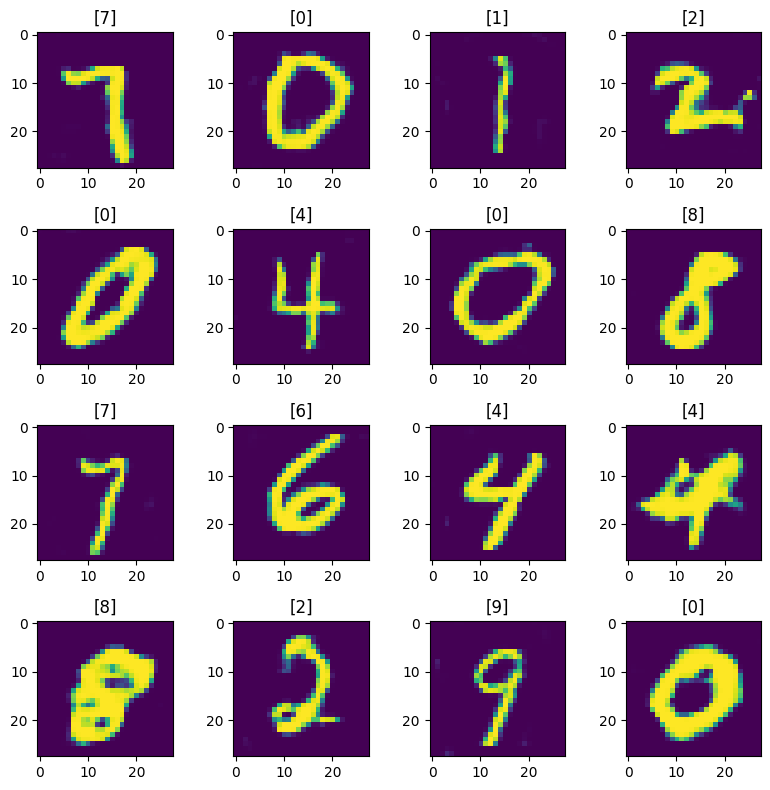

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6096722483634949 [1.08156156539917, 0.2734375]
1/1 [==============================] - 0s 30ms/step


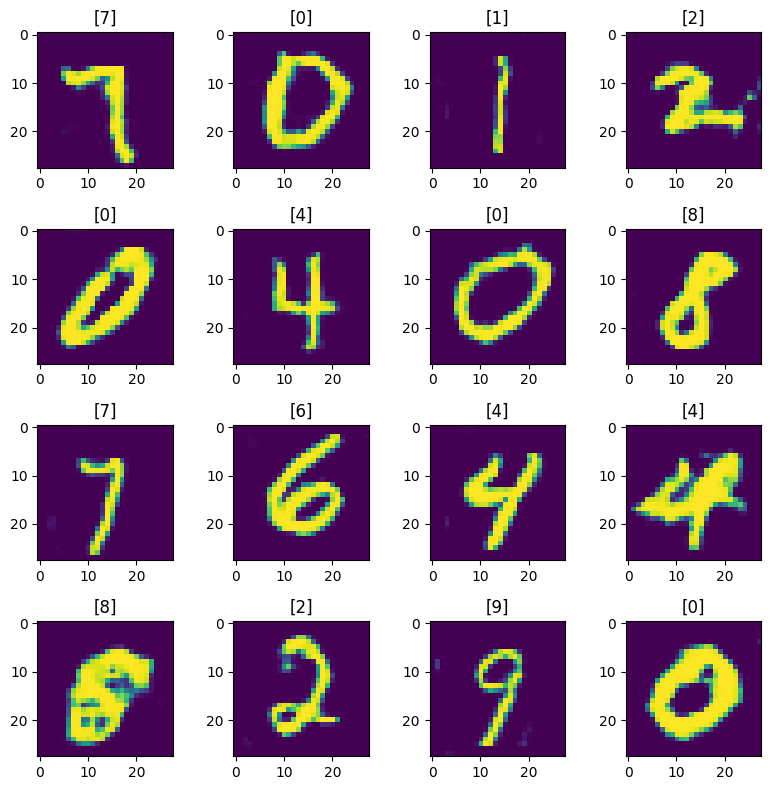

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.6043501198291779 [1.076261281967163, 0.2578125]
1/1 [==============================] - 0s 32ms/step


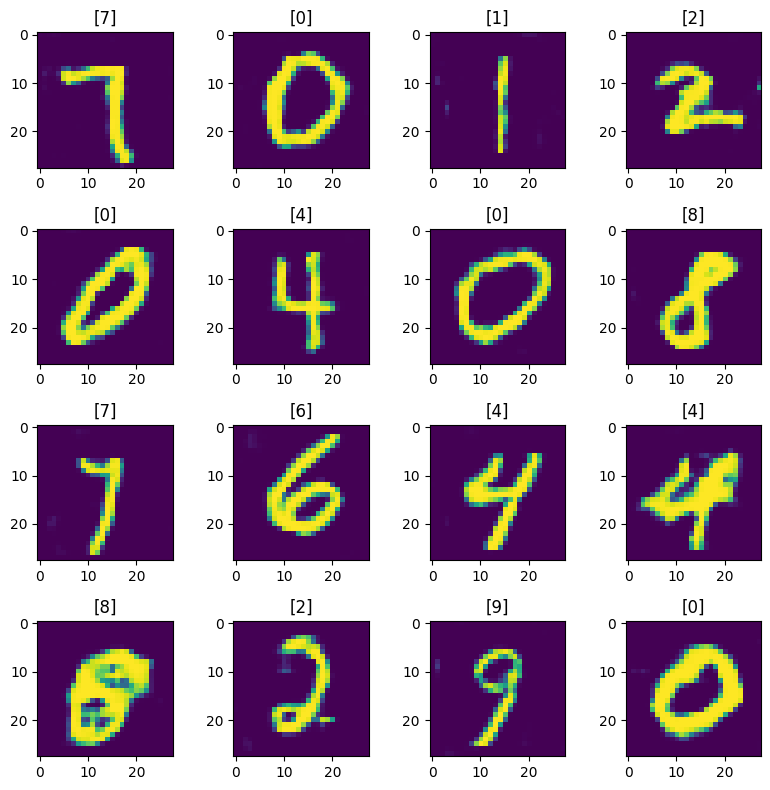

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5751906931400299 [1.082848072052002, 0.2578125]
1/1 [==============================] - 0s 46ms/step


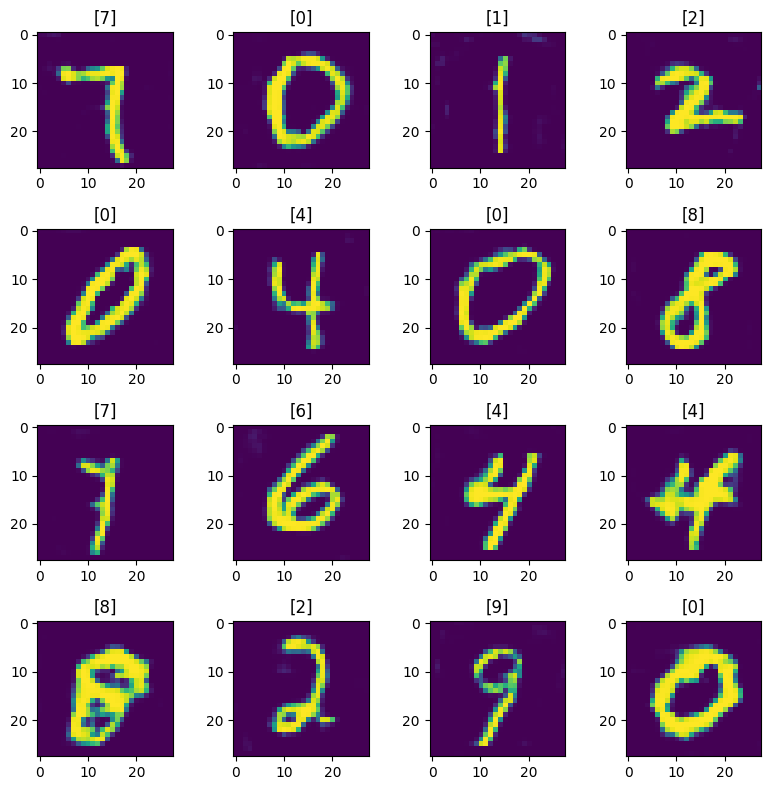

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.63377645611763 [1.165428876876831, 0.2421875]
1/1 [==============================] - 0s 60ms/step


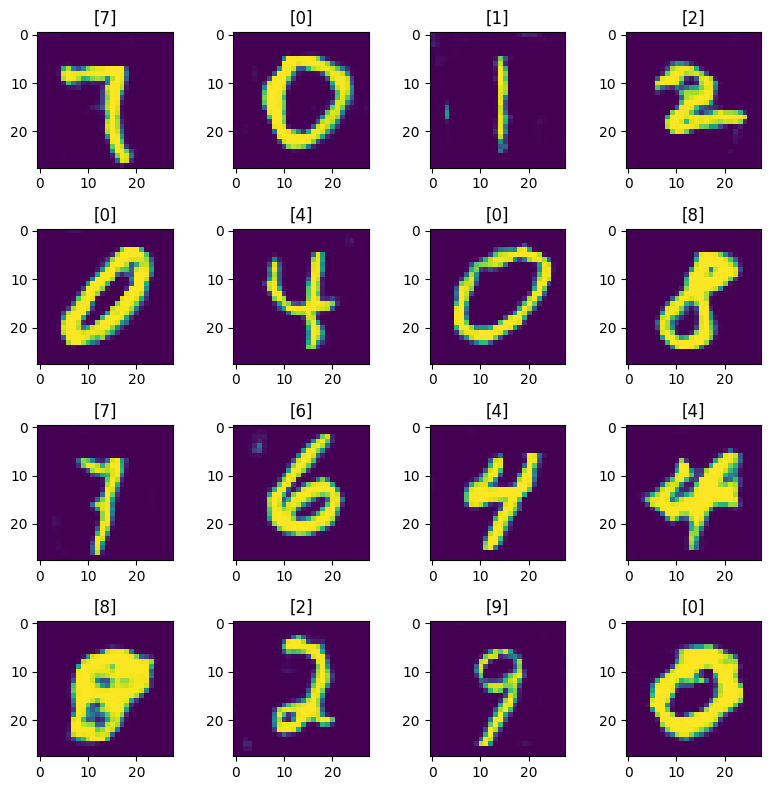

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.6322432458400726 [1.026991605758667, 0.2578125]
1/1 [==============================] - 0s 41ms/step


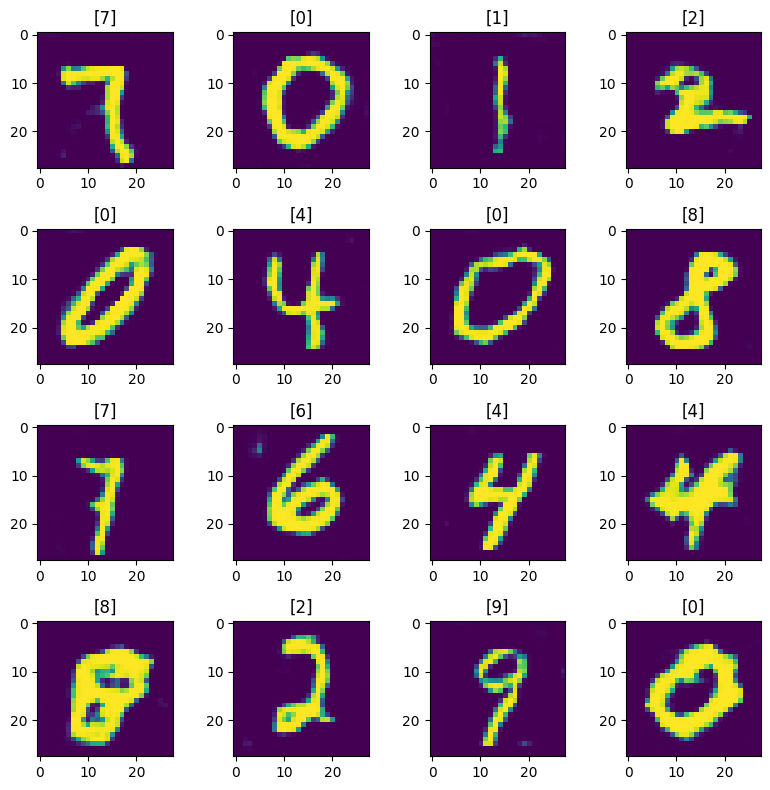

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6232686638832092 [1.0211524963378906, 0.2734375]
1/1 [==============================] - 0s 32ms/step


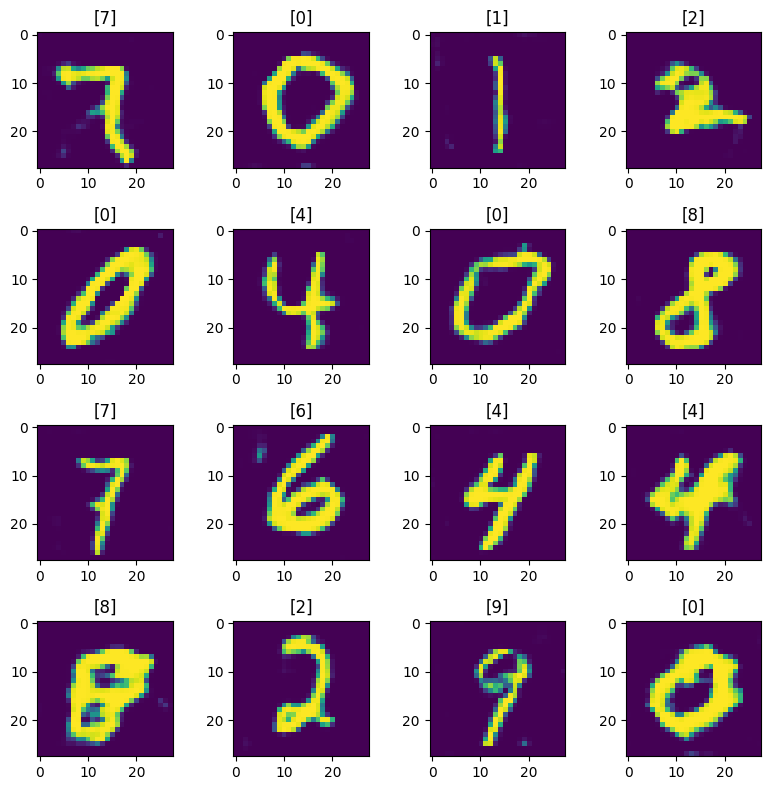

4/4 [==============================] - 0s 5ms/step
Losses(d,g): 0.6110735535621643 [1.0394223928451538, 0.234375]
1/1 [==============================] - 0s 33ms/step


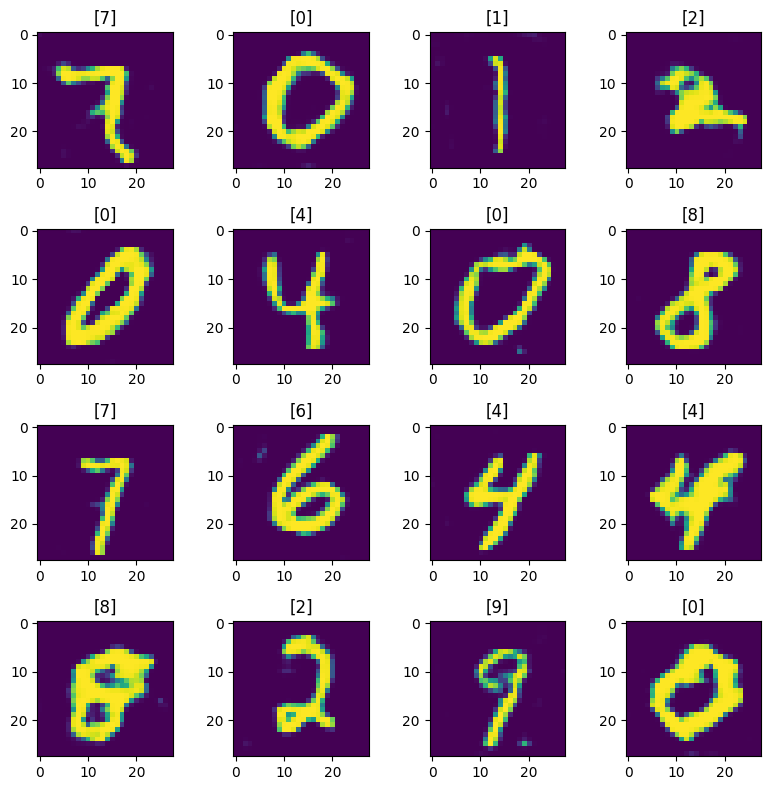

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.6117210388183594 [1.10015869140625, 0.1875]
1/1 [==============================] - 0s 28ms/step


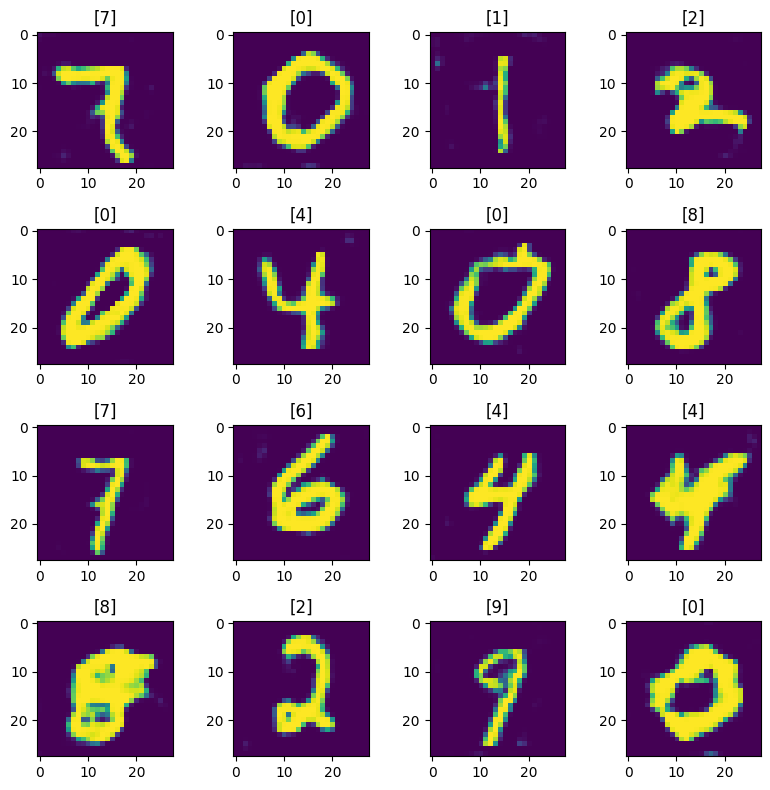

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5934799909591675 [1.064247965812683, 0.21875]
1/1 [==============================] - 0s 28ms/step


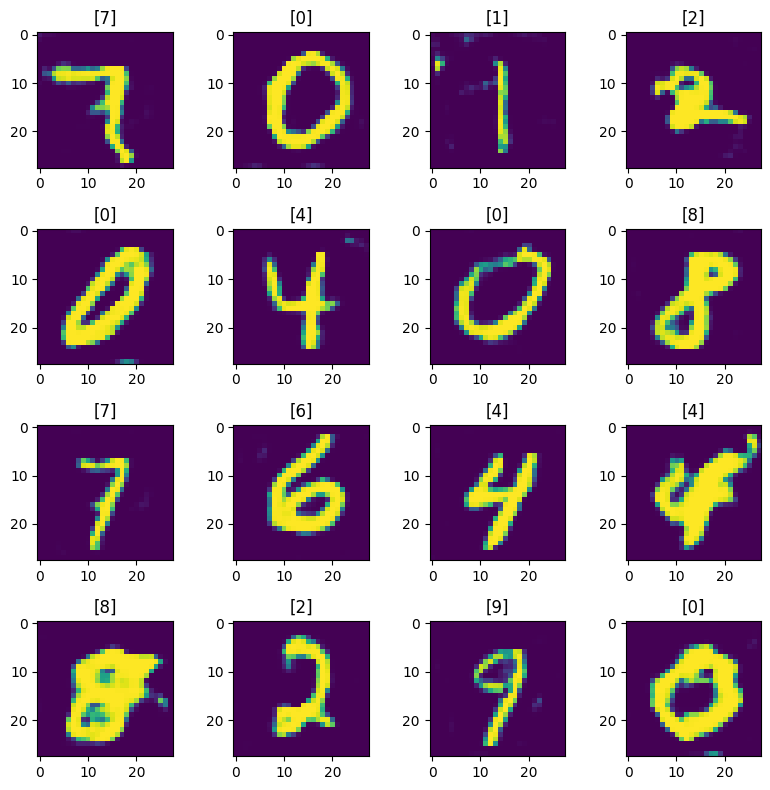

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.6150543987751007 [1.0508430004119873, 0.3125]
1/1 [==============================] - 0s 32ms/step


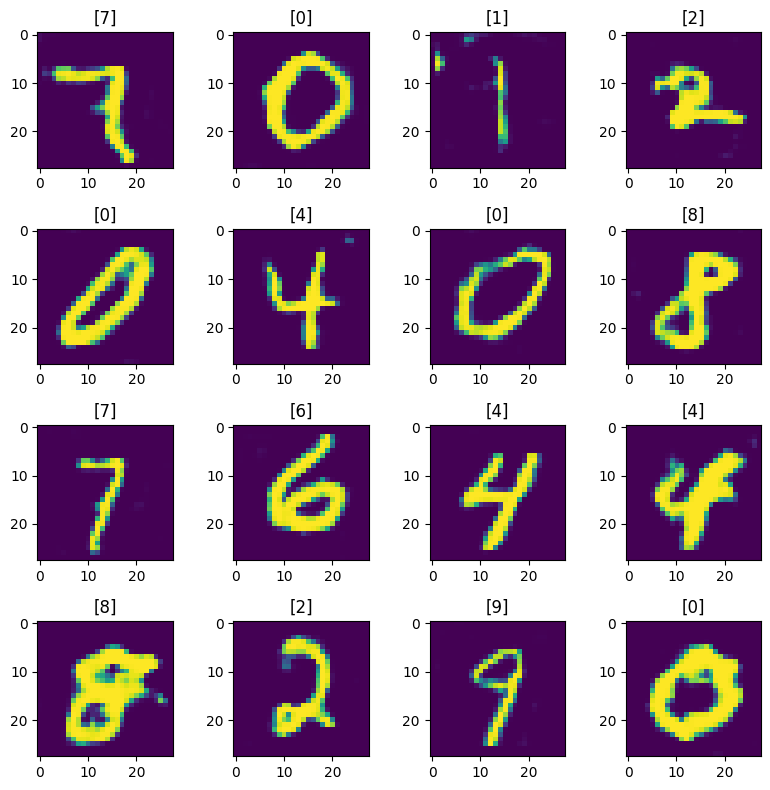

4/4 [==============================] - 0s 6ms/step
Losses(d,g): 0.6048790812492371 [1.1342012882232666, 0.265625]
1/1 [==============================] - 0s 59ms/step


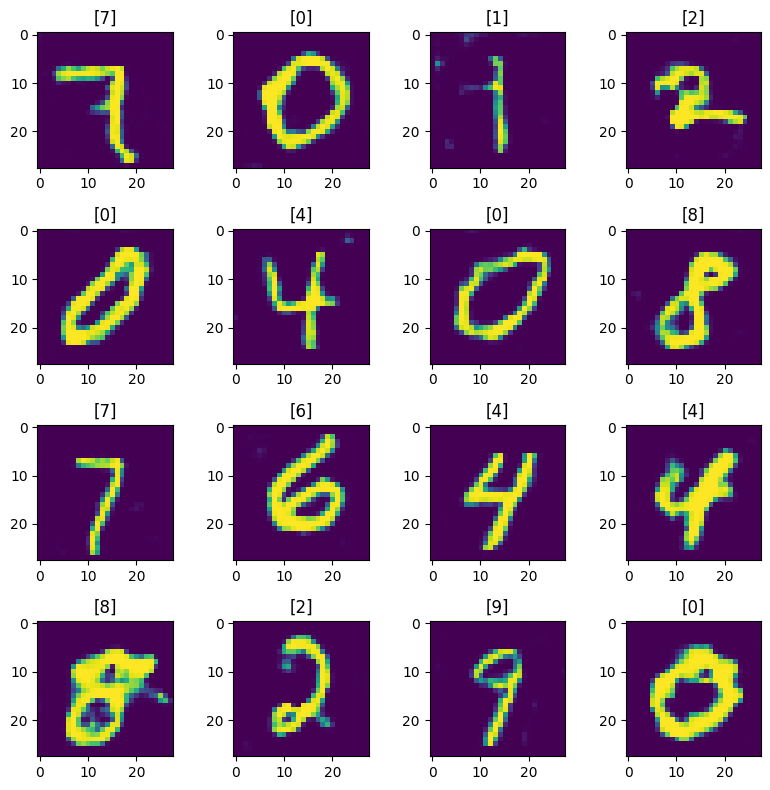

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5548452436923981 [1.2528489828109741, 0.2265625]
1/1 [==============================] - 0s 26ms/step


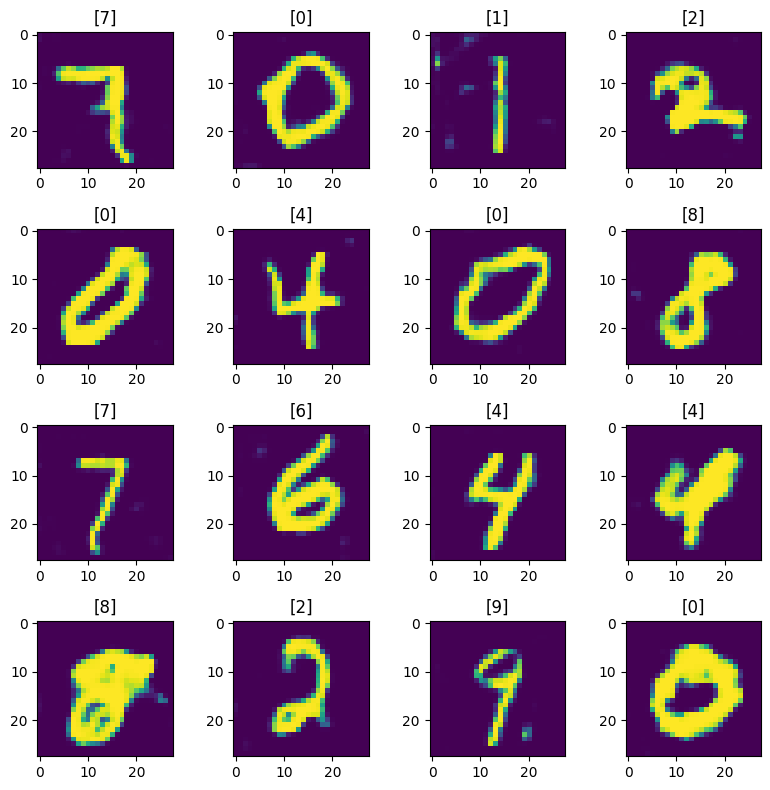

4/4 [==============================] - 0s 3ms/step
Losses(d,g): 0.6047492623329163 [1.0865858793258667, 0.25]
1/1 [==============================] - 0s 26ms/step


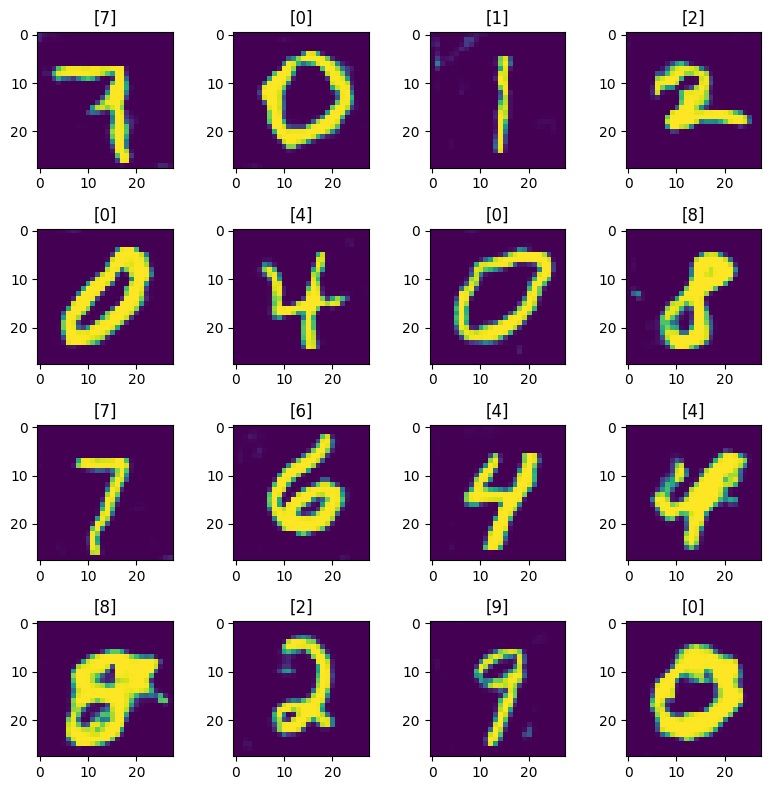

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 0.5131751596927643 [1.2666358947753906, 0.15625]
1/1 [==============================] - 0s 34ms/step


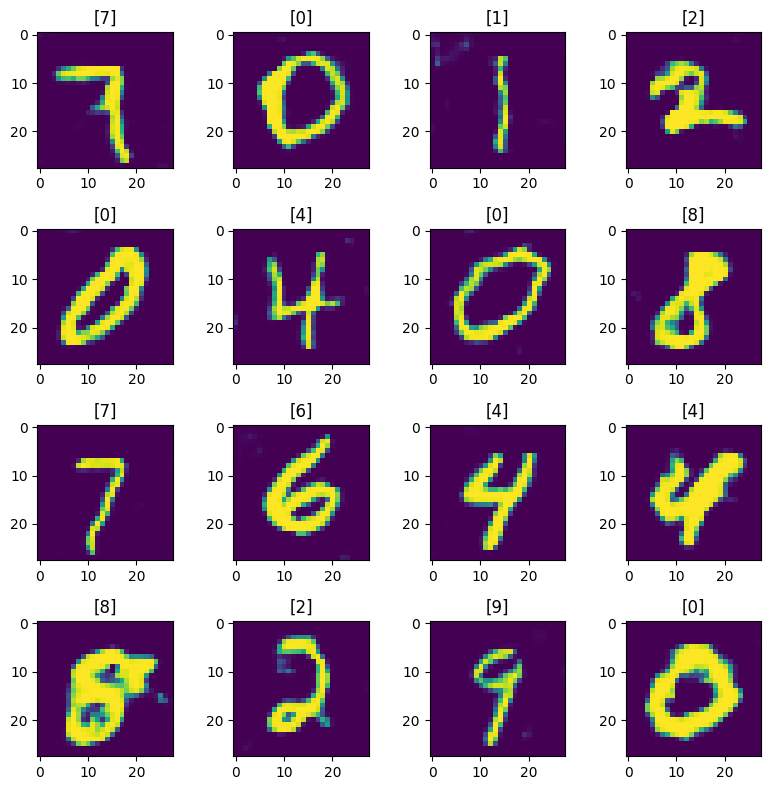

4/4 [==============================] - 0s 4ms/step


In [21]:
import os

epochs = 15005
batch_size = 128
save_interval = 100

print(x_train.shape)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

losses = {"G":[], "D":[]}

samples_test = np.random.normal(0,1,(16, 100))
labels_test = np.random.randint(0, 10, 16).reshape((-1, 1))

for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs, labels = x_train[idx], y_train[idx]

    noise = np.random.normal(0,1,(batch_size, 100))
    fake_imgs = g_model.predict([noise, labels])

    # train discriminator
    d_model.trainable = True
    d_loss_real = d_model.train_on_batch([real_imgs, labels], valid)
    d_loss_fake = d_model.train_on_batch([fake_imgs, labels], fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    d_model.trainable = False

    z = np.random.normal(0,1, size=(batch_size, 100))
    labels = np.random.randint(0, 10, batch_size).reshape((-1, 1))

    # train generator
    g_loss = cgan.train_on_batch([z, labels], valid)

    losses["G"].append(g_loss)
    losses["D"].append(d_loss)

    if epoch % save_interval == 0:
        print("Losses(d,g):", d_loss[0], g_loss)
        results = g_model.predict([samples_test, labels_test])
        plot_image(results, labels_test, 4, 4)


In [22]:
d_model.save('discriminator.h5')
g_model.save('generator.h5')
cgan.save('cgan.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('generator.h5')

enter number from 0:9 : 5
1/1 [==============================] - 0s 19ms/step


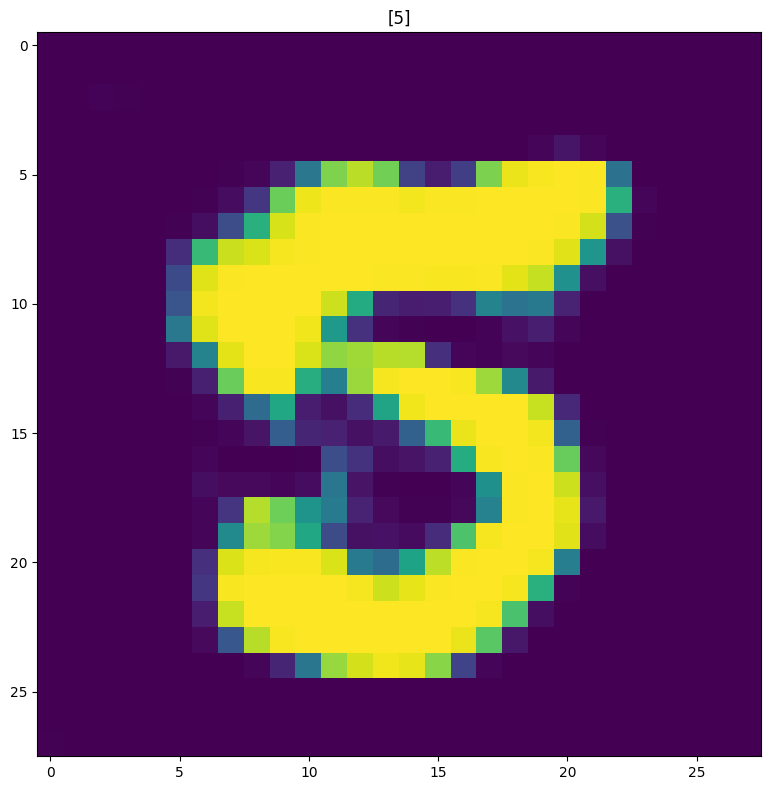

In [77]:
samples_test = np.random.normal(0,1,(1, 100))
labels_test = np.asarray([[int(input("enter number from 0:9 : "))]]).reshape((-1, 1))
results = g_model.predict([samples_test, labels_test])
plot_image(results, labels_test, 1, 1)

In [76]:
labels_test = np.random.randint(0, 10, 1).reshape((-1, 1))
labels_test

array([[0]])

In [57]:
noise = np.random.normal(0,1,(batch_size, 100))
noise

array([[ 1.07908162,  0.37518339, -1.19011153, ...,  0.79501828,
        -0.42934041, -0.48173927],
       [ 0.07042395, -0.2126997 ,  0.52436204, ..., -0.40815218,
        -1.00438801,  0.09018645],
       [ 2.79293201,  2.54312452, -0.63074695, ..., -0.10307678,
        -0.36333315, -0.39250953],
       ...,
       [-0.63666791, -0.61835333,  0.91263343, ...,  0.23217538,
         1.9272596 , -0.663335  ],
       [ 0.6885946 , -1.25643187, -0.23271794, ..., -2.57200167,
         1.12432823,  2.01178833],
       [ 1.12894216,  0.32457203,  0.06021934, ..., -1.55580858,
         0.50563548,  0.26151038]])

In [67]:
labels_test = np.asarray([[int(input("enter number from 0:9 : "))]]).reshape((-1, 1))
labels_test

enter number from 0:9 : 8


array([[8]])

In [6]:
n=5
samples_test = np.random.normal(0,1,(n, 100))
x=int(input("enter number from 0:9 : "))
labels_test = np.asarray([[x]]*n).reshape((-1, 1))
results = g_model.predict([samples_test, labels_test])
plot_image(results, labels_test, 1, 1)

enter number from 0:9 : 8


NameError: ignored

In [2]:
x=int(input("enter number from 0:9 : "))

enter number from 0:9 : 8


In [4]:
import numpy as np

In [5]:
np.asarray([[x]]*5)

array([[8],
       [8],
       [8],
       [8],
       [8]])